In [1]:
import os

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np

from tqdm import tqdm
import random

In [2]:
import model
import dataset
import augmentation as aug

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
def train_epoch(model, optimizer, dataloader, device):


    model.train()

    total_loss = 0
    
    dice_total = 0
    kl_total = 0
    dl_total = 0
    bce_total = 0
    
    dice_loss = smp.utils.losses.DiceLoss()
#     bce_loss = torch.nn.BCELoss(reduction='none')

    for index, data in tqdm(enumerate(dataloader)):

        optimizer.zero_grad()

        img, msk, _ = data

        img = img.to(device)
        msk = msk.to(device, dtype=torch.float)

        pr, kl_loss, dl_loss = model(img)

        ### Predicted mask loss
        pr = pr.squeeze(1)


        dice = dice_loss(pr, msk)
        
        ### bce loss
#         bce = bce_loss(pr, msk)
#         weight = msk.clone().detach()
#         weight = torch.where(weight == 1, 100, 1)
#         bce = bce * weight # weighted foreground/background
#         bce = torch.mean(bce)
        
        kl = torch.mean(kl_loss)
        dl = torch.mean(dl_loss)

        loss = dice
#         loss = dice + kl + dl
#         loss = bce + kl + dl
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        dice_total += dice.item()
#         bce_total += bce.item()
        kl_total += kl.item()
        dl_total += dl.item()

    total_loss = total_loss/(index+1)
    dice_total = dice_total/(index+1)
#     bce_total = bce_total/(index+1)
#     kl_total = kl_total/(index+1)
#     dl_total = dl_total/(index+1)

    return total_loss, dice_total
#     return total_loss, dice_total, kl_total, dl_total

In [5]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):

    import math
    from torch.utils.data import DataLoader

    model.eval()

    iou_score = []
    
    metric_iou = smp.utils.metrics.IoU()

    for index, data in tqdm(enumerate(dataloader)):

        img, msk, _ = data

        img = img.to(device)
        msk = msk.to(device)

        pr, _, _ = model(img)
        iou = metric_iou(pr, msk)

        iou_score.append(iou.item())

    return sum(iou_score)/len(iou_score)

In [6]:
@torch.no_grad()
def test_epoch(model, dataset, device):

    import math
    from torch.utils.data import DataLoader

    model.eval()

    metric_iou = smp.utils.metrics.IoU()
    
    imgs = []
    predict = []
    msks = []
    iou_score = []

    dataloader = DataLoader(dataset, batch_size=1,
                            shuffle=False, num_workers=2)

    for index, data in tqdm(enumerate(dataloader)):

        img, msk, cpy = data

        img = img.to(device)
        msk = msk.to(device)

        pr, _, _ = model(img)

        iou = metric_iou(pr, msk)

        pr = torch.squeeze(pr, dim=0).detach().cpu().numpy()
        msk = torch.squeeze(msk, dim=0).detach().cpu().numpy()
        cpy = torch.squeeze(cpy, dim=0).detach().cpu().numpy()

        predict.append(pr.transpose(1, 2, 0))
        imgs.append(cpy)
        msks.append(msk)
        iou_score.append(iou.item())


    return imgs, predict, msks, iou_score

In [7]:
batch = 4
n_channels = 3
n_classes = 1
epochs = 1000

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [8]:
ENCODER = 'densenet161'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [9]:
unet = smp.Unet(encoder_name=ENCODER, 
                 encoder_weights=ENCODER_WEIGHTS,
                decoder_attention_type=None,
                 in_channels=3, classes=1, activation="sigmoid", aux_params=None)

In [10]:
encoder = unet.encoder

In [11]:
decoder = model.SCGDecoder(None, None, torch.nn.Sigmoid())

In [12]:
scg_net = model.SCGNet(encoder=encoder, 
               decoder=decoder,).to(device)

optimizer = torch.optim.SGD(scg_net.parameters(), lr=1e-3, momentum=0.9)

In [13]:
trainset = dataset.JSRTset(root=os.path.join(os.getcwd(), "data", "trainset"),
                          augmentation=aug.get_training_augmentation(), 
                           preprocessing=aug.get_preprocessing(preprocessing_fn),)
valset = dataset.JSRTset(root=os.path.join(os.getcwd(), "data", "valset"),
                          augmentation=aug.get_validation_augmentation(), 
                           preprocessing=aug.get_preprocessing(preprocessing_fn),)
testset = dataset.JSRTset(root=os.path.join(os.getcwd(), "data", "testset"),
                          augmentation=aug.get_validation_augmentation(), 
                           preprocessing=aug.get_preprocessing(preprocessing_fn),)

In [14]:
trainloader = DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=2)
validloader = DataLoader(valset, batch_size=batch, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch, shuffle=False, num_workers=2)

In [15]:
epoch_logs = {
    "diceloss": [],
#     "bce loss":[],
#     "kl divergence": [],
#     "diagonal loss": [],
    "iou-train": [],
    "iou-valid": []
}

In [16]:
iou_valid = 0.0

for epoch in range(epochs):
    
    loss = train_epoch(scg_net, optimizer, trainloader, device)
    eval_train = eval_epoch(scg_net, trainloader, device)
    eval_valid = eval_epoch(scg_net, validloader, device)
    
#     print("Epoch: {}, total loss={:.5f}, dice loss={:.5f}, kl loss={:.5f}, dl loss={:.5f}".format(epoch, 
#                                                                                                   loss[0],
#                                                                                                  loss[1],
#                                                                                                  loss[2],
#                                                                                                  loss[3]))
    print("Epoch: {}, total loss={:.5f}, dice loss={:.5f}".format(epoch, 
                                                                  loss[0],
                                                                 loss[1],))
    print("Valid-IoU: {:.5f}, Train-IoU: {:.5f}".format(eval_valid, eval_train))
    
    epoch_logs['diceloss'].append(loss[1])
#     epoch_logs["bce loss"].append(loss[1])
#     epoch_logs['kl divergence'].append(loss[2])
#     epoch_logs['diagonal loss'].append(loss[3])
    epoch_logs['iou-train'].append(eval_train)
    epoch_logs['iou-valid'].append(eval_valid)
   
    if epoch == int(epochs*0.5):
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.5
        print('Decrease learning rate to 1e-4!')
    elif epoch == int(epochs*0.75):
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.5
        print('Decrease learning rate to 1e-5!')
        
    if eval_valid > iou_valid:
        iou_valid = eval_valid
        checkpoint = {
            'model_stat': unet.state_dict(),
            'optimizer_stat': optimizer.state_dict(),
        }
        torch.save(checkpoint, os.path.join(os.getcwd(), "{:04d}_{:04d}_{:04d}.pth".format(int(eval_valid*1000),
                                                                                   int(eval_train*1000),
                                                                                   int(loss[0]*1000))))
        print("Model Saved")
    

26it [00:06,  4.22it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.24it/s]


Epoch: 0, total loss=0.99568, dice loss=0.99568
Valid-IoU: 0.00657, Train-IoU: 0.00818
Model Saved


26it [00:05,  4.42it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.18it/s]


Epoch: 1, total loss=0.99578, dice loss=0.99578
Valid-IoU: 0.00658, Train-IoU: 0.00819
Model Saved


26it [00:05,  4.38it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.20it/s]


Epoch: 2, total loss=0.99580, dice loss=0.99580
Valid-IoU: 0.00697, Train-IoU: 0.00868
Model Saved


26it [00:05,  4.40it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.15it/s]


Epoch: 3, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00715, Train-IoU: 0.00916
Model Saved


26it [00:05,  4.37it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.26it/s]


Epoch: 4, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00730, Train-IoU: 0.00907
Model Saved


26it [00:05,  4.36it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.16it/s]

Epoch: 5, total loss=0.99589, dice loss=0.99589
Valid-IoU: 0.00713, Train-IoU: 0.00893



26it [00:05,  4.33it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.16it/s]

Epoch: 6, total loss=0.99594, dice loss=0.99594
Valid-IoU: 0.00719, Train-IoU: 0.00889



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.21it/s]

Epoch: 7, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00714, Train-IoU: 0.00913



26it [00:05,  4.39it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.17it/s]

Epoch: 8, total loss=0.99591, dice loss=0.99591
Valid-IoU: 0.00713, Train-IoU: 0.00894



26it [00:05,  4.34it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.25it/s]

Epoch: 9, total loss=0.99589, dice loss=0.99589
Valid-IoU: 0.00713, Train-IoU: 0.00932



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.05it/s]

Epoch: 10, total loss=0.99584, dice loss=0.99584
Valid-IoU: 0.00716, Train-IoU: 0.00884



26it [00:05,  4.37it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.15it/s]

Epoch: 11, total loss=0.99586, dice loss=0.99586
Valid-IoU: 0.00709, Train-IoU: 0.00931



26it [00:05,  4.39it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.09it/s]

Epoch: 12, total loss=0.99589, dice loss=0.99589
Valid-IoU: 0.00715, Train-IoU: 0.00898



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.24it/s]

Epoch: 13, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00705, Train-IoU: 0.00919



26it [00:05,  4.39it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.22it/s]

Epoch: 14, total loss=0.99582, dice loss=0.99582
Valid-IoU: 0.00703, Train-IoU: 0.00936



26it [00:06,  4.32it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.26it/s]

Epoch: 15, total loss=0.99587, dice loss=0.99587
Valid-IoU: 0.00704, Train-IoU: 0.00894



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.16it/s]

Epoch: 16, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00710, Train-IoU: 0.00913



26it [00:05,  4.38it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.17it/s]

Epoch: 17, total loss=0.99563, dice loss=0.99563
Valid-IoU: 0.00704, Train-IoU: 0.00873



26it [00:05,  4.35it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.31it/s]

Epoch: 18, total loss=0.99591, dice loss=0.99591
Valid-IoU: 0.00709, Train-IoU: 0.00927



26it [00:05,  4.36it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.25it/s]

Epoch: 19, total loss=0.99572, dice loss=0.99572
Valid-IoU: 0.00705, Train-IoU: 0.00899



26it [00:05,  4.36it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.23it/s]

Epoch: 20, total loss=0.99584, dice loss=0.99584
Valid-IoU: 0.00698, Train-IoU: 0.00927



26it [00:05,  4.41it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.26it/s]

Epoch: 21, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00694, Train-IoU: 0.00897



26it [00:05,  4.38it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.21it/s]

Epoch: 22, total loss=0.99586, dice loss=0.99586
Valid-IoU: 0.00689, Train-IoU: 0.00910



26it [00:05,  4.39it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.20it/s]

Epoch: 23, total loss=0.99584, dice loss=0.99584
Valid-IoU: 0.00705, Train-IoU: 0.00893



26it [00:05,  4.41it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.23it/s]

Epoch: 24, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00712, Train-IoU: 0.00920



26it [00:05,  4.39it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.24it/s]

Epoch: 25, total loss=0.99590, dice loss=0.99590
Valid-IoU: 0.00702, Train-IoU: 0.00893



26it [00:05,  4.39it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.14it/s]

Epoch: 26, total loss=0.99590, dice loss=0.99590
Valid-IoU: 0.00709, Train-IoU: 0.00877



26it [00:05,  4.41it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.18it/s]

Epoch: 27, total loss=0.99590, dice loss=0.99590
Valid-IoU: 0.00719, Train-IoU: 0.00905



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.25it/s]

Epoch: 28, total loss=0.99586, dice loss=0.99586
Valid-IoU: 0.00720, Train-IoU: 0.00897



26it [00:05,  4.36it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.17it/s]

Epoch: 29, total loss=0.99586, dice loss=0.99586
Valid-IoU: 0.00691, Train-IoU: 0.00854



26it [00:05,  4.36it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.14it/s]

Epoch: 30, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00703, Train-IoU: 0.00896



26it [00:05,  4.38it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.19it/s]

Epoch: 31, total loss=0.99584, dice loss=0.99584
Valid-IoU: 0.00704, Train-IoU: 0.00860



26it [00:05,  4.37it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.12it/s]

Epoch: 32, total loss=0.99573, dice loss=0.99573
Valid-IoU: 0.00704, Train-IoU: 0.00894



26it [00:06,  4.32it/s]
26it [00:04,  5.51it/s]
5it [00:00,  5.24it/s]

Epoch: 33, total loss=0.99573, dice loss=0.99573
Valid-IoU: 0.00717, Train-IoU: 0.00911



26it [00:05,  4.35it/s]
26it [00:04,  5.45it/s]
5it [00:00,  5.20it/s]

Epoch: 34, total loss=0.99586, dice loss=0.99586
Valid-IoU: 0.00717, Train-IoU: 0.00891



26it [00:05,  4.34it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.23it/s]

Epoch: 35, total loss=0.99578, dice loss=0.99578
Valid-IoU: 0.00712, Train-IoU: 0.00899



26it [00:05,  4.38it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.26it/s]

Epoch: 36, total loss=0.99580, dice loss=0.99580
Valid-IoU: 0.00700, Train-IoU: 0.00896



26it [00:05,  4.39it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.03it/s]

Epoch: 37, total loss=0.99571, dice loss=0.99571
Valid-IoU: 0.00729, Train-IoU: 0.00924



26it [00:05,  4.40it/s]
26it [00:04,  5.80it/s]
5it [00:00,  5.22it/s]

Epoch: 38, total loss=0.99588, dice loss=0.99588
Valid-IoU: 0.00704, Train-IoU: 0.00908



26it [00:05,  4.41it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.14it/s]

Epoch: 39, total loss=0.99580, dice loss=0.99580
Valid-IoU: 0.00713, Train-IoU: 0.00908



26it [00:05,  4.35it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.11it/s]

Epoch: 40, total loss=0.99584, dice loss=0.99584
Valid-IoU: 0.00701, Train-IoU: 0.00894



26it [00:06,  4.32it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.17it/s]

Epoch: 41, total loss=0.99580, dice loss=0.99580
Valid-IoU: 0.00708, Train-IoU: 0.00884



26it [00:05,  4.35it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.28it/s]


Epoch: 42, total loss=0.99588, dice loss=0.99588
Valid-IoU: 0.00736, Train-IoU: 0.00892
Model Saved


26it [00:05,  4.39it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.06it/s]

Epoch: 43, total loss=0.99588, dice loss=0.99588
Valid-IoU: 0.00732, Train-IoU: 0.00877



26it [00:05,  4.38it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.28it/s]

Epoch: 44, total loss=0.99557, dice loss=0.99557
Valid-IoU: 0.00725, Train-IoU: 0.00904



26it [00:05,  4.36it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.16it/s]


Epoch: 45, total loss=0.99558, dice loss=0.99558
Valid-IoU: 0.00739, Train-IoU: 0.00870
Model Saved


26it [00:05,  4.39it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.18it/s]

Epoch: 46, total loss=0.99550, dice loss=0.99550
Valid-IoU: 0.00723, Train-IoU: 0.00892



26it [00:05,  4.38it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.24it/s]

Epoch: 47, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00714, Train-IoU: 0.00925



26it [00:05,  4.40it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.28it/s]

Epoch: 48, total loss=0.99583, dice loss=0.99583
Valid-IoU: 0.00719, Train-IoU: 0.00916



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.11it/s]

Epoch: 49, total loss=0.99591, dice loss=0.99591
Valid-IoU: 0.00723, Train-IoU: 0.00880



26it [00:05,  4.35it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.05it/s]

Epoch: 50, total loss=0.99578, dice loss=0.99578
Valid-IoU: 0.00722, Train-IoU: 0.00885



26it [00:06,  4.33it/s]
26it [00:04,  5.81it/s]
5it [00:00,  5.16it/s]

Epoch: 51, total loss=0.99586, dice loss=0.99586
Valid-IoU: 0.00718, Train-IoU: 0.00897



26it [00:05,  4.39it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.01it/s]

Epoch: 52, total loss=0.99563, dice loss=0.99563
Valid-IoU: 0.00730, Train-IoU: 0.00894



26it [00:05,  4.38it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.13it/s]

Epoch: 53, total loss=0.99587, dice loss=0.99587
Valid-IoU: 0.00735, Train-IoU: 0.00883



26it [00:05,  4.34it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.19it/s]

Epoch: 54, total loss=0.99578, dice loss=0.99578
Valid-IoU: 0.00721, Train-IoU: 0.00885



26it [00:05,  4.35it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.10it/s]

Epoch: 55, total loss=0.99583, dice loss=0.99583
Valid-IoU: 0.00718, Train-IoU: 0.00884



26it [00:05,  4.34it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.20it/s]

Epoch: 56, total loss=0.99580, dice loss=0.99580
Valid-IoU: 0.00708, Train-IoU: 0.00876



26it [00:05,  4.39it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.15it/s]

Epoch: 57, total loss=0.99561, dice loss=0.99561
Valid-IoU: 0.00719, Train-IoU: 0.00916



26it [00:05,  4.38it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.18it/s]

Epoch: 58, total loss=0.99579, dice loss=0.99579
Valid-IoU: 0.00728, Train-IoU: 0.00852



26it [00:05,  4.38it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.27it/s]

Epoch: 59, total loss=0.99589, dice loss=0.99589
Valid-IoU: 0.00717, Train-IoU: 0.00907



26it [00:05,  4.38it/s]
26it [00:04,  5.51it/s]
5it [00:00,  5.12it/s]

Epoch: 60, total loss=0.99589, dice loss=0.99589
Valid-IoU: 0.00723, Train-IoU: 0.00891



26it [00:05,  4.37it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.04it/s]

Epoch: 61, total loss=0.99583, dice loss=0.99583
Valid-IoU: 0.00730, Train-IoU: 0.00862



26it [00:05,  4.34it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.21it/s]

Epoch: 62, total loss=0.99583, dice loss=0.99583
Valid-IoU: 0.00703, Train-IoU: 0.00896



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.23it/s]

Epoch: 63, total loss=0.99583, dice loss=0.99583
Valid-IoU: 0.00715, Train-IoU: 0.00907



26it [00:05,  4.39it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.13it/s]

Epoch: 64, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00718, Train-IoU: 0.00891



26it [00:05,  4.38it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.28it/s]

Epoch: 65, total loss=0.99579, dice loss=0.99579
Valid-IoU: 0.00723, Train-IoU: 0.00844



26it [00:05,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.16it/s]


Epoch: 66, total loss=0.99579, dice loss=0.99579
Valid-IoU: 0.00740, Train-IoU: 0.00882
Model Saved


26it [00:05,  4.35it/s]
26it [00:04,  5.57it/s]
5it [00:01,  4.93it/s]

Epoch: 67, total loss=0.99582, dice loss=0.99582
Valid-IoU: 0.00728, Train-IoU: 0.00905



26it [00:05,  4.38it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.07it/s]

Epoch: 68, total loss=0.99582, dice loss=0.99582
Valid-IoU: 0.00709, Train-IoU: 0.00862



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.15it/s]

Epoch: 69, total loss=0.99579, dice loss=0.99579
Valid-IoU: 0.00700, Train-IoU: 0.00869



26it [00:05,  4.38it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.21it/s]

Epoch: 70, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00730, Train-IoU: 0.00871



26it [00:05,  4.38it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.10it/s]

Epoch: 71, total loss=0.99563, dice loss=0.99563
Valid-IoU: 0.00730, Train-IoU: 0.00868



26it [00:05,  4.37it/s]
26it [00:04,  5.49it/s]
5it [00:00,  5.05it/s]

Epoch: 72, total loss=0.99587, dice loss=0.99587
Valid-IoU: 0.00724, Train-IoU: 0.00855



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.27it/s]

Epoch: 73, total loss=0.99589, dice loss=0.99589
Valid-IoU: 0.00739, Train-IoU: 0.00892



26it [00:05,  4.39it/s]
26it [00:04,  5.47it/s]
5it [00:00,  5.24it/s]

Epoch: 74, total loss=0.99588, dice loss=0.99588
Valid-IoU: 0.00732, Train-IoU: 0.00905



26it [00:05,  4.34it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.08it/s]

Epoch: 75, total loss=0.99579, dice loss=0.99579
Valid-IoU: 0.00726, Train-IoU: 0.00873



26it [00:06,  4.33it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.10it/s]

Epoch: 76, total loss=0.99578, dice loss=0.99578
Valid-IoU: 0.00730, Train-IoU: 0.00861



26it [00:05,  4.37it/s]
26it [00:04,  5.79it/s]
5it [00:00,  5.25it/s]

Epoch: 77, total loss=0.99576, dice loss=0.99576
Valid-IoU: 0.00731, Train-IoU: 0.00832



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.23it/s]


Epoch: 78, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00764, Train-IoU: 0.00869
Model Saved


26it [00:05,  4.38it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.21it/s]

Epoch: 79, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00710, Train-IoU: 0.00863



26it [00:05,  4.34it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.16it/s]

Epoch: 80, total loss=0.99590, dice loss=0.99590
Valid-IoU: 0.00726, Train-IoU: 0.00879



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.16it/s]

Epoch: 81, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00737, Train-IoU: 0.00833



26it [00:05,  4.38it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.14it/s]

Epoch: 82, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00723, Train-IoU: 0.00889



26it [00:05,  4.34it/s]
26it [00:04,  5.58it/s]
5it [00:01,  5.00it/s]

Epoch: 83, total loss=0.99588, dice loss=0.99588
Valid-IoU: 0.00724, Train-IoU: 0.00887



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.01it/s]

Epoch: 84, total loss=0.99582, dice loss=0.99582
Valid-IoU: 0.00712, Train-IoU: 0.00879



26it [00:05,  4.39it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.14it/s]

Epoch: 85, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00731, Train-IoU: 0.00871



26it [00:05,  4.38it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.14it/s]

Epoch: 86, total loss=0.99586, dice loss=0.99586
Valid-IoU: 0.00732, Train-IoU: 0.00845



26it [00:05,  4.38it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.21it/s]

Epoch: 87, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00726, Train-IoU: 0.00895



26it [00:05,  4.40it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.23it/s]

Epoch: 88, total loss=0.99586, dice loss=0.99586
Valid-IoU: 0.00718, Train-IoU: 0.00883



26it [00:05,  4.39it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.19it/s]

Epoch: 89, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00741, Train-IoU: 0.00851



26it [00:05,  4.41it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.16it/s]

Epoch: 90, total loss=0.99578, dice loss=0.99578
Valid-IoU: 0.00737, Train-IoU: 0.00858



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.30it/s]

Epoch: 91, total loss=0.99586, dice loss=0.99586
Valid-IoU: 0.00745, Train-IoU: 0.00833



26it [00:06,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.13it/s]

Epoch: 92, total loss=0.99559, dice loss=0.99559
Valid-IoU: 0.00740, Train-IoU: 0.00873



26it [00:05,  4.38it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.10it/s]

Epoch: 93, total loss=0.99574, dice loss=0.99574
Valid-IoU: 0.00711, Train-IoU: 0.00847



26it [00:05,  4.36it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.17it/s]

Epoch: 94, total loss=0.99574, dice loss=0.99574
Valid-IoU: 0.00733, Train-IoU: 0.00835



26it [00:05,  4.38it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.15it/s]

Epoch: 95, total loss=0.99565, dice loss=0.99565
Valid-IoU: 0.00740, Train-IoU: 0.00890



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.15it/s]

Epoch: 96, total loss=0.99584, dice loss=0.99584
Valid-IoU: 0.00751, Train-IoU: 0.00862



26it [00:05,  4.34it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.26it/s]

Epoch: 97, total loss=0.99579, dice loss=0.99579
Valid-IoU: 0.00710, Train-IoU: 0.00862



26it [00:05,  4.34it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.20it/s]

Epoch: 98, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00737, Train-IoU: 0.00848



26it [00:05,  4.36it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.17it/s]

Epoch: 99, total loss=0.99586, dice loss=0.99586
Valid-IoU: 0.00732, Train-IoU: 0.00870



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.10it/s]

Epoch: 100, total loss=0.99559, dice loss=0.99559
Valid-IoU: 0.00756, Train-IoU: 0.00874



26it [00:05,  4.36it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.15it/s]

Epoch: 101, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00711, Train-IoU: 0.00859



26it [00:05,  4.36it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.15it/s]

Epoch: 102, total loss=0.99573, dice loss=0.99573
Valid-IoU: 0.00749, Train-IoU: 0.00888



26it [00:05,  4.39it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.20it/s]

Epoch: 103, total loss=0.99560, dice loss=0.99560
Valid-IoU: 0.00750, Train-IoU: 0.00881



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.18it/s]

Epoch: 104, total loss=0.99576, dice loss=0.99576
Valid-IoU: 0.00723, Train-IoU: 0.00829



26it [00:05,  4.37it/s]
26it [00:04,  5.49it/s]
5it [00:00,  5.24it/s]

Epoch: 105, total loss=0.99561, dice loss=0.99561
Valid-IoU: 0.00750, Train-IoU: 0.00863



26it [00:05,  4.37it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.24it/s]


Epoch: 106, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00782, Train-IoU: 0.00855
Model Saved


26it [00:05,  4.36it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.16it/s]

Epoch: 107, total loss=0.99560, dice loss=0.99560
Valid-IoU: 0.00765, Train-IoU: 0.00863



26it [00:05,  4.35it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.21it/s]

Epoch: 108, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00762, Train-IoU: 0.00891



26it [00:05,  4.35it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.19it/s]


Epoch: 109, total loss=0.99559, dice loss=0.99559
Valid-IoU: 0.00787, Train-IoU: 0.00852
Model Saved


26it [00:05,  4.34it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.06it/s]


Epoch: 110, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00793, Train-IoU: 0.00866
Model Saved


26it [00:05,  4.36it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.16it/s]

Epoch: 111, total loss=0.99556, dice loss=0.99556
Valid-IoU: 0.00763, Train-IoU: 0.00871



26it [00:05,  4.34it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.15it/s]

Epoch: 112, total loss=0.99583, dice loss=0.99583
Valid-IoU: 0.00735, Train-IoU: 0.00868



26it [00:05,  4.39it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.19it/s]

Epoch: 113, total loss=0.99573, dice loss=0.99573
Valid-IoU: 0.00747, Train-IoU: 0.00870



26it [00:05,  4.34it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.15it/s]

Epoch: 114, total loss=0.99578, dice loss=0.99578
Valid-IoU: 0.00749, Train-IoU: 0.00864



26it [00:05,  4.35it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.13it/s]

Epoch: 115, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00741, Train-IoU: 0.00894



26it [00:05,  4.35it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.09it/s]

Epoch: 116, total loss=0.99579, dice loss=0.99579
Valid-IoU: 0.00759, Train-IoU: 0.00860



26it [00:05,  4.38it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.17it/s]

Epoch: 117, total loss=0.99573, dice loss=0.99573
Valid-IoU: 0.00774, Train-IoU: 0.00823



26it [00:05,  4.38it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.17it/s]

Epoch: 118, total loss=0.99563, dice loss=0.99563
Valid-IoU: 0.00783, Train-IoU: 0.00812



26it [00:05,  4.34it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.15it/s]

Epoch: 119, total loss=0.99571, dice loss=0.99571
Valid-IoU: 0.00764, Train-IoU: 0.00831



26it [00:05,  4.35it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.21it/s]

Epoch: 120, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00778, Train-IoU: 0.00849



26it [00:05,  4.36it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.17it/s]

Epoch: 121, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00771, Train-IoU: 0.00829



26it [00:05,  4.35it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.17it/s]

Epoch: 122, total loss=0.99578, dice loss=0.99578
Valid-IoU: 0.00770, Train-IoU: 0.00860



26it [00:05,  4.36it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.03it/s]

Epoch: 123, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00746, Train-IoU: 0.00831



26it [00:05,  4.35it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.09it/s]

Epoch: 124, total loss=0.99553, dice loss=0.99553
Valid-IoU: 0.00766, Train-IoU: 0.00789



26it [00:05,  4.34it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.18it/s]

Epoch: 125, total loss=0.99563, dice loss=0.99563
Valid-IoU: 0.00722, Train-IoU: 0.00858



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.25it/s]

Epoch: 126, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00766, Train-IoU: 0.00846



26it [00:05,  4.36it/s]
26it [00:04,  5.84it/s]
5it [00:00,  5.18it/s]

Epoch: 127, total loss=0.99544, dice loss=0.99544
Valid-IoU: 0.00784, Train-IoU: 0.00880



26it [00:06,  4.33it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.13it/s]

Epoch: 128, total loss=0.99582, dice loss=0.99582
Valid-IoU: 0.00775, Train-IoU: 0.00840



26it [00:06,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.05it/s]

Epoch: 129, total loss=0.99559, dice loss=0.99559
Valid-IoU: 0.00771, Train-IoU: 0.00841



26it [00:05,  4.38it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.31it/s]

Epoch: 130, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00714, Train-IoU: 0.00865



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.06it/s]

Epoch: 131, total loss=0.99578, dice loss=0.99578
Valid-IoU: 0.00761, Train-IoU: 0.00837



26it [00:05,  4.39it/s]
26it [00:04,  5.79it/s]
5it [00:00,  5.32it/s]

Epoch: 132, total loss=0.99567, dice loss=0.99567
Valid-IoU: 0.00768, Train-IoU: 0.00849



26it [00:05,  4.37it/s]
26it [00:04,  5.72it/s]
5it [00:00,  5.12it/s]

Epoch: 133, total loss=0.99579, dice loss=0.99579
Valid-IoU: 0.00765, Train-IoU: 0.00882



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.33it/s]

Epoch: 134, total loss=0.99570, dice loss=0.99570
Valid-IoU: 0.00772, Train-IoU: 0.00881



26it [00:05,  4.38it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.28it/s]

Epoch: 135, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00776, Train-IoU: 0.00797



26it [00:05,  4.37it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.23it/s]

Epoch: 136, total loss=0.99584, dice loss=0.99584
Valid-IoU: 0.00772, Train-IoU: 0.00794



26it [00:05,  4.37it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.21it/s]

Epoch: 137, total loss=0.99572, dice loss=0.99572
Valid-IoU: 0.00734, Train-IoU: 0.00861



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.19it/s]

Epoch: 138, total loss=0.99554, dice loss=0.99554
Valid-IoU: 0.00774, Train-IoU: 0.00826



26it [00:05,  4.34it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.19it/s]

Epoch: 139, total loss=0.99571, dice loss=0.99571
Valid-IoU: 0.00763, Train-IoU: 0.00869



26it [00:05,  4.38it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.19it/s]

Epoch: 140, total loss=0.99580, dice loss=0.99580
Valid-IoU: 0.00735, Train-IoU: 0.00822



26it [00:05,  4.37it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.16it/s]

Epoch: 141, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00744, Train-IoU: 0.00879



26it [00:05,  4.39it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.07it/s]

Epoch: 142, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00760, Train-IoU: 0.00860



26it [00:05,  4.39it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.11it/s]

Epoch: 143, total loss=0.99584, dice loss=0.99584
Valid-IoU: 0.00743, Train-IoU: 0.00831



26it [00:05,  4.36it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.23it/s]

Epoch: 144, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00756, Train-IoU: 0.00825



26it [00:05,  4.37it/s]
26it [00:04,  5.77it/s]
5it [00:00,  5.08it/s]

Epoch: 145, total loss=0.99555, dice loss=0.99555
Valid-IoU: 0.00752, Train-IoU: 0.00846



26it [00:05,  4.37it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.22it/s]

Epoch: 146, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00741, Train-IoU: 0.00846



26it [00:05,  4.40it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.26it/s]

Epoch: 147, total loss=0.99580, dice loss=0.99580
Valid-IoU: 0.00753, Train-IoU: 0.00812



26it [00:05,  4.38it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.16it/s]

Epoch: 148, total loss=0.99584, dice loss=0.99584
Valid-IoU: 0.00750, Train-IoU: 0.00831



26it [00:05,  4.39it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.14it/s]

Epoch: 149, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00753, Train-IoU: 0.00813



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.14it/s]

Epoch: 150, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00703, Train-IoU: 0.00828



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.16it/s]

Epoch: 151, total loss=0.99553, dice loss=0.99553
Valid-IoU: 0.00768, Train-IoU: 0.00834



26it [00:05,  4.37it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.08it/s]

Epoch: 152, total loss=0.99561, dice loss=0.99561
Valid-IoU: 0.00765, Train-IoU: 0.00863



26it [00:05,  4.39it/s]
26it [00:04,  5.72it/s]
5it [00:00,  5.19it/s]

Epoch: 153, total loss=0.99574, dice loss=0.99574
Valid-IoU: 0.00726, Train-IoU: 0.00827



26it [00:05,  4.38it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.20it/s]

Epoch: 154, total loss=0.99549, dice loss=0.99549
Valid-IoU: 0.00745, Train-IoU: 0.00852



26it [00:06,  4.33it/s]
26it [00:04,  5.76it/s]
5it [00:00,  5.18it/s]

Epoch: 155, total loss=0.99570, dice loss=0.99570
Valid-IoU: 0.00732, Train-IoU: 0.00840



26it [00:05,  4.37it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.22it/s]

Epoch: 156, total loss=0.99550, dice loss=0.99550
Valid-IoU: 0.00753, Train-IoU: 0.00841



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.04it/s]

Epoch: 157, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00774, Train-IoU: 0.00859



26it [00:05,  4.39it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.13it/s]

Epoch: 158, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00723, Train-IoU: 0.00834



26it [00:05,  4.38it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.31it/s]

Epoch: 159, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00743, Train-IoU: 0.00824



26it [00:06,  4.31it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.27it/s]

Epoch: 160, total loss=0.99572, dice loss=0.99572
Valid-IoU: 0.00729, Train-IoU: 0.00842



26it [00:05,  4.38it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.16it/s]

Epoch: 161, total loss=0.99567, dice loss=0.99567
Valid-IoU: 0.00731, Train-IoU: 0.00837



26it [00:05,  4.35it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.03it/s]

Epoch: 162, total loss=0.99573, dice loss=0.99573
Valid-IoU: 0.00750, Train-IoU: 0.00837



26it [00:05,  4.39it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.16it/s]

Epoch: 163, total loss=0.99569, dice loss=0.99569
Valid-IoU: 0.00775, Train-IoU: 0.00822



26it [00:05,  4.36it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.16it/s]

Epoch: 164, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00766, Train-IoU: 0.00780



26it [00:06,  4.33it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.31it/s]

Epoch: 165, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00756, Train-IoU: 0.00837



26it [00:06,  4.33it/s]
26it [00:04,  5.78it/s]
5it [00:00,  5.23it/s]

Epoch: 166, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00745, Train-IoU: 0.00795



26it [00:05,  4.38it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.11it/s]

Epoch: 167, total loss=0.99568, dice loss=0.99568
Valid-IoU: 0.00740, Train-IoU: 0.00814



26it [00:05,  4.40it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.17it/s]

Epoch: 168, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00746, Train-IoU: 0.00812



26it [00:06,  4.33it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.00it/s]

Epoch: 169, total loss=0.99552, dice loss=0.99552
Valid-IoU: 0.00732, Train-IoU: 0.00847



26it [00:05,  4.37it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.21it/s]

Epoch: 170, total loss=0.99570, dice loss=0.99570
Valid-IoU: 0.00753, Train-IoU: 0.00834



26it [00:05,  4.40it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.20it/s]

Epoch: 171, total loss=0.99583, dice loss=0.99583
Valid-IoU: 0.00740, Train-IoU: 0.00808



26it [00:05,  4.34it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.14it/s]

Epoch: 172, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00729, Train-IoU: 0.00856



26it [00:05,  4.36it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.05it/s]

Epoch: 173, total loss=0.99563, dice loss=0.99563
Valid-IoU: 0.00748, Train-IoU: 0.00783



26it [00:05,  4.38it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.19it/s]

Epoch: 174, total loss=0.99573, dice loss=0.99573
Valid-IoU: 0.00719, Train-IoU: 0.00806



26it [00:05,  4.39it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.27it/s]

Epoch: 175, total loss=0.99572, dice loss=0.99572
Valid-IoU: 0.00744, Train-IoU: 0.00799



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.12it/s]

Epoch: 176, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00700, Train-IoU: 0.00823



26it [00:05,  4.37it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.25it/s]

Epoch: 177, total loss=0.99571, dice loss=0.99571
Valid-IoU: 0.00723, Train-IoU: 0.00830



26it [00:05,  4.40it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.15it/s]

Epoch: 178, total loss=0.99581, dice loss=0.99581
Valid-IoU: 0.00730, Train-IoU: 0.00853



26it [00:05,  4.36it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.14it/s]

Epoch: 179, total loss=0.99551, dice loss=0.99551
Valid-IoU: 0.00760, Train-IoU: 0.00830



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.23it/s]

Epoch: 180, total loss=0.99573, dice loss=0.99573
Valid-IoU: 0.00788, Train-IoU: 0.00813



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.12it/s]

Epoch: 181, total loss=0.99560, dice loss=0.99560
Valid-IoU: 0.00732, Train-IoU: 0.00805



26it [00:05,  4.34it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.15it/s]

Epoch: 182, total loss=0.99585, dice loss=0.99585
Valid-IoU: 0.00753, Train-IoU: 0.00823



26it [00:05,  4.34it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.17it/s]

Epoch: 183, total loss=0.99576, dice loss=0.99576
Valid-IoU: 0.00770, Train-IoU: 0.00802



26it [00:05,  4.35it/s]
26it [00:04,  5.72it/s]
5it [00:00,  5.09it/s]

Epoch: 184, total loss=0.99565, dice loss=0.99565
Valid-IoU: 0.00787, Train-IoU: 0.00840



26it [00:05,  4.37it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.19it/s]

Epoch: 185, total loss=0.99578, dice loss=0.99578
Valid-IoU: 0.00777, Train-IoU: 0.00801



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.02it/s]

Epoch: 186, total loss=0.99574, dice loss=0.99574
Valid-IoU: 0.00730, Train-IoU: 0.00851



26it [00:06,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.25it/s]


Epoch: 187, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00802, Train-IoU: 0.00830
Model Saved


26it [00:05,  4.39it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.09it/s]

Epoch: 188, total loss=0.99548, dice loss=0.99548
Valid-IoU: 0.00800, Train-IoU: 0.00845



26it [00:06,  4.33it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.24it/s]

Epoch: 189, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00745, Train-IoU: 0.00795



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.24it/s]

Epoch: 190, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00743, Train-IoU: 0.00785



26it [00:05,  4.38it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.10it/s]

Epoch: 191, total loss=0.99577, dice loss=0.99577
Valid-IoU: 0.00770, Train-IoU: 0.00809



26it [00:05,  4.39it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.14it/s]

Epoch: 192, total loss=0.99576, dice loss=0.99576
Valid-IoU: 0.00728, Train-IoU: 0.00800



26it [00:05,  4.36it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.24it/s]

Epoch: 193, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00774, Train-IoU: 0.00879



26it [00:05,  4.39it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.22it/s]

Epoch: 194, total loss=0.99550, dice loss=0.99550
Valid-IoU: 0.00750, Train-IoU: 0.00788



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.25it/s]

Epoch: 195, total loss=0.99571, dice loss=0.99571
Valid-IoU: 0.00760, Train-IoU: 0.00831



26it [00:05,  4.38it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.11it/s]

Epoch: 196, total loss=0.99554, dice loss=0.99554
Valid-IoU: 0.00799, Train-IoU: 0.00788



26it [00:05,  4.36it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.24it/s]

Epoch: 197, total loss=0.99579, dice loss=0.99579
Valid-IoU: 0.00781, Train-IoU: 0.00812



26it [00:05,  4.34it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.14it/s]


Epoch: 198, total loss=0.99559, dice loss=0.99559
Valid-IoU: 0.00828, Train-IoU: 0.00818
Model Saved


26it [00:05,  4.38it/s]
26it [00:04,  5.72it/s]
5it [00:00,  5.21it/s]

Epoch: 199, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00738, Train-IoU: 0.00828



26it [00:05,  4.39it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.14it/s]

Epoch: 200, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00766, Train-IoU: 0.00802



26it [00:05,  4.36it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.17it/s]

Epoch: 201, total loss=0.99568, dice loss=0.99568
Valid-IoU: 0.00747, Train-IoU: 0.00782



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.20it/s]

Epoch: 202, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00788, Train-IoU: 0.00820



26it [00:05,  4.36it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.11it/s]

Epoch: 203, total loss=0.99576, dice loss=0.99576
Valid-IoU: 0.00786, Train-IoU: 0.00811



26it [00:05,  4.39it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.07it/s]

Epoch: 204, total loss=0.99560, dice loss=0.99560
Valid-IoU: 0.00809, Train-IoU: 0.00787



26it [00:05,  4.34it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.19it/s]

Epoch: 205, total loss=0.99565, dice loss=0.99565
Valid-IoU: 0.00804, Train-IoU: 0.00775



26it [00:05,  4.39it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.14it/s]

Epoch: 206, total loss=0.99573, dice loss=0.99573
Valid-IoU: 0.00810, Train-IoU: 0.00810



26it [00:05,  4.34it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.14it/s]

Epoch: 207, total loss=0.99546, dice loss=0.99546
Valid-IoU: 0.00790, Train-IoU: 0.00831



26it [00:05,  4.39it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.13it/s]


Epoch: 208, total loss=0.99569, dice loss=0.99569
Valid-IoU: 0.00841, Train-IoU: 0.00804
Model Saved


26it [00:05,  4.38it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.14it/s]

Epoch: 209, total loss=0.99570, dice loss=0.99570
Valid-IoU: 0.00755, Train-IoU: 0.00800



26it [00:05,  4.41it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.11it/s]

Epoch: 210, total loss=0.99558, dice loss=0.99558
Valid-IoU: 0.00794, Train-IoU: 0.00799



26it [00:05,  4.38it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.19it/s]

Epoch: 211, total loss=0.99571, dice loss=0.99571
Valid-IoU: 0.00770, Train-IoU: 0.00831



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.08it/s]

Epoch: 212, total loss=0.99571, dice loss=0.99571
Valid-IoU: 0.00782, Train-IoU: 0.00864



26it [00:05,  4.37it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.29it/s]

Epoch: 213, total loss=0.99568, dice loss=0.99568
Valid-IoU: 0.00833, Train-IoU: 0.00808



26it [00:06,  4.31it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.37it/s]

Epoch: 214, total loss=0.99547, dice loss=0.99547
Valid-IoU: 0.00786, Train-IoU: 0.00761



26it [00:05,  4.39it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.19it/s]

Epoch: 215, total loss=0.99553, dice loss=0.99553
Valid-IoU: 0.00714, Train-IoU: 0.00788



26it [00:05,  4.37it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.18it/s]

Epoch: 216, total loss=0.99558, dice loss=0.99558
Valid-IoU: 0.00788, Train-IoU: 0.00837



26it [00:05,  4.37it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.19it/s]

Epoch: 217, total loss=0.99573, dice loss=0.99573
Valid-IoU: 0.00797, Train-IoU: 0.00808



26it [00:05,  4.36it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.13it/s]

Epoch: 218, total loss=0.99572, dice loss=0.99572
Valid-IoU: 0.00808, Train-IoU: 0.00849



26it [00:05,  4.39it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.19it/s]

Epoch: 219, total loss=0.99567, dice loss=0.99567
Valid-IoU: 0.00750, Train-IoU: 0.00794



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.20it/s]

Epoch: 220, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00811, Train-IoU: 0.00805



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.29it/s]

Epoch: 221, total loss=0.99545, dice loss=0.99545
Valid-IoU: 0.00777, Train-IoU: 0.00794



26it [00:05,  4.38it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.12it/s]


Epoch: 222, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00848, Train-IoU: 0.00787
Model Saved


26it [00:05,  4.35it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.30it/s]

Epoch: 223, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00716, Train-IoU: 0.00794



26it [00:05,  4.35it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.19it/s]

Epoch: 224, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00790, Train-IoU: 0.00775



26it [00:05,  4.39it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.11it/s]

Epoch: 225, total loss=0.99544, dice loss=0.99544
Valid-IoU: 0.00795, Train-IoU: 0.00839



26it [00:05,  4.34it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.20it/s]

Epoch: 226, total loss=0.99565, dice loss=0.99565
Valid-IoU: 0.00695, Train-IoU: 0.00806



26it [00:05,  4.34it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.14it/s]

Epoch: 227, total loss=0.99567, dice loss=0.99567
Valid-IoU: 0.00793, Train-IoU: 0.00831



26it [00:05,  4.36it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.08it/s]

Epoch: 228, total loss=0.99562, dice loss=0.99562
Valid-IoU: 0.00822, Train-IoU: 0.00851



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.23it/s]

Epoch: 229, total loss=0.99568, dice loss=0.99568
Valid-IoU: 0.00799, Train-IoU: 0.00778



26it [00:05,  4.37it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.26it/s]

Epoch: 230, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00807, Train-IoU: 0.00826



26it [00:05,  4.37it/s]
26it [00:04,  5.51it/s]
5it [00:00,  5.14it/s]


Epoch: 231, total loss=0.99568, dice loss=0.99568
Valid-IoU: 0.00865, Train-IoU: 0.00813
Model Saved


26it [00:05,  4.38it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.06it/s]

Epoch: 232, total loss=0.99575, dice loss=0.99575
Valid-IoU: 0.00762, Train-IoU: 0.00789



26it [00:05,  4.37it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.27it/s]

Epoch: 233, total loss=0.99568, dice loss=0.99568
Valid-IoU: 0.00841, Train-IoU: 0.00850



26it [00:05,  4.36it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.30it/s]

Epoch: 234, total loss=0.99564, dice loss=0.99564
Valid-IoU: 0.00782, Train-IoU: 0.00825



26it [00:05,  4.34it/s]
26it [00:04,  5.51it/s]
5it [00:00,  5.00it/s]

Epoch: 235, total loss=0.99564, dice loss=0.99564
Valid-IoU: 0.00767, Train-IoU: 0.00746



26it [00:05,  4.39it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.19it/s]

Epoch: 236, total loss=0.99571, dice loss=0.99571
Valid-IoU: 0.00783, Train-IoU: 0.00778



26it [00:06,  4.33it/s]
26it [00:04,  5.49it/s]
5it [00:00,  5.26it/s]

Epoch: 237, total loss=0.99562, dice loss=0.99562
Valid-IoU: 0.00806, Train-IoU: 0.00837



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.14it/s]

Epoch: 238, total loss=0.99564, dice loss=0.99564
Valid-IoU: 0.00778, Train-IoU: 0.00797



26it [00:05,  4.40it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.14it/s]

Epoch: 239, total loss=0.99565, dice loss=0.99565
Valid-IoU: 0.00828, Train-IoU: 0.00777



26it [00:05,  4.38it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.19it/s]

Epoch: 240, total loss=0.99563, dice loss=0.99563
Valid-IoU: 0.00721, Train-IoU: 0.00794



26it [00:05,  4.37it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.20it/s]

Epoch: 241, total loss=0.99574, dice loss=0.99574
Valid-IoU: 0.00835, Train-IoU: 0.00813



26it [00:05,  4.37it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.13it/s]

Epoch: 242, total loss=0.99568, dice loss=0.99568
Valid-IoU: 0.00820, Train-IoU: 0.00794



26it [00:05,  4.39it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.16it/s]

Epoch: 243, total loss=0.99528, dice loss=0.99528
Valid-IoU: 0.00437, Train-IoU: 0.00724



26it [00:05,  4.36it/s]
26it [00:04,  5.76it/s]
5it [00:00,  5.14it/s]

Epoch: 244, total loss=0.99556, dice loss=0.99556
Valid-IoU: 0.00808, Train-IoU: 0.00781



26it [00:05,  4.37it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.07it/s]

Epoch: 245, total loss=0.99550, dice loss=0.99550
Valid-IoU: 0.00556, Train-IoU: 0.00770



26it [00:05,  4.38it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.02it/s]

Epoch: 246, total loss=0.99553, dice loss=0.99553
Valid-IoU: 0.00705, Train-IoU: 0.00800



26it [00:05,  4.40it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.25it/s]

Epoch: 247, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00860, Train-IoU: 0.00853



26it [00:05,  4.34it/s]
26it [00:04,  5.49it/s]
5it [00:00,  5.20it/s]

Epoch: 248, total loss=0.99566, dice loss=0.99566
Valid-IoU: 0.00716, Train-IoU: 0.00713



26it [00:05,  4.38it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.25it/s]

Epoch: 249, total loss=0.99567, dice loss=0.99567
Valid-IoU: 0.00777, Train-IoU: 0.00810



26it [00:05,  4.35it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.22it/s]

Epoch: 250, total loss=0.99561, dice loss=0.99561
Valid-IoU: 0.00754, Train-IoU: 0.00884



26it [00:05,  4.34it/s]
26it [00:04,  5.82it/s]
5it [00:00,  5.23it/s]

Epoch: 251, total loss=0.99571, dice loss=0.99571
Valid-IoU: 0.00716, Train-IoU: 0.00859



26it [00:05,  4.39it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.19it/s]

Epoch: 252, total loss=0.99557, dice loss=0.99557
Valid-IoU: 0.00735, Train-IoU: 0.00746



26it [00:05,  4.34it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.28it/s]

Epoch: 253, total loss=0.99571, dice loss=0.99571
Valid-IoU: 0.00648, Train-IoU: 0.00825



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.16it/s]

Epoch: 254, total loss=0.99544, dice loss=0.99544
Valid-IoU: 0.00646, Train-IoU: 0.00739



26it [00:05,  4.36it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.40it/s]

Epoch: 255, total loss=0.99561, dice loss=0.99561
Valid-IoU: 0.00759, Train-IoU: 0.00758



26it [00:05,  4.35it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.17it/s]

Epoch: 256, total loss=0.99570, dice loss=0.99570
Valid-IoU: 0.00807, Train-IoU: 0.00790



26it [00:05,  4.37it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.27it/s]

Epoch: 257, total loss=0.99545, dice loss=0.99545
Valid-IoU: 0.00818, Train-IoU: 0.00791



26it [00:05,  4.37it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.18it/s]

Epoch: 258, total loss=0.99564, dice loss=0.99564
Valid-IoU: 0.00760, Train-IoU: 0.00817



26it [00:05,  4.37it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.17it/s]


Epoch: 259, total loss=0.99557, dice loss=0.99557
Valid-IoU: 0.00622, Train-IoU: 0.00736


26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.16it/s]

Epoch: 260, total loss=0.99547, dice loss=0.99547
Valid-IoU: 0.00787, Train-IoU: 0.00792



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.12it/s]

Epoch: 261, total loss=0.99567, dice loss=0.99567
Valid-IoU: 0.00491, Train-IoU: 0.00780



26it [00:05,  4.37it/s]
26it [00:04,  5.53it/s]
5it [00:01,  4.95it/s]

Epoch: 262, total loss=0.99570, dice loss=0.99570
Valid-IoU: 0.00791, Train-IoU: 0.00748



26it [00:06,  4.32it/s]
26it [00:04,  5.50it/s]
5it [00:00,  5.14it/s]

Epoch: 263, total loss=0.99536, dice loss=0.99536
Valid-IoU: 0.00521, Train-IoU: 0.00724



26it [00:05,  4.34it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.21it/s]

Epoch: 264, total loss=0.99535, dice loss=0.99535
Valid-IoU: 0.00490, Train-IoU: 0.00759



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.20it/s]

Epoch: 265, total loss=0.99548, dice loss=0.99548
Valid-IoU: 0.00818, Train-IoU: 0.00821



26it [00:06,  4.32it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.18it/s]

Epoch: 266, total loss=0.99562, dice loss=0.99562
Valid-IoU: 0.00818, Train-IoU: 0.00809



26it [00:05,  4.35it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.13it/s]

Epoch: 267, total loss=0.99542, dice loss=0.99542
Valid-IoU: 0.00721, Train-IoU: 0.00779



26it [00:05,  4.35it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.12it/s]

Epoch: 268, total loss=0.99558, dice loss=0.99558
Valid-IoU: 0.00745, Train-IoU: 0.00753



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.14it/s]

Epoch: 269, total loss=0.99564, dice loss=0.99564
Valid-IoU: 0.00463, Train-IoU: 0.00728



26it [00:05,  4.34it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.17it/s]

Epoch: 270, total loss=0.99557, dice loss=0.99557
Valid-IoU: 0.00433, Train-IoU: 0.00757



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.18it/s]

Epoch: 271, total loss=0.99561, dice loss=0.99561
Valid-IoU: 0.00812, Train-IoU: 0.00763



26it [00:05,  4.36it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.21it/s]

Epoch: 272, total loss=0.99558, dice loss=0.99558
Valid-IoU: 0.00718, Train-IoU: 0.00698



26it [00:06,  4.32it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.12it/s]

Epoch: 273, total loss=0.99555, dice loss=0.99555
Valid-IoU: 0.00383, Train-IoU: 0.00791



26it [00:05,  4.34it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.15it/s]

Epoch: 274, total loss=0.99556, dice loss=0.99556
Valid-IoU: 0.00531, Train-IoU: 0.00708



26it [00:05,  4.37it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.17it/s]

Epoch: 275, total loss=0.99559, dice loss=0.99559
Valid-IoU: 0.00530, Train-IoU: 0.00713



26it [00:05,  4.40it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.06it/s]

Epoch: 276, total loss=0.99559, dice loss=0.99559
Valid-IoU: 0.00768, Train-IoU: 0.00776



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.18it/s]

Epoch: 277, total loss=0.99554, dice loss=0.99554
Valid-IoU: 0.00602, Train-IoU: 0.00753



26it [00:05,  4.37it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.11it/s]

Epoch: 278, total loss=0.99550, dice loss=0.99550
Valid-IoU: 0.00494, Train-IoU: 0.00722



26it [00:05,  4.35it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.19it/s]

Epoch: 279, total loss=0.99558, dice loss=0.99558
Valid-IoU: 0.00496, Train-IoU: 0.00661



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.22it/s]

Epoch: 280, total loss=0.99540, dice loss=0.99540
Valid-IoU: 0.00580, Train-IoU: 0.00790



26it [00:05,  4.34it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.18it/s]

Epoch: 281, total loss=0.99561, dice loss=0.99561
Valid-IoU: 0.00683, Train-IoU: 0.00802



26it [00:05,  4.34it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.18it/s]

Epoch: 282, total loss=0.99555, dice loss=0.99555
Valid-IoU: 0.00537, Train-IoU: 0.00784



26it [00:06,  4.32it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.12it/s]

Epoch: 283, total loss=0.99550, dice loss=0.99550
Valid-IoU: 0.00697, Train-IoU: 0.00787



26it [00:05,  4.34it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.16it/s]

Epoch: 284, total loss=0.99556, dice loss=0.99556
Valid-IoU: 0.00610, Train-IoU: 0.00797



26it [00:06,  4.32it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.12it/s]

Epoch: 285, total loss=0.99541, dice loss=0.99541
Valid-IoU: 0.00527, Train-IoU: 0.00673



26it [00:06,  4.32it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.16it/s]

Epoch: 286, total loss=0.99567, dice loss=0.99567
Valid-IoU: 0.00846, Train-IoU: 0.00804



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.13it/s]

Epoch: 287, total loss=0.99558, dice loss=0.99558
Valid-IoU: 0.00667, Train-IoU: 0.00767



26it [00:05,  4.37it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.32it/s]

Epoch: 288, total loss=0.99526, dice loss=0.99526
Valid-IoU: 0.00525, Train-IoU: 0.00768



26it [00:06,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.26it/s]

Epoch: 289, total loss=0.99542, dice loss=0.99542
Valid-IoU: 0.00545, Train-IoU: 0.00762



26it [00:06,  4.31it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.25it/s]

Epoch: 290, total loss=0.99541, dice loss=0.99541
Valid-IoU: 0.00397, Train-IoU: 0.00758



26it [00:05,  4.34it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.23it/s]

Epoch: 291, total loss=0.99565, dice loss=0.99565
Valid-IoU: 0.00517, Train-IoU: 0.00706



26it [00:05,  4.33it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.02it/s]

Epoch: 292, total loss=0.99563, dice loss=0.99563
Valid-IoU: 0.00645, Train-IoU: 0.00807



26it [00:05,  4.35it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.10it/s]

Epoch: 293, total loss=0.99564, dice loss=0.99564
Valid-IoU: 0.00509, Train-IoU: 0.00783



26it [00:05,  4.37it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.24it/s]

Epoch: 294, total loss=0.99558, dice loss=0.99558
Valid-IoU: 0.00549, Train-IoU: 0.00807



26it [00:05,  4.36it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.13it/s]

Epoch: 295, total loss=0.99561, dice loss=0.99561
Valid-IoU: 0.00517, Train-IoU: 0.00707



26it [00:05,  4.34it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.13it/s]

Epoch: 296, total loss=0.99546, dice loss=0.99546
Valid-IoU: 0.00523, Train-IoU: 0.00731



26it [00:05,  4.37it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.25it/s]

Epoch: 297, total loss=0.99565, dice loss=0.99565
Valid-IoU: 0.00523, Train-IoU: 0.00756



26it [00:05,  4.34it/s]
26it [00:04,  5.46it/s]
5it [00:00,  5.12it/s]

Epoch: 298, total loss=0.99548, dice loss=0.99548
Valid-IoU: 0.00503, Train-IoU: 0.00771



26it [00:05,  4.34it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.17it/s]

Epoch: 299, total loss=0.99554, dice loss=0.99554
Valid-IoU: 0.00519, Train-IoU: 0.00806



26it [00:05,  4.36it/s]
26it [00:04,  5.79it/s]
5it [00:00,  5.20it/s]

Epoch: 300, total loss=0.99538, dice loss=0.99538
Valid-IoU: 0.00508, Train-IoU: 0.00753



26it [00:05,  4.34it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.18it/s]

Epoch: 301, total loss=0.99545, dice loss=0.99545
Valid-IoU: 0.00511, Train-IoU: 0.00703



26it [00:05,  4.34it/s]
26it [00:04,  5.73it/s]
5it [00:00,  5.29it/s]

Epoch: 302, total loss=0.99555, dice loss=0.99555
Valid-IoU: 0.00501, Train-IoU: 0.00763



26it [00:05,  4.35it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.04it/s]

Epoch: 303, total loss=0.99544, dice loss=0.99544
Valid-IoU: 0.00475, Train-IoU: 0.00749



26it [00:05,  4.37it/s]
26it [00:04,  5.42it/s]
5it [00:00,  5.19it/s]

Epoch: 304, total loss=0.99521, dice loss=0.99521
Valid-IoU: 0.00497, Train-IoU: 0.00693



26it [00:06,  4.33it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.05it/s]

Epoch: 305, total loss=0.99544, dice loss=0.99544
Valid-IoU: 0.00479, Train-IoU: 0.00730



26it [00:05,  4.37it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.15it/s]

Epoch: 306, total loss=0.99550, dice loss=0.99550
Valid-IoU: 0.00478, Train-IoU: 0.00696



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.16it/s]

Epoch: 307, total loss=0.99528, dice loss=0.99528
Valid-IoU: 0.00475, Train-IoU: 0.00689



26it [00:05,  4.35it/s]
26it [00:04,  5.60it/s]
5it [00:01,  4.83it/s]

Epoch: 308, total loss=0.99545, dice loss=0.99545
Valid-IoU: 0.00406, Train-IoU: 0.00714



26it [00:06,  4.30it/s]
26it [00:04,  5.69it/s]
5it [00:01,  4.99it/s]

Epoch: 309, total loss=0.99551, dice loss=0.99551
Valid-IoU: 0.00515, Train-IoU: 0.00812



26it [00:05,  4.35it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.21it/s]

Epoch: 310, total loss=0.99542, dice loss=0.99542
Valid-IoU: 0.00480, Train-IoU: 0.00627



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.13it/s]

Epoch: 311, total loss=0.99542, dice loss=0.99542
Valid-IoU: 0.00484, Train-IoU: 0.00748



26it [00:05,  4.36it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.15it/s]

Epoch: 312, total loss=0.99550, dice loss=0.99550
Valid-IoU: 0.00527, Train-IoU: 0.00620



26it [00:06,  4.33it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.12it/s]

Epoch: 313, total loss=0.99538, dice loss=0.99538
Valid-IoU: 0.00517, Train-IoU: 0.00669



26it [00:05,  4.34it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.11it/s]

Epoch: 314, total loss=0.99529, dice loss=0.99529
Valid-IoU: 0.00502, Train-IoU: 0.00745



26it [00:06,  4.32it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.16it/s]

Epoch: 315, total loss=0.99552, dice loss=0.99552
Valid-IoU: 0.00582, Train-IoU: 0.00800



26it [00:05,  4.34it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.13it/s]

Epoch: 316, total loss=0.99555, dice loss=0.99555
Valid-IoU: 0.00535, Train-IoU: 0.00678



26it [00:05,  4.36it/s]
26it [00:04,  5.77it/s]
5it [00:00,  5.15it/s]

Epoch: 317, total loss=0.99538, dice loss=0.99538
Valid-IoU: 0.00555, Train-IoU: 0.00751



26it [00:06,  4.31it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.17it/s]

Epoch: 318, total loss=0.99544, dice loss=0.99544
Valid-IoU: 0.00509, Train-IoU: 0.00724



26it [00:05,  4.35it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.10it/s]

Epoch: 319, total loss=0.99548, dice loss=0.99548
Valid-IoU: 0.00526, Train-IoU: 0.00710



26it [00:06,  4.31it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.15it/s]

Epoch: 320, total loss=0.99550, dice loss=0.99550
Valid-IoU: 0.00502, Train-IoU: 0.00795



26it [00:06,  4.33it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.20it/s]

Epoch: 321, total loss=0.99514, dice loss=0.99514
Valid-IoU: 0.00355, Train-IoU: 0.00535



26it [00:05,  4.36it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.29it/s]

Epoch: 322, total loss=0.99555, dice loss=0.99555
Valid-IoU: 0.00537, Train-IoU: 0.00696



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.14it/s]

Epoch: 323, total loss=0.99536, dice loss=0.99536
Valid-IoU: 0.00673, Train-IoU: 0.00841



26it [00:05,  4.35it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.19it/s]

Epoch: 324, total loss=0.99551, dice loss=0.99551
Valid-IoU: 0.00525, Train-IoU: 0.00736



26it [00:05,  4.35it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.13it/s]

Epoch: 325, total loss=0.99543, dice loss=0.99543
Valid-IoU: 0.00624, Train-IoU: 0.00764



26it [00:05,  4.36it/s]
26it [00:04,  5.62it/s]
5it [00:01,  4.94it/s]

Epoch: 326, total loss=0.99551, dice loss=0.99551
Valid-IoU: 0.00505, Train-IoU: 0.00754



26it [00:05,  4.35it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.12it/s]

Epoch: 327, total loss=0.99525, dice loss=0.99525
Valid-IoU: 0.00503, Train-IoU: 0.00670



26it [00:05,  4.34it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.23it/s]

Epoch: 328, total loss=0.99548, dice loss=0.99548
Valid-IoU: 0.00519, Train-IoU: 0.00690



26it [00:05,  4.36it/s]
26it [00:04,  5.47it/s]
5it [00:00,  5.15it/s]

Epoch: 329, total loss=0.99532, dice loss=0.99532
Valid-IoU: 0.00486, Train-IoU: 0.00721



26it [00:05,  4.35it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.14it/s]

Epoch: 330, total loss=0.99540, dice loss=0.99540
Valid-IoU: 0.00483, Train-IoU: 0.00812



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.36it/s]

Epoch: 331, total loss=0.99525, dice loss=0.99525
Valid-IoU: 0.00522, Train-IoU: 0.00789



26it [00:05,  4.34it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.06it/s]

Epoch: 332, total loss=0.99532, dice loss=0.99532
Valid-IoU: 0.00508, Train-IoU: 0.00696



26it [00:05,  4.37it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.14it/s]

Epoch: 333, total loss=0.99540, dice loss=0.99540
Valid-IoU: 0.00522, Train-IoU: 0.00725



26it [00:05,  4.33it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.18it/s]

Epoch: 334, total loss=0.99536, dice loss=0.99536
Valid-IoU: 0.00487, Train-IoU: 0.00705



26it [00:05,  4.37it/s]
26it [00:04,  5.73it/s]
5it [00:00,  5.09it/s]

Epoch: 335, total loss=0.99553, dice loss=0.99553
Valid-IoU: 0.00462, Train-IoU: 0.00715



26it [00:05,  4.37it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.17it/s]

Epoch: 336, total loss=0.99531, dice loss=0.99531
Valid-IoU: 0.00509, Train-IoU: 0.00735



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.28it/s]

Epoch: 337, total loss=0.99539, dice loss=0.99539
Valid-IoU: 0.00490, Train-IoU: 0.00684



26it [00:05,  4.34it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.16it/s]

Epoch: 338, total loss=0.99545, dice loss=0.99545
Valid-IoU: 0.00482, Train-IoU: 0.00773



26it [00:05,  4.34it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.13it/s]

Epoch: 339, total loss=0.99540, dice loss=0.99540
Valid-IoU: 0.00535, Train-IoU: 0.00634



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.10it/s]

Epoch: 340, total loss=0.99547, dice loss=0.99547
Valid-IoU: 0.00494, Train-IoU: 0.00704



26it [00:05,  4.37it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.14it/s]

Epoch: 341, total loss=0.99534, dice loss=0.99534
Valid-IoU: 0.00535, Train-IoU: 0.00841



26it [00:05,  4.34it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.19it/s]

Epoch: 342, total loss=0.99510, dice loss=0.99510
Valid-IoU: 0.00565, Train-IoU: 0.00738



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.12it/s]

Epoch: 343, total loss=0.99520, dice loss=0.99520
Valid-IoU: 0.00439, Train-IoU: 0.00705



26it [00:06,  4.33it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.24it/s]

Epoch: 344, total loss=0.99540, dice loss=0.99540
Valid-IoU: 0.00515, Train-IoU: 0.00800



26it [00:05,  4.35it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.13it/s]


Epoch: 345, total loss=0.99534, dice loss=0.99534
Valid-IoU: 0.00594, Train-IoU: 0.00740


26it [00:05,  4.34it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.19it/s]

Epoch: 346, total loss=0.99531, dice loss=0.99531
Valid-IoU: 0.00528, Train-IoU: 0.00844



26it [00:05,  4.36it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.23it/s]

Epoch: 347, total loss=0.99540, dice loss=0.99540
Valid-IoU: 0.00491, Train-IoU: 0.00629



26it [00:05,  4.35it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.24it/s]

Epoch: 348, total loss=0.99541, dice loss=0.99541
Valid-IoU: 0.00525, Train-IoU: 0.00645



26it [00:05,  4.38it/s]
26it [00:04,  5.41it/s]
5it [00:00,  5.04it/s]

Epoch: 349, total loss=0.99537, dice loss=0.99537
Valid-IoU: 0.00550, Train-IoU: 0.00826



26it [00:05,  4.36it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.05it/s]

Epoch: 350, total loss=0.99527, dice loss=0.99527
Valid-IoU: 0.00542, Train-IoU: 0.00726



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.07it/s]

Epoch: 351, total loss=0.99520, dice loss=0.99520
Valid-IoU: 0.00519, Train-IoU: 0.00804



26it [00:05,  4.34it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.21it/s]

Epoch: 352, total loss=0.99533, dice loss=0.99533
Valid-IoU: 0.00544, Train-IoU: 0.00797



26it [00:05,  4.34it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.11it/s]

Epoch: 353, total loss=0.99548, dice loss=0.99548
Valid-IoU: 0.00496, Train-IoU: 0.00728



26it [00:06,  4.30it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.19it/s]

Epoch: 354, total loss=0.99536, dice loss=0.99536
Valid-IoU: 0.00459, Train-IoU: 0.00916



26it [00:06,  4.31it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.14it/s]

Epoch: 355, total loss=0.99542, dice loss=0.99542
Valid-IoU: 0.00557, Train-IoU: 0.00658



26it [00:05,  4.36it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.13it/s]

Epoch: 356, total loss=0.99520, dice loss=0.99520
Valid-IoU: 0.00436, Train-IoU: 0.00524



26it [00:06,  4.32it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.03it/s]

Epoch: 357, total loss=0.99519, dice loss=0.99519
Valid-IoU: 0.00399, Train-IoU: 0.00652



26it [00:06,  4.33it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.18it/s]

Epoch: 358, total loss=0.99545, dice loss=0.99545
Valid-IoU: 0.00480, Train-IoU: 0.00709



26it [00:05,  4.36it/s]
26it [00:04,  5.45it/s]
5it [00:00,  5.16it/s]

Epoch: 359, total loss=0.99535, dice loss=0.99535
Valid-IoU: 0.00457, Train-IoU: 0.00696



26it [00:05,  4.34it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.10it/s]

Epoch: 360, total loss=0.99516, dice loss=0.99516
Valid-IoU: 0.00509, Train-IoU: 0.00657



26it [00:05,  4.35it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.20it/s]

Epoch: 361, total loss=0.99524, dice loss=0.99524
Valid-IoU: 0.00491, Train-IoU: 0.00610



26it [00:05,  4.36it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.09it/s]

Epoch: 362, total loss=0.99552, dice loss=0.99552
Valid-IoU: 0.00537, Train-IoU: 0.00786



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.22it/s]

Epoch: 363, total loss=0.99521, dice loss=0.99521
Valid-IoU: 0.00471, Train-IoU: 0.00707



26it [00:05,  4.33it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.12it/s]

Epoch: 364, total loss=0.99542, dice loss=0.99542
Valid-IoU: 0.00488, Train-IoU: 0.00791



26it [00:05,  4.34it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.28it/s]

Epoch: 365, total loss=0.99544, dice loss=0.99544
Valid-IoU: 0.00491, Train-IoU: 0.00730



26it [00:05,  4.34it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.18it/s]

Epoch: 366, total loss=0.99539, dice loss=0.99539
Valid-IoU: 0.00515, Train-IoU: 0.00614



26it [00:05,  4.35it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.16it/s]

Epoch: 367, total loss=0.99541, dice loss=0.99541
Valid-IoU: 0.00523, Train-IoU: 0.00717



26it [00:05,  4.37it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.17it/s]

Epoch: 368, total loss=0.99537, dice loss=0.99537
Valid-IoU: 0.00500, Train-IoU: 0.00767



26it [00:06,  4.31it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.23it/s]

Epoch: 369, total loss=0.99540, dice loss=0.99540
Valid-IoU: 0.00438, Train-IoU: 0.00506



26it [00:05,  4.36it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.09it/s]

Epoch: 370, total loss=0.99511, dice loss=0.99511
Valid-IoU: 0.00513, Train-IoU: 0.00705



26it [00:05,  4.35it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.18it/s]

Epoch: 371, total loss=0.99532, dice loss=0.99532
Valid-IoU: 0.00480, Train-IoU: 0.00650



26it [00:05,  4.35it/s]
26it [00:04,  5.76it/s]
5it [00:00,  5.18it/s]

Epoch: 372, total loss=0.99528, dice loss=0.99528
Valid-IoU: 0.00483, Train-IoU: 0.00746



26it [00:06,  4.33it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.30it/s]

Epoch: 373, total loss=0.99538, dice loss=0.99538
Valid-IoU: 0.00531, Train-IoU: 0.00696



26it [00:05,  4.34it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.07it/s]

Epoch: 374, total loss=0.99515, dice loss=0.99515
Valid-IoU: 0.00402, Train-IoU: 0.00652



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.21it/s]

Epoch: 375, total loss=0.99520, dice loss=0.99520
Valid-IoU: 0.00493, Train-IoU: 0.00770



26it [00:05,  4.37it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.09it/s]

Epoch: 376, total loss=0.99517, dice loss=0.99517
Valid-IoU: 0.00509, Train-IoU: 0.00727



26it [00:05,  4.36it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.14it/s]

Epoch: 377, total loss=0.99511, dice loss=0.99511
Valid-IoU: 0.00542, Train-IoU: 0.00663



26it [00:06,  4.32it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.23it/s]

Epoch: 378, total loss=0.99530, dice loss=0.99530
Valid-IoU: 0.00382, Train-IoU: 0.00616



26it [00:05,  4.34it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.15it/s]

Epoch: 379, total loss=0.99523, dice loss=0.99523
Valid-IoU: 0.00474, Train-IoU: 0.00657



26it [00:06,  4.31it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.05it/s]

Epoch: 380, total loss=0.99498, dice loss=0.99498
Valid-IoU: 0.00413, Train-IoU: 0.00655



26it [00:05,  4.36it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.14it/s]

Epoch: 381, total loss=0.99503, dice loss=0.99503
Valid-IoU: 0.00540, Train-IoU: 0.00783



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.14it/s]

Epoch: 382, total loss=0.99539, dice loss=0.99539
Valid-IoU: 0.00520, Train-IoU: 0.00695



26it [00:05,  4.36it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.24it/s]

Epoch: 383, total loss=0.99514, dice loss=0.99514
Valid-IoU: 0.00437, Train-IoU: 0.00737



26it [00:05,  4.35it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.09it/s]

Epoch: 384, total loss=0.99533, dice loss=0.99533
Valid-IoU: 0.00453, Train-IoU: 0.00681



26it [00:06,  4.33it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.33it/s]

Epoch: 385, total loss=0.99518, dice loss=0.99518
Valid-IoU: 0.00374, Train-IoU: 0.00770



26it [00:05,  4.34it/s]
26it [00:04,  5.72it/s]
5it [00:00,  5.19it/s]

Epoch: 386, total loss=0.99511, dice loss=0.99511
Valid-IoU: 0.00540, Train-IoU: 0.00685



26it [00:05,  4.38it/s]
26it [00:04,  5.41it/s]
5it [00:01,  4.99it/s]

Epoch: 387, total loss=0.99526, dice loss=0.99526
Valid-IoU: 0.00472, Train-IoU: 0.00632



26it [00:05,  4.35it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.25it/s]

Epoch: 388, total loss=0.99513, dice loss=0.99513
Valid-IoU: 0.00386, Train-IoU: 0.00609



26it [00:06,  4.30it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.21it/s]

Epoch: 389, total loss=0.99500, dice loss=0.99500
Valid-IoU: 0.00519, Train-IoU: 0.00604



26it [00:05,  4.35it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.23it/s]

Epoch: 390, total loss=0.99534, dice loss=0.99534
Valid-IoU: 0.00507, Train-IoU: 0.00547



26it [00:05,  4.37it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.15it/s]

Epoch: 391, total loss=0.99513, dice loss=0.99513
Valid-IoU: 0.00457, Train-IoU: 0.00654



26it [00:05,  4.34it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.23it/s]

Epoch: 392, total loss=0.99510, dice loss=0.99510
Valid-IoU: 0.00554, Train-IoU: 0.00707



26it [00:05,  4.37it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.10it/s]

Epoch: 393, total loss=0.99526, dice loss=0.99526
Valid-IoU: 0.00488, Train-IoU: 0.00756



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.11it/s]

Epoch: 394, total loss=0.99498, dice loss=0.99498
Valid-IoU: 0.00491, Train-IoU: 0.00660



26it [00:05,  4.34it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.15it/s]

Epoch: 395, total loss=0.99516, dice loss=0.99516
Valid-IoU: 0.00488, Train-IoU: 0.00669



26it [00:05,  4.34it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.17it/s]

Epoch: 396, total loss=0.99512, dice loss=0.99512
Valid-IoU: 0.00522, Train-IoU: 0.00814



26it [00:05,  4.34it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.15it/s]

Epoch: 397, total loss=0.99531, dice loss=0.99531
Valid-IoU: 0.00553, Train-IoU: 0.00666



26it [00:05,  4.35it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.12it/s]

Epoch: 398, total loss=0.99502, dice loss=0.99502
Valid-IoU: 0.00475, Train-IoU: 0.00713



26it [00:05,  4.37it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.20it/s]

Epoch: 399, total loss=0.99506, dice loss=0.99506
Valid-IoU: 0.00504, Train-IoU: 0.00623



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.12it/s]

Epoch: 400, total loss=0.99507, dice loss=0.99507
Valid-IoU: 0.00541, Train-IoU: 0.00753



26it [00:05,  4.38it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.13it/s]

Epoch: 401, total loss=0.99514, dice loss=0.99514
Valid-IoU: 0.00371, Train-IoU: 0.00654



26it [00:06,  4.31it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.24it/s]

Epoch: 402, total loss=0.99499, dice loss=0.99499
Valid-IoU: 0.00373, Train-IoU: 0.00755



26it [00:05,  4.35it/s]
26it [00:04,  5.76it/s]
5it [00:00,  5.13it/s]

Epoch: 403, total loss=0.99510, dice loss=0.99510
Valid-IoU: 0.00380, Train-IoU: 0.00726



26it [00:05,  4.37it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.15it/s]

Epoch: 404, total loss=0.99505, dice loss=0.99505
Valid-IoU: 0.00450, Train-IoU: 0.00691



26it [00:05,  4.37it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.12it/s]

Epoch: 405, total loss=0.99489, dice loss=0.99489
Valid-IoU: 0.00398, Train-IoU: 0.00699



26it [00:05,  4.35it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.20it/s]

Epoch: 406, total loss=0.99506, dice loss=0.99506
Valid-IoU: 0.00411, Train-IoU: 0.00679



26it [00:05,  4.34it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.08it/s]

Epoch: 407, total loss=0.99492, dice loss=0.99492
Valid-IoU: 0.00319, Train-IoU: 0.00738



26it [00:06,  4.33it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.19it/s]

Epoch: 408, total loss=0.99509, dice loss=0.99509
Valid-IoU: 0.00340, Train-IoU: 0.00683



26it [00:05,  4.36it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.10it/s]

Epoch: 409, total loss=0.99477, dice loss=0.99477
Valid-IoU: 0.00432, Train-IoU: 0.00605



26it [00:05,  4.39it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.18it/s]

Epoch: 410, total loss=0.99506, dice loss=0.99506
Valid-IoU: 0.00500, Train-IoU: 0.00572



26it [00:06,  4.31it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.16it/s]

Epoch: 411, total loss=0.99500, dice loss=0.99500
Valid-IoU: 0.00506, Train-IoU: 0.00823



26it [00:05,  4.35it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.11it/s]

Epoch: 412, total loss=0.99511, dice loss=0.99511
Valid-IoU: 0.00406, Train-IoU: 0.00634



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.20it/s]

Epoch: 413, total loss=0.99499, dice loss=0.99499
Valid-IoU: 0.00522, Train-IoU: 0.00653



26it [00:05,  4.35it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.18it/s]

Epoch: 414, total loss=0.99499, dice loss=0.99499
Valid-IoU: 0.00310, Train-IoU: 0.00541



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.19it/s]

Epoch: 415, total loss=0.99503, dice loss=0.99503
Valid-IoU: 0.00301, Train-IoU: 0.00557



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.17it/s]

Epoch: 416, total loss=0.99507, dice loss=0.99507
Valid-IoU: 0.00505, Train-IoU: 0.00612



26it [00:05,  4.36it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.19it/s]

Epoch: 417, total loss=0.99486, dice loss=0.99486
Valid-IoU: 0.00564, Train-IoU: 0.00616



26it [00:05,  4.35it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.13it/s]

Epoch: 418, total loss=0.99488, dice loss=0.99488
Valid-IoU: 0.00560, Train-IoU: 0.00592



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.11it/s]

Epoch: 419, total loss=0.99505, dice loss=0.99505
Valid-IoU: 0.00520, Train-IoU: 0.00637



26it [00:05,  4.34it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.23it/s]

Epoch: 420, total loss=0.99509, dice loss=0.99509
Valid-IoU: 0.00508, Train-IoU: 0.00719



26it [00:05,  4.36it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.12it/s]

Epoch: 421, total loss=0.99487, dice loss=0.99487
Valid-IoU: 0.00436, Train-IoU: 0.00553



26it [00:05,  4.36it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.20it/s]

Epoch: 422, total loss=0.99472, dice loss=0.99472
Valid-IoU: 0.00312, Train-IoU: 0.00404



26it [00:05,  4.35it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.02it/s]

Epoch: 423, total loss=0.99489, dice loss=0.99489
Valid-IoU: 0.00404, Train-IoU: 0.00530



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:01,  4.98it/s]

Epoch: 424, total loss=0.99480, dice loss=0.99480
Valid-IoU: 0.00527, Train-IoU: 0.00674



26it [00:05,  4.37it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.08it/s]

Epoch: 425, total loss=0.99484, dice loss=0.99484
Valid-IoU: 0.00587, Train-IoU: 0.00581



26it [00:06,  4.33it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.08it/s]

Epoch: 426, total loss=0.99461, dice loss=0.99461
Valid-IoU: 0.00599, Train-IoU: 0.00694



26it [00:05,  4.36it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.16it/s]

Epoch: 427, total loss=0.99506, dice loss=0.99506
Valid-IoU: 0.00544, Train-IoU: 0.00738



26it [00:05,  4.34it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.23it/s]

Epoch: 428, total loss=0.99465, dice loss=0.99465
Valid-IoU: 0.00412, Train-IoU: 0.00742



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.17it/s]

Epoch: 429, total loss=0.99494, dice loss=0.99494
Valid-IoU: 0.00527, Train-IoU: 0.00675



26it [00:06,  4.33it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.01it/s]

Epoch: 430, total loss=0.99491, dice loss=0.99491
Valid-IoU: 0.00555, Train-IoU: 0.00524



26it [00:05,  4.34it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.14it/s]

Epoch: 431, total loss=0.99475, dice loss=0.99475
Valid-IoU: 0.00506, Train-IoU: 0.00670



26it [00:05,  4.33it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.12it/s]

Epoch: 432, total loss=0.99500, dice loss=0.99500
Valid-IoU: 0.00523, Train-IoU: 0.00630



26it [00:06,  4.26it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.13it/s]

Epoch: 433, total loss=0.99504, dice loss=0.99504
Valid-IoU: 0.00525, Train-IoU: 0.00981



26it [00:05,  4.36it/s]
26it [00:04,  5.73it/s]
5it [00:00,  5.08it/s]

Epoch: 434, total loss=0.99463, dice loss=0.99463
Valid-IoU: 0.00545, Train-IoU: 0.00688



26it [00:06,  4.33it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.20it/s]

Epoch: 435, total loss=0.99492, dice loss=0.99492
Valid-IoU: 0.00540, Train-IoU: 0.00625



26it [00:05,  4.38it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.24it/s]

Epoch: 436, total loss=0.99462, dice loss=0.99462
Valid-IoU: 0.00583, Train-IoU: 0.00575



26it [00:05,  4.37it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.22it/s]

Epoch: 437, total loss=0.99478, dice loss=0.99478
Valid-IoU: 0.00510, Train-IoU: 0.00745



26it [00:05,  4.37it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.20it/s]

Epoch: 438, total loss=0.99493, dice loss=0.99493
Valid-IoU: 0.00539, Train-IoU: 0.00664



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.12it/s]

Epoch: 439, total loss=0.99491, dice loss=0.99491
Valid-IoU: 0.00497, Train-IoU: 0.00634



26it [00:05,  4.37it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.16it/s]

Epoch: 440, total loss=0.99464, dice loss=0.99464
Valid-IoU: 0.00451, Train-IoU: 0.00605



26it [00:06,  4.31it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.10it/s]

Epoch: 441, total loss=0.99464, dice loss=0.99464
Valid-IoU: 0.00488, Train-IoU: 0.00686



26it [00:05,  4.35it/s]
26it [00:04,  5.51it/s]
5it [00:00,  5.23it/s]

Epoch: 442, total loss=0.99482, dice loss=0.99482
Valid-IoU: 0.00510, Train-IoU: 0.00705



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.04it/s]

Epoch: 443, total loss=0.99480, dice loss=0.99480
Valid-IoU: 0.00425, Train-IoU: 0.00565



26it [00:05,  4.34it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.24it/s]

Epoch: 444, total loss=0.99488, dice loss=0.99488
Valid-IoU: 0.00499, Train-IoU: 0.00652



26it [00:05,  4.34it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.17it/s]

Epoch: 445, total loss=0.99462, dice loss=0.99462
Valid-IoU: 0.00413, Train-IoU: 0.00551



26it [00:05,  4.34it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.15it/s]

Epoch: 446, total loss=0.99452, dice loss=0.99452
Valid-IoU: 0.00525, Train-IoU: 0.00581



26it [00:05,  4.38it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.28it/s]

Epoch: 447, total loss=0.99477, dice loss=0.99477
Valid-IoU: 0.00544, Train-IoU: 0.00732



26it [00:05,  4.37it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.20it/s]

Epoch: 448, total loss=0.99440, dice loss=0.99440
Valid-IoU: 0.00389, Train-IoU: 0.00605



26it [00:05,  4.34it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.25it/s]

Epoch: 449, total loss=0.99478, dice loss=0.99478
Valid-IoU: 0.00370, Train-IoU: 0.00596



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.23it/s]

Epoch: 450, total loss=0.99472, dice loss=0.99472
Valid-IoU: 0.00500, Train-IoU: 0.00649



26it [00:05,  4.33it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.23it/s]

Epoch: 451, total loss=0.99457, dice loss=0.99457
Valid-IoU: 0.00528, Train-IoU: 0.00627



26it [00:05,  4.35it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.26it/s]

Epoch: 452, total loss=0.99466, dice loss=0.99466
Valid-IoU: 0.00555, Train-IoU: 0.00699



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.28it/s]

Epoch: 453, total loss=0.99442, dice loss=0.99442
Valid-IoU: 0.00334, Train-IoU: 0.00684



26it [00:05,  4.35it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.22it/s]

Epoch: 454, total loss=0.99461, dice loss=0.99461
Valid-IoU: 0.00489, Train-IoU: 0.00719



26it [00:05,  4.36it/s]
26it [00:04,  5.75it/s]
5it [00:00,  5.16it/s]

Epoch: 455, total loss=0.99474, dice loss=0.99474
Valid-IoU: 0.00510, Train-IoU: 0.00522



26it [00:06,  4.33it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.26it/s]

Epoch: 456, total loss=0.99475, dice loss=0.99475
Valid-IoU: 0.00425, Train-IoU: 0.00658



26it [00:05,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.17it/s]

Epoch: 457, total loss=0.99466, dice loss=0.99466
Valid-IoU: 0.00494, Train-IoU: 0.00611



26it [00:05,  4.34it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.07it/s]

Epoch: 458, total loss=0.99420, dice loss=0.99420
Valid-IoU: 0.00338, Train-IoU: 0.00936



26it [00:05,  4.35it/s]
26it [00:05,  4.91it/s]
5it [00:01,  4.93it/s]

Epoch: 459, total loss=0.99419, dice loss=0.99419
Valid-IoU: 0.00576, Train-IoU: 0.00593



26it [00:06,  4.17it/s]
26it [00:05,  4.67it/s]
5it [00:01,  4.42it/s]

Epoch: 460, total loss=0.99485, dice loss=0.99485
Valid-IoU: 0.00424, Train-IoU: 0.00651



26it [00:06,  4.13it/s]
26it [00:05,  4.66it/s]
5it [00:01,  4.50it/s]

Epoch: 461, total loss=0.99450, dice loss=0.99450
Valid-IoU: 0.00447, Train-IoU: 0.00783



26it [00:06,  4.15it/s]
26it [00:05,  4.60it/s]
5it [00:01,  4.68it/s]

Epoch: 462, total loss=0.99445, dice loss=0.99445
Valid-IoU: 0.00261, Train-IoU: 0.00481



26it [00:06,  4.18it/s]
26it [00:05,  4.67it/s]
5it [00:01,  4.87it/s]

Epoch: 463, total loss=0.99438, dice loss=0.99438
Valid-IoU: 0.00516, Train-IoU: 0.00704



26it [00:06,  4.16it/s]
26it [00:05,  4.76it/s]
5it [00:01,  4.31it/s]

Epoch: 464, total loss=0.99434, dice loss=0.99434
Valid-IoU: 0.00489, Train-IoU: 0.00568



26it [00:06,  4.10it/s]
26it [00:05,  4.66it/s]
5it [00:01,  4.25it/s]

Epoch: 465, total loss=0.99464, dice loss=0.99464
Valid-IoU: 0.00392, Train-IoU: 0.00685



26it [00:06,  4.18it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.48it/s]

Epoch: 466, total loss=0.99441, dice loss=0.99441
Valid-IoU: 0.00427, Train-IoU: 0.00476



26it [00:06,  4.12it/s]
26it [00:05,  4.67it/s]
5it [00:01,  4.30it/s]

Epoch: 467, total loss=0.99425, dice loss=0.99425
Valid-IoU: 0.00444, Train-IoU: 0.00484



26it [00:06,  4.18it/s]
26it [00:05,  4.64it/s]
5it [00:01,  4.81it/s]

Epoch: 468, total loss=0.99466, dice loss=0.99466
Valid-IoU: 0.00503, Train-IoU: 0.00798



26it [00:06,  4.17it/s]
26it [00:05,  4.67it/s]
5it [00:01,  4.19it/s]

Epoch: 469, total loss=0.99474, dice loss=0.99474
Valid-IoU: 0.00455, Train-IoU: 0.00682



26it [00:06,  4.17it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.61it/s]

Epoch: 470, total loss=0.99420, dice loss=0.99420
Valid-IoU: 0.00414, Train-IoU: 0.00619



26it [00:06,  4.15it/s]
26it [00:05,  4.62it/s]
5it [00:01,  4.30it/s]

Epoch: 471, total loss=0.99433, dice loss=0.99433
Valid-IoU: 0.00370, Train-IoU: 0.00649



26it [00:06,  4.11it/s]
26it [00:05,  4.66it/s]
5it [00:01,  4.73it/s]

Epoch: 472, total loss=0.99475, dice loss=0.99475
Valid-IoU: 0.00284, Train-IoU: 0.00498



26it [00:06,  4.09it/s]
26it [00:05,  4.56it/s]
5it [00:01,  4.65it/s]

Epoch: 473, total loss=0.99462, dice loss=0.99462
Valid-IoU: 0.00238, Train-IoU: 0.00553



26it [00:06,  4.10it/s]
26it [00:05,  4.74it/s]
5it [00:01,  4.74it/s]

Epoch: 474, total loss=0.99446, dice loss=0.99446
Valid-IoU: 0.00330, Train-IoU: 0.00680



26it [00:06,  4.13it/s]
26it [00:05,  4.71it/s]
5it [00:01,  4.50it/s]

Epoch: 475, total loss=0.99421, dice loss=0.99421
Valid-IoU: 0.00343, Train-IoU: 0.00533



26it [00:06,  4.12it/s]
26it [00:05,  4.55it/s]
5it [00:01,  4.60it/s]

Epoch: 476, total loss=0.99421, dice loss=0.99421
Valid-IoU: 0.00443, Train-IoU: 0.00617



26it [00:06,  4.17it/s]
26it [00:05,  4.79it/s]
5it [00:01,  4.27it/s]

Epoch: 477, total loss=0.99445, dice loss=0.99445
Valid-IoU: 0.00484, Train-IoU: 0.00613



26it [00:06,  4.15it/s]
26it [00:05,  4.68it/s]
5it [00:01,  4.73it/s]

Epoch: 478, total loss=0.99446, dice loss=0.99446
Valid-IoU: 0.00514, Train-IoU: 0.00883



26it [00:06,  4.07it/s]
26it [00:05,  4.61it/s]
5it [00:01,  4.25it/s]

Epoch: 479, total loss=0.99466, dice loss=0.99466
Valid-IoU: 0.00412, Train-IoU: 0.00525



26it [00:06,  4.16it/s]
26it [00:05,  4.66it/s]
5it [00:01,  4.64it/s]

Epoch: 480, total loss=0.99425, dice loss=0.99425
Valid-IoU: 0.00409, Train-IoU: 0.00650



26it [00:06,  4.10it/s]
26it [00:05,  4.75it/s]
5it [00:01,  4.61it/s]

Epoch: 481, total loss=0.99429, dice loss=0.99429
Valid-IoU: 0.00357, Train-IoU: 0.00572



26it [00:06,  4.17it/s]
26it [00:05,  4.77it/s]
5it [00:01,  4.48it/s]

Epoch: 482, total loss=0.99426, dice loss=0.99426
Valid-IoU: 0.00422, Train-IoU: 0.00537



26it [00:06,  4.13it/s]
26it [00:05,  4.59it/s]
5it [00:01,  4.44it/s]

Epoch: 483, total loss=0.99412, dice loss=0.99412
Valid-IoU: 0.00308, Train-IoU: 0.00657



26it [00:06,  4.07it/s]
26it [00:05,  4.58it/s]
5it [00:01,  4.27it/s]

Epoch: 484, total loss=0.99412, dice loss=0.99412
Valid-IoU: 0.00512, Train-IoU: 0.00707



26it [00:06,  4.14it/s]
26it [00:05,  4.75it/s]
5it [00:01,  4.51it/s]

Epoch: 485, total loss=0.99410, dice loss=0.99410
Valid-IoU: 0.00377, Train-IoU: 0.00771



26it [00:06,  4.24it/s]
26it [00:05,  4.66it/s]
5it [00:01,  4.55it/s]

Epoch: 486, total loss=0.99414, dice loss=0.99414
Valid-IoU: 0.00198, Train-IoU: 0.00496



26it [00:06,  4.18it/s]
26it [00:05,  4.65it/s]
5it [00:01,  4.37it/s]

Epoch: 487, total loss=0.99426, dice loss=0.99426
Valid-IoU: 0.00431, Train-IoU: 0.00534



26it [00:06,  4.15it/s]
26it [00:05,  4.74it/s]
5it [00:01,  4.43it/s]

Epoch: 488, total loss=0.99429, dice loss=0.99429
Valid-IoU: 0.00430, Train-IoU: 0.00630



26it [00:06,  4.12it/s]
26it [00:05,  4.87it/s]
5it [00:01,  4.27it/s]

Epoch: 489, total loss=0.99431, dice loss=0.99431
Valid-IoU: 0.00520, Train-IoU: 0.00599



26it [00:06,  4.21it/s]
26it [00:05,  4.69it/s]
5it [00:01,  4.54it/s]

Epoch: 490, total loss=0.99464, dice loss=0.99464
Valid-IoU: 0.00527, Train-IoU: 0.00935



26it [00:05,  4.36it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.19it/s]

Epoch: 491, total loss=0.99472, dice loss=0.99472
Valid-IoU: 0.00481, Train-IoU: 0.00621



26it [00:06,  4.33it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.15it/s]

Epoch: 492, total loss=0.99425, dice loss=0.99425
Valid-IoU: 0.00502, Train-IoU: 0.00657



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.25it/s]

Epoch: 493, total loss=0.99426, dice loss=0.99426
Valid-IoU: 0.00498, Train-IoU: 0.00613



26it [00:05,  4.36it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.21it/s]

Epoch: 494, total loss=0.99414, dice loss=0.99414
Valid-IoU: 0.00422, Train-IoU: 0.00559



26it [00:06,  4.33it/s]
26it [00:04,  5.46it/s]
5it [00:00,  5.08it/s]

Epoch: 495, total loss=0.99403, dice loss=0.99403
Valid-IoU: 0.00419, Train-IoU: 0.00577



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.13it/s]

Epoch: 496, total loss=0.99406, dice loss=0.99406
Valid-IoU: 0.00391, Train-IoU: 0.00625



26it [00:05,  4.34it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.21it/s]

Epoch: 497, total loss=0.99429, dice loss=0.99429
Valid-IoU: 0.00393, Train-IoU: 0.00627



26it [00:05,  4.34it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.27it/s]

Epoch: 498, total loss=0.99432, dice loss=0.99432
Valid-IoU: 0.00102, Train-IoU: 0.00542



26it [00:06,  4.31it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.19it/s]

Epoch: 499, total loss=0.99425, dice loss=0.99425
Valid-IoU: 0.00169, Train-IoU: 0.00480



26it [00:06,  4.32it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.28it/s]

Epoch: 500, total loss=0.99434, dice loss=0.99434
Valid-IoU: 0.00311, Train-IoU: 0.00663
Decrease learning rate to 1e-4!



26it [00:05,  4.34it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.24it/s]

Epoch: 501, total loss=0.99433, dice loss=0.99433
Valid-IoU: 0.00386, Train-IoU: 0.00613



26it [00:05,  4.37it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.14it/s]

Epoch: 502, total loss=0.99419, dice loss=0.99419
Valid-IoU: 0.00450, Train-IoU: 0.00715



26it [00:05,  4.37it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.27it/s]

Epoch: 503, total loss=0.99425, dice loss=0.99425
Valid-IoU: 0.00414, Train-IoU: 0.00578



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.15it/s]

Epoch: 504, total loss=0.99409, dice loss=0.99409
Valid-IoU: 0.00406, Train-IoU: 0.00723



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.02it/s]

Epoch: 505, total loss=0.99424, dice loss=0.99424
Valid-IoU: 0.00380, Train-IoU: 0.00687



26it [00:05,  4.37it/s]
26it [00:04,  5.73it/s]
5it [00:00,  5.08it/s]

Epoch: 506, total loss=0.99425, dice loss=0.99425
Valid-IoU: 0.00393, Train-IoU: 0.00723



26it [00:05,  4.34it/s]
26it [00:04,  5.40it/s]
5it [00:00,  5.05it/s]

Epoch: 507, total loss=0.99404, dice loss=0.99404
Valid-IoU: 0.00124, Train-IoU: 0.00548



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.12it/s]

Epoch: 508, total loss=0.99380, dice loss=0.99380
Valid-IoU: 0.00303, Train-IoU: 0.00585



26it [00:05,  4.37it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.14it/s]

Epoch: 509, total loss=0.99412, dice loss=0.99412
Valid-IoU: 0.00200, Train-IoU: 0.00584



26it [00:06,  4.32it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.20it/s]

Epoch: 510, total loss=0.99413, dice loss=0.99413
Valid-IoU: 0.00322, Train-IoU: 0.00593



26it [00:05,  4.37it/s]
26it [00:04,  5.73it/s]
5it [00:00,  5.24it/s]

Epoch: 511, total loss=0.99438, dice loss=0.99438
Valid-IoU: 0.00412, Train-IoU: 0.00686



26it [00:05,  4.35it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.11it/s]

Epoch: 512, total loss=0.99443, dice loss=0.99443
Valid-IoU: 0.00415, Train-IoU: 0.00588



26it [00:05,  4.38it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.17it/s]

Epoch: 513, total loss=0.99418, dice loss=0.99418
Valid-IoU: 0.00267, Train-IoU: 0.00604



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.09it/s]

Epoch: 514, total loss=0.99413, dice loss=0.99413
Valid-IoU: 0.00495, Train-IoU: 0.00638



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.22it/s]

Epoch: 515, total loss=0.99406, dice loss=0.99406
Valid-IoU: 0.00473, Train-IoU: 0.00646



26it [00:05,  4.38it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.20it/s]

Epoch: 516, total loss=0.99371, dice loss=0.99371
Valid-IoU: 0.00273, Train-IoU: 0.00574



26it [00:05,  4.34it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.16it/s]

Epoch: 517, total loss=0.99441, dice loss=0.99441
Valid-IoU: 0.00375, Train-IoU: 0.00632



26it [00:05,  4.38it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.03it/s]

Epoch: 518, total loss=0.99393, dice loss=0.99393
Valid-IoU: 0.00426, Train-IoU: 0.00612



26it [00:05,  4.39it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.13it/s]

Epoch: 519, total loss=0.99398, dice loss=0.99398
Valid-IoU: 0.00361, Train-IoU: 0.00606



26it [00:05,  4.39it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.10it/s]

Epoch: 520, total loss=0.99383, dice loss=0.99383
Valid-IoU: 0.00174, Train-IoU: 0.00538



26it [00:05,  4.38it/s]
26it [00:04,  5.72it/s]
5it [00:00,  5.17it/s]

Epoch: 521, total loss=0.99384, dice loss=0.99384
Valid-IoU: 0.00458, Train-IoU: 0.00669



26it [00:05,  4.39it/s]
26it [00:04,  5.75it/s]
5it [00:00,  5.17it/s]

Epoch: 522, total loss=0.99412, dice loss=0.99412
Valid-IoU: 0.00432, Train-IoU: 0.00591



26it [00:05,  4.36it/s]
26it [00:04,  5.50it/s]
5it [00:00,  5.10it/s]

Epoch: 523, total loss=0.99405, dice loss=0.99405
Valid-IoU: 0.00451, Train-IoU: 0.00698



26it [00:05,  4.36it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.22it/s]

Epoch: 524, total loss=0.99414, dice loss=0.99414
Valid-IoU: 0.00391, Train-IoU: 0.00695



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.32it/s]

Epoch: 525, total loss=0.99411, dice loss=0.99411
Valid-IoU: 0.00222, Train-IoU: 0.00489



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.15it/s]

Epoch: 526, total loss=0.99403, dice loss=0.99403
Valid-IoU: 0.00409, Train-IoU: 0.00607



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.12it/s]

Epoch: 527, total loss=0.99423, dice loss=0.99423
Valid-IoU: 0.00457, Train-IoU: 0.00654



26it [00:05,  4.37it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.21it/s]

Epoch: 528, total loss=0.99433, dice loss=0.99433
Valid-IoU: 0.00401, Train-IoU: 0.00591



26it [00:05,  4.39it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.25it/s]

Epoch: 529, total loss=0.99390, dice loss=0.99390
Valid-IoU: 0.00419, Train-IoU: 0.00672



26it [00:05,  4.38it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.24it/s]

Epoch: 530, total loss=0.99402, dice loss=0.99402
Valid-IoU: 0.00513, Train-IoU: 0.00599



26it [00:05,  4.34it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.18it/s]

Epoch: 531, total loss=0.99405, dice loss=0.99405
Valid-IoU: 0.00091, Train-IoU: 0.00493



26it [00:06,  4.31it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.24it/s]

Epoch: 532, total loss=0.99405, dice loss=0.99405
Valid-IoU: 0.00553, Train-IoU: 0.00630



26it [00:05,  4.35it/s]
26it [00:04,  5.62it/s]
5it [00:01,  4.96it/s]

Epoch: 533, total loss=0.99410, dice loss=0.99410
Valid-IoU: 0.00401, Train-IoU: 0.00562



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.24it/s]

Epoch: 534, total loss=0.99454, dice loss=0.99454
Valid-IoU: 0.00391, Train-IoU: 0.00629



26it [00:05,  4.39it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.15it/s]

Epoch: 535, total loss=0.99385, dice loss=0.99385
Valid-IoU: 0.00457, Train-IoU: 0.00674



26it [00:05,  4.36it/s]
26it [00:04,  5.50it/s]
5it [00:00,  5.16it/s]

Epoch: 536, total loss=0.99387, dice loss=0.99387
Valid-IoU: 0.00310, Train-IoU: 0.00628



26it [00:06,  4.32it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.17it/s]

Epoch: 537, total loss=0.99394, dice loss=0.99394
Valid-IoU: 0.00440, Train-IoU: 0.00677



26it [00:05,  4.35it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.22it/s]

Epoch: 538, total loss=0.99398, dice loss=0.99398
Valid-IoU: 0.00239, Train-IoU: 0.00541



26it [00:05,  4.39it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.19it/s]

Epoch: 539, total loss=0.99396, dice loss=0.99396
Valid-IoU: 0.00560, Train-IoU: 0.00693



26it [00:06,  4.32it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.01it/s]

Epoch: 540, total loss=0.99366, dice loss=0.99366
Valid-IoU: 0.00457, Train-IoU: 0.00612



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.13it/s]

Epoch: 541, total loss=0.99366, dice loss=0.99366
Valid-IoU: 0.00392, Train-IoU: 0.00653



26it [00:05,  4.36it/s]
26it [00:04,  5.77it/s]
5it [00:00,  5.25it/s]

Epoch: 542, total loss=0.99394, dice loss=0.99394
Valid-IoU: 0.00318, Train-IoU: 0.00643



26it [00:05,  4.38it/s]
26it [00:04,  5.81it/s]
5it [00:01,  4.99it/s]

Epoch: 543, total loss=0.99433, dice loss=0.99433
Valid-IoU: 0.00496, Train-IoU: 0.00669



26it [00:05,  4.39it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.29it/s]

Epoch: 544, total loss=0.99383, dice loss=0.99383
Valid-IoU: 0.00254, Train-IoU: 0.00590



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.14it/s]

Epoch: 545, total loss=0.99419, dice loss=0.99419
Valid-IoU: 0.00534, Train-IoU: 0.00752



26it [00:05,  4.37it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.17it/s]

Epoch: 546, total loss=0.99362, dice loss=0.99362
Valid-IoU: 0.00469, Train-IoU: 0.00547



26it [00:05,  4.39it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.17it/s]

Epoch: 547, total loss=0.99377, dice loss=0.99377
Valid-IoU: 0.00228, Train-IoU: 0.00592



26it [00:05,  4.34it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.13it/s]

Epoch: 548, total loss=0.99373, dice loss=0.99373
Valid-IoU: 0.00437, Train-IoU: 0.00611



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.33it/s]

Epoch: 549, total loss=0.99436, dice loss=0.99436
Valid-IoU: 0.00426, Train-IoU: 0.00568



26it [00:05,  4.36it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.18it/s]

Epoch: 550, total loss=0.99390, dice loss=0.99390
Valid-IoU: 0.00416, Train-IoU: 0.00623



26it [00:05,  4.38it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.31it/s]

Epoch: 551, total loss=0.99394, dice loss=0.99394
Valid-IoU: 0.00395, Train-IoU: 0.00679



26it [00:05,  4.36it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.22it/s]

Epoch: 552, total loss=0.99405, dice loss=0.99405
Valid-IoU: 0.00188, Train-IoU: 0.00519



26it [00:06,  4.30it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.30it/s]

Epoch: 553, total loss=0.99375, dice loss=0.99375
Valid-IoU: 0.00371, Train-IoU: 0.00663



26it [00:05,  4.39it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.15it/s]

Epoch: 554, total loss=0.99396, dice loss=0.99396
Valid-IoU: 0.00509, Train-IoU: 0.00711



26it [00:06,  4.33it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.05it/s]

Epoch: 555, total loss=0.99413, dice loss=0.99413
Valid-IoU: 0.00628, Train-IoU: 0.00650



26it [00:05,  4.36it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.13it/s]

Epoch: 556, total loss=0.99392, dice loss=0.99392
Valid-IoU: 0.00148, Train-IoU: 0.00531



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.31it/s]

Epoch: 557, total loss=0.99349, dice loss=0.99349
Valid-IoU: 0.00139, Train-IoU: 0.00515



26it [00:05,  4.33it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.13it/s]

Epoch: 558, total loss=0.99402, dice loss=0.99402
Valid-IoU: 0.00266, Train-IoU: 0.00569



26it [00:05,  4.36it/s]
26it [00:04,  5.77it/s]
5it [00:00,  5.23it/s]

Epoch: 559, total loss=0.99396, dice loss=0.99396
Valid-IoU: 0.00556, Train-IoU: 0.00719



26it [00:05,  4.38it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.28it/s]

Epoch: 560, total loss=0.99376, dice loss=0.99376
Valid-IoU: 0.00584, Train-IoU: 0.00698



26it [00:05,  4.34it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.12it/s]

Epoch: 561, total loss=0.99427, dice loss=0.99427
Valid-IoU: 0.00353, Train-IoU: 0.00523



26it [00:05,  4.37it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.21it/s]

Epoch: 562, total loss=0.99371, dice loss=0.99371
Valid-IoU: 0.00248, Train-IoU: 0.00592



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.14it/s]

Epoch: 563, total loss=0.99410, dice loss=0.99410
Valid-IoU: 0.00287, Train-IoU: 0.00617



26it [00:05,  4.35it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.18it/s]

Epoch: 564, total loss=0.99387, dice loss=0.99387
Valid-IoU: 0.00216, Train-IoU: 0.00618



26it [00:05,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.29it/s]

Epoch: 565, total loss=0.99369, dice loss=0.99369
Valid-IoU: 0.00187, Train-IoU: 0.00632



26it [00:05,  4.34it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.18it/s]

Epoch: 566, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00431, Train-IoU: 0.00640



26it [00:05,  4.37it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.21it/s]

Epoch: 567, total loss=0.99368, dice loss=0.99368
Valid-IoU: 0.00536, Train-IoU: 0.00680



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.10it/s]

Epoch: 568, total loss=0.99347, dice loss=0.99347
Valid-IoU: 0.00606, Train-IoU: 0.00589



26it [00:05,  4.38it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.14it/s]

Epoch: 569, total loss=0.99390, dice loss=0.99390
Valid-IoU: 0.00265, Train-IoU: 0.00693



26it [00:05,  4.38it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.28it/s]

Epoch: 570, total loss=0.99373, dice loss=0.99373
Valid-IoU: 0.00566, Train-IoU: 0.00598



26it [00:05,  4.37it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.18it/s]

Epoch: 571, total loss=0.99397, dice loss=0.99397
Valid-IoU: 0.00311, Train-IoU: 0.00671



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.28it/s]

Epoch: 572, total loss=0.99368, dice loss=0.99368
Valid-IoU: 0.00322, Train-IoU: 0.00665



26it [00:05,  4.36it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.18it/s]

Epoch: 573, total loss=0.99421, dice loss=0.99421
Valid-IoU: 0.00300, Train-IoU: 0.00574



26it [00:05,  4.34it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.19it/s]

Epoch: 574, total loss=0.99367, dice loss=0.99367
Valid-IoU: 0.00374, Train-IoU: 0.00616



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.17it/s]

Epoch: 575, total loss=0.99359, dice loss=0.99359
Valid-IoU: 0.00369, Train-IoU: 0.00626



26it [00:05,  4.36it/s]
26it [00:04,  5.73it/s]
5it [00:00,  5.30it/s]

Epoch: 576, total loss=0.99407, dice loss=0.99407
Valid-IoU: 0.00370, Train-IoU: 0.00787



26it [00:05,  4.37it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.11it/s]

Epoch: 577, total loss=0.99375, dice loss=0.99375
Valid-IoU: 0.00000, Train-IoU: 0.00531



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.31it/s]

Epoch: 578, total loss=0.99374, dice loss=0.99374
Valid-IoU: 0.00295, Train-IoU: 0.00595



26it [00:05,  4.35it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.09it/s]

Epoch: 579, total loss=0.99366, dice loss=0.99366
Valid-IoU: 0.00238, Train-IoU: 0.00532



26it [00:05,  4.37it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.18it/s]

Epoch: 580, total loss=0.99350, dice loss=0.99350
Valid-IoU: 0.00091, Train-IoU: 0.00544



26it [00:05,  4.34it/s]
26it [00:04,  5.45it/s]
5it [00:00,  5.22it/s]

Epoch: 581, total loss=0.99378, dice loss=0.99378
Valid-IoU: 0.00253, Train-IoU: 0.00595



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.16it/s]

Epoch: 582, total loss=0.99346, dice loss=0.99346
Valid-IoU: 0.00211, Train-IoU: 0.00652



26it [00:05,  4.35it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.21it/s]

Epoch: 583, total loss=0.99368, dice loss=0.99368
Valid-IoU: 0.00365, Train-IoU: 0.00661



26it [00:05,  4.35it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.24it/s]

Epoch: 584, total loss=0.99356, dice loss=0.99356
Valid-IoU: 0.00639, Train-IoU: 0.00684



26it [00:05,  4.38it/s]
26it [00:04,  5.72it/s]
5it [00:00,  5.25it/s]

Epoch: 585, total loss=0.99362, dice loss=0.99362
Valid-IoU: 0.00521, Train-IoU: 0.00621



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.02it/s]

Epoch: 586, total loss=0.99387, dice loss=0.99387
Valid-IoU: 0.00176, Train-IoU: 0.00582



26it [00:05,  4.35it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.13it/s]

Epoch: 587, total loss=0.99352, dice loss=0.99352
Valid-IoU: 0.00113, Train-IoU: 0.00551



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.17it/s]

Epoch: 588, total loss=0.99368, dice loss=0.99368
Valid-IoU: 0.00554, Train-IoU: 0.00600



26it [00:05,  4.34it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.32it/s]

Epoch: 589, total loss=0.99374, dice loss=0.99374
Valid-IoU: 0.00168, Train-IoU: 0.00588



26it [00:05,  4.35it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.21it/s]

Epoch: 590, total loss=0.99354, dice loss=0.99354
Valid-IoU: 0.00123, Train-IoU: 0.00609



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:01,  4.98it/s]

Epoch: 591, total loss=0.99335, dice loss=0.99335
Valid-IoU: 0.00037, Train-IoU: 0.00561



26it [00:05,  4.38it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.21it/s]

Epoch: 592, total loss=0.99385, dice loss=0.99385
Valid-IoU: 0.00515, Train-IoU: 0.00620



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:01,  4.98it/s]

Epoch: 593, total loss=0.99376, dice loss=0.99376
Valid-IoU: 0.00532, Train-IoU: 0.00588



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.14it/s]

Epoch: 594, total loss=0.99327, dice loss=0.99327
Valid-IoU: 0.00607, Train-IoU: 0.00597



26it [00:05,  4.38it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.20it/s]

Epoch: 595, total loss=0.99362, dice loss=0.99362
Valid-IoU: 0.00267, Train-IoU: 0.00547



26it [00:05,  4.35it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.15it/s]

Epoch: 596, total loss=0.99375, dice loss=0.99375
Valid-IoU: 0.00262, Train-IoU: 0.00530



26it [00:06,  4.33it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.06it/s]

Epoch: 597, total loss=0.99366, dice loss=0.99366
Valid-IoU: 0.00256, Train-IoU: 0.00663



26it [00:05,  4.39it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.11it/s]

Epoch: 598, total loss=0.99367, dice loss=0.99367
Valid-IoU: 0.00239, Train-IoU: 0.00580



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.13it/s]

Epoch: 599, total loss=0.99349, dice loss=0.99349
Valid-IoU: 0.00276, Train-IoU: 0.00685



26it [00:05,  4.36it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.18it/s]

Epoch: 600, total loss=0.99362, dice loss=0.99362
Valid-IoU: 0.00000, Train-IoU: 0.00548



26it [00:05,  4.38it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.33it/s]

Epoch: 601, total loss=0.99365, dice loss=0.99365
Valid-IoU: 0.00282, Train-IoU: 0.00631



26it [00:05,  4.36it/s]
26it [00:04,  5.40it/s]
5it [00:00,  5.26it/s]

Epoch: 602, total loss=0.99347, dice loss=0.99347
Valid-IoU: 0.00377, Train-IoU: 0.00702



26it [00:05,  4.37it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.15it/s]

Epoch: 603, total loss=0.99392, dice loss=0.99392
Valid-IoU: 0.00353, Train-IoU: 0.00574



26it [00:05,  4.39it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.29it/s]

Epoch: 604, total loss=0.99398, dice loss=0.99398
Valid-IoU: 0.00408, Train-IoU: 0.00615



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.22it/s]

Epoch: 605, total loss=0.99385, dice loss=0.99385
Valid-IoU: 0.00304, Train-IoU: 0.00681



26it [00:05,  4.38it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.19it/s]

Epoch: 606, total loss=0.99360, dice loss=0.99360
Valid-IoU: 0.00000, Train-IoU: 0.00555



26it [00:05,  4.37it/s]
26it [00:04,  5.49it/s]
5it [00:01,  4.93it/s]

Epoch: 607, total loss=0.99310, dice loss=0.99310
Valid-IoU: 0.00080, Train-IoU: 0.00736



26it [00:05,  4.36it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.11it/s]

Epoch: 608, total loss=0.99338, dice loss=0.99338
Valid-IoU: 0.00359, Train-IoU: 0.00645



26it [00:05,  4.34it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.25it/s]

Epoch: 609, total loss=0.99360, dice loss=0.99360
Valid-IoU: 0.00187, Train-IoU: 0.00530



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.25it/s]

Epoch: 610, total loss=0.99334, dice loss=0.99334
Valid-IoU: 0.00216, Train-IoU: 0.00609



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.27it/s]

Epoch: 611, total loss=0.99383, dice loss=0.99383
Valid-IoU: 0.00252, Train-IoU: 0.00565



26it [00:06,  4.33it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.13it/s]

Epoch: 612, total loss=0.99368, dice loss=0.99368
Valid-IoU: 0.00258, Train-IoU: 0.00567



26it [00:05,  4.36it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.16it/s]

Epoch: 613, total loss=0.99391, dice loss=0.99391
Valid-IoU: 0.00401, Train-IoU: 0.00640



26it [00:06,  4.33it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.19it/s]

Epoch: 614, total loss=0.99345, dice loss=0.99345
Valid-IoU: 0.00271, Train-IoU: 0.00627



26it [00:06,  4.32it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.19it/s]

Epoch: 615, total loss=0.99369, dice loss=0.99369
Valid-IoU: 0.00569, Train-IoU: 0.00653



26it [00:05,  4.37it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.15it/s]

Epoch: 616, total loss=0.99345, dice loss=0.99345
Valid-IoU: 0.00000, Train-IoU: 0.00530



26it [00:05,  4.35it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.14it/s]

Epoch: 617, total loss=0.99379, dice loss=0.99379
Valid-IoU: 0.00173, Train-IoU: 0.00678



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.25it/s]

Epoch: 618, total loss=0.99387, dice loss=0.99387
Valid-IoU: 0.00000, Train-IoU: 0.00587



26it [00:06,  4.33it/s]
26it [00:04,  5.49it/s]
5it [00:00,  5.25it/s]

Epoch: 619, total loss=0.99338, dice loss=0.99338
Valid-IoU: 0.00052, Train-IoU: 0.00571



26it [00:06,  4.30it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.08it/s]

Epoch: 620, total loss=0.99395, dice loss=0.99395
Valid-IoU: 0.00491, Train-IoU: 0.00590



26it [00:06,  4.19it/s]
26it [00:05,  4.63it/s]
5it [00:01,  4.35it/s]

Epoch: 621, total loss=0.99414, dice loss=0.99414
Valid-IoU: 0.00034, Train-IoU: 0.00534



26it [00:06,  4.13it/s]
26it [00:05,  4.67it/s]
5it [00:01,  4.57it/s]

Epoch: 622, total loss=0.99362, dice loss=0.99362
Valid-IoU: 0.00464, Train-IoU: 0.00654



26it [00:06,  4.20it/s]
26it [00:05,  4.70it/s]
5it [00:01,  4.48it/s]

Epoch: 623, total loss=0.99333, dice loss=0.99333
Valid-IoU: 0.00271, Train-IoU: 0.00660



26it [00:06,  4.13it/s]
26it [00:05,  4.60it/s]
5it [00:01,  4.41it/s]

Epoch: 624, total loss=0.99419, dice loss=0.99419
Valid-IoU: 0.00320, Train-IoU: 0.00504



26it [00:06,  4.13it/s]
26it [00:05,  4.68it/s]
5it [00:01,  4.64it/s]

Epoch: 625, total loss=0.99411, dice loss=0.99411
Valid-IoU: 0.00437, Train-IoU: 0.00645



26it [00:06,  4.13it/s]
26it [00:05,  4.67it/s]
5it [00:01,  4.53it/s]

Epoch: 626, total loss=0.99349, dice loss=0.99349
Valid-IoU: 0.00230, Train-IoU: 0.00629



26it [00:06,  4.22it/s]
26it [00:05,  4.73it/s]
5it [00:01,  4.87it/s]

Epoch: 627, total loss=0.99375, dice loss=0.99375
Valid-IoU: 0.00128, Train-IoU: 0.00614



26it [00:06,  4.16it/s]
26it [00:05,  4.59it/s]
5it [00:01,  4.56it/s]

Epoch: 628, total loss=0.99372, dice loss=0.99372
Valid-IoU: 0.00333, Train-IoU: 0.00614



26it [00:06,  4.16it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.51it/s]

Epoch: 629, total loss=0.99369, dice loss=0.99369
Valid-IoU: 0.00207, Train-IoU: 0.00529



26it [00:06,  4.13it/s]
26it [00:05,  4.77it/s]
5it [00:01,  4.65it/s]

Epoch: 630, total loss=0.99381, dice loss=0.99381
Valid-IoU: 0.00612, Train-IoU: 0.00686



26it [00:06,  4.18it/s]
26it [00:05,  4.74it/s]
5it [00:01,  4.48it/s]

Epoch: 631, total loss=0.99389, dice loss=0.99389
Valid-IoU: 0.00350, Train-IoU: 0.00645



26it [00:06,  4.13it/s]
26it [00:05,  4.69it/s]
5it [00:01,  4.36it/s]

Epoch: 632, total loss=0.99367, dice loss=0.99367
Valid-IoU: 0.00158, Train-IoU: 0.00546



26it [00:06,  4.13it/s]
26it [00:05,  4.68it/s]
5it [00:01,  4.39it/s]

Epoch: 633, total loss=0.99404, dice loss=0.99404
Valid-IoU: 0.00537, Train-IoU: 0.00765



26it [00:06,  4.18it/s]
26it [00:05,  4.75it/s]
5it [00:01,  4.61it/s]

Epoch: 634, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00483, Train-IoU: 0.00627



26it [00:06,  4.13it/s]
26it [00:05,  4.64it/s]
5it [00:01,  4.76it/s]

Epoch: 635, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00229, Train-IoU: 0.00598



26it [00:06,  4.20it/s]
26it [00:05,  4.74it/s]
5it [00:01,  4.40it/s]

Epoch: 636, total loss=0.99371, dice loss=0.99371
Valid-IoU: 0.00259, Train-IoU: 0.00776



26it [00:06,  4.17it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.37it/s]

Epoch: 637, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00211, Train-IoU: 0.00608



26it [00:06,  4.13it/s]
26it [00:05,  4.57it/s]
5it [00:01,  4.63it/s]

Epoch: 638, total loss=0.99378, dice loss=0.99378
Valid-IoU: 0.00135, Train-IoU: 0.00557



26it [00:06,  4.17it/s]
26it [00:05,  4.64it/s]
5it [00:01,  4.39it/s]

Epoch: 639, total loss=0.99372, dice loss=0.99372
Valid-IoU: 0.00387, Train-IoU: 0.00653



26it [00:06,  4.16it/s]
26it [00:05,  4.69it/s]
5it [00:01,  4.47it/s]

Epoch: 640, total loss=0.99397, dice loss=0.99397
Valid-IoU: 0.00417, Train-IoU: 0.00726



26it [00:06,  4.12it/s]
26it [00:05,  4.79it/s]
5it [00:01,  4.61it/s]


Epoch: 641, total loss=0.99375, dice loss=0.99375
Valid-IoU: 0.00034, Train-IoU: 0.00588


26it [00:06,  4.13it/s]
26it [00:05,  4.74it/s]
5it [00:01,  4.48it/s]

Epoch: 642, total loss=0.99367, dice loss=0.99367
Valid-IoU: 0.00206, Train-IoU: 0.00524



26it [00:06,  4.19it/s]
26it [00:05,  4.58it/s]
5it [00:01,  4.61it/s]

Epoch: 643, total loss=0.99341, dice loss=0.99341
Valid-IoU: 0.00227, Train-IoU: 0.00570



26it [00:06,  4.11it/s]
26it [00:05,  4.67it/s]
5it [00:01,  4.38it/s]

Epoch: 644, total loss=0.99369, dice loss=0.99369
Valid-IoU: 0.00265, Train-IoU: 0.00562



26it [00:06,  4.13it/s]
26it [00:05,  4.73it/s]
5it [00:01,  4.75it/s]

Epoch: 645, total loss=0.99330, dice loss=0.99330
Valid-IoU: 0.00000, Train-IoU: 0.00559



26it [00:06,  4.13it/s]
26it [00:05,  4.63it/s]
5it [00:01,  4.57it/s]

Epoch: 646, total loss=0.99325, dice loss=0.99325
Valid-IoU: 0.00000, Train-IoU: 0.00624



26it [00:06,  4.09it/s]
26it [00:05,  4.80it/s]
5it [00:01,  4.16it/s]

Epoch: 647, total loss=0.99320, dice loss=0.99320
Valid-IoU: 0.00000, Train-IoU: 0.00532



26it [00:06,  4.15it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.70it/s]

Epoch: 648, total loss=0.99384, dice loss=0.99384
Valid-IoU: 0.00516, Train-IoU: 0.00600



26it [00:06,  4.12it/s]
26it [00:05,  4.77it/s]
5it [00:01,  4.18it/s]

Epoch: 649, total loss=0.99378, dice loss=0.99378
Valid-IoU: 0.00039, Train-IoU: 0.00598



26it [00:06,  4.16it/s]
26it [00:05,  4.67it/s]
5it [00:01,  4.33it/s]

Epoch: 650, total loss=0.99300, dice loss=0.99300
Valid-IoU: 0.00373, Train-IoU: 0.00634



26it [00:06,  4.16it/s]
26it [00:05,  4.59it/s]
5it [00:01,  4.52it/s]

Epoch: 651, total loss=0.99353, dice loss=0.99353
Valid-IoU: 0.00206, Train-IoU: 0.00637



26it [00:06,  4.29it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.05it/s]

Epoch: 652, total loss=0.99346, dice loss=0.99346
Valid-IoU: 0.00257, Train-IoU: 0.00609



26it [00:05,  4.35it/s]
26it [00:04,  5.60it/s]
5it [00:01,  4.80it/s]

Epoch: 653, total loss=0.99331, dice loss=0.99331
Valid-IoU: 0.00048, Train-IoU: 0.00575



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.20it/s]

Epoch: 654, total loss=0.99358, dice loss=0.99358
Valid-IoU: 0.00286, Train-IoU: 0.00578



26it [00:06,  4.33it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.15it/s]

Epoch: 655, total loss=0.99353, dice loss=0.99353
Valid-IoU: 0.00034, Train-IoU: 0.00563



26it [00:05,  4.35it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.13it/s]

Epoch: 656, total loss=0.99387, dice loss=0.99387
Valid-IoU: 0.00371, Train-IoU: 0.00621



26it [00:06,  4.31it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.23it/s]

Epoch: 657, total loss=0.99400, dice loss=0.99400
Valid-IoU: 0.00385, Train-IoU: 0.00579



26it [00:06,  4.30it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.10it/s]

Epoch: 658, total loss=0.99359, dice loss=0.99359
Valid-IoU: 0.00000, Train-IoU: 0.00579



26it [00:05,  4.34it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.12it/s]

Epoch: 659, total loss=0.99394, dice loss=0.99394
Valid-IoU: 0.00000, Train-IoU: 0.00850



26it [00:05,  4.36it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.17it/s]

Epoch: 660, total loss=0.99342, dice loss=0.99342
Valid-IoU: 0.00445, Train-IoU: 0.00649



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.16it/s]

Epoch: 661, total loss=0.99324, dice loss=0.99324
Valid-IoU: 0.00113, Train-IoU: 0.00674



26it [00:05,  4.36it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.25it/s]

Epoch: 662, total loss=0.99352, dice loss=0.99352
Valid-IoU: 0.00170, Train-IoU: 0.00680



26it [00:05,  4.36it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.15it/s]

Epoch: 663, total loss=0.99337, dice loss=0.99337
Valid-IoU: 0.00000, Train-IoU: 0.00586



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.15it/s]

Epoch: 664, total loss=0.99327, dice loss=0.99327
Valid-IoU: 0.00000, Train-IoU: 0.00653



26it [00:05,  4.36it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.19it/s]

Epoch: 665, total loss=0.99373, dice loss=0.99373
Valid-IoU: 0.00031, Train-IoU: 0.00573



26it [00:05,  4.36it/s]
26it [00:04,  5.47it/s]
5it [00:00,  5.14it/s]

Epoch: 666, total loss=0.99360, dice loss=0.99360
Valid-IoU: 0.00077, Train-IoU: 0.00538



26it [00:05,  4.37it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.21it/s]

Epoch: 667, total loss=0.99314, dice loss=0.99314
Valid-IoU: 0.00000, Train-IoU: 0.00568



26it [00:05,  4.33it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.21it/s]

Epoch: 668, total loss=0.99343, dice loss=0.99343
Valid-IoU: 0.00267, Train-IoU: 0.00680



26it [00:06,  4.32it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.16it/s]

Epoch: 669, total loss=0.99372, dice loss=0.99372
Valid-IoU: 0.00037, Train-IoU: 0.00508



26it [00:06,  4.30it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.15it/s]

Epoch: 670, total loss=0.99352, dice loss=0.99352
Valid-IoU: 0.00044, Train-IoU: 0.00554



26it [00:06,  4.29it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.09it/s]

Epoch: 671, total loss=0.99332, dice loss=0.99332
Valid-IoU: 0.00180, Train-IoU: 0.00611



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.12it/s]

Epoch: 672, total loss=0.99330, dice loss=0.99330
Valid-IoU: 0.00247, Train-IoU: 0.00672



26it [00:06,  4.33it/s]
26it [00:04,  5.72it/s]
5it [00:00,  5.14it/s]

Epoch: 673, total loss=0.99369, dice loss=0.99369
Valid-IoU: 0.00156, Train-IoU: 0.00871



26it [00:05,  4.36it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.05it/s]

Epoch: 674, total loss=0.99319, dice loss=0.99319
Valid-IoU: 0.00000, Train-IoU: 0.00528



26it [00:05,  4.34it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.24it/s]

Epoch: 675, total loss=0.99385, dice loss=0.99385
Valid-IoU: 0.00694, Train-IoU: 0.00746



26it [00:05,  4.37it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.20it/s]

Epoch: 676, total loss=0.99351, dice loss=0.99351
Valid-IoU: 0.00042, Train-IoU: 0.00559



26it [00:06,  4.33it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.12it/s]

Epoch: 677, total loss=0.99304, dice loss=0.99304
Valid-IoU: 0.00000, Train-IoU: 0.00664



26it [00:05,  4.36it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.06it/s]

Epoch: 678, total loss=0.99302, dice loss=0.99302
Valid-IoU: 0.00000, Train-IoU: 0.00518



26it [00:06,  4.29it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.15it/s]

Epoch: 679, total loss=0.99359, dice loss=0.99359
Valid-IoU: 0.00376, Train-IoU: 0.00597



26it [00:05,  4.34it/s]
26it [00:05,  4.84it/s]
5it [00:01,  4.28it/s]

Epoch: 680, total loss=0.99347, dice loss=0.99347
Valid-IoU: 0.00369, Train-IoU: 0.00627



26it [00:06,  4.18it/s]
26it [00:05,  4.69it/s]
5it [00:01,  4.46it/s]

Epoch: 681, total loss=0.99343, dice loss=0.99343
Valid-IoU: 0.00333, Train-IoU: 0.00560



26it [00:06,  4.13it/s]
26it [00:05,  4.65it/s]
5it [00:01,  4.31it/s]

Epoch: 682, total loss=0.99347, dice loss=0.99347
Valid-IoU: 0.00412, Train-IoU: 0.00631



26it [00:06,  4.17it/s]
26it [00:05,  4.68it/s]
5it [00:01,  4.67it/s]

Epoch: 683, total loss=0.99356, dice loss=0.99356
Valid-IoU: 0.00378, Train-IoU: 0.00701



26it [00:06,  4.07it/s]
26it [00:05,  4.65it/s]
5it [00:01,  4.37it/s]

Epoch: 684, total loss=0.99364, dice loss=0.99364
Valid-IoU: 0.00184, Train-IoU: 0.00521



26it [00:06,  4.11it/s]
26it [00:05,  4.63it/s]
5it [00:01,  4.63it/s]

Epoch: 685, total loss=0.99328, dice loss=0.99328
Valid-IoU: 0.00325, Train-IoU: 0.00502



26it [00:06,  4.14it/s]
26it [00:05,  4.66it/s]
5it [00:01,  4.34it/s]

Epoch: 686, total loss=0.99335, dice loss=0.99335
Valid-IoU: 0.00356, Train-IoU: 0.00609



26it [00:06,  4.12it/s]
26it [00:05,  4.52it/s]
5it [00:01,  4.54it/s]

Epoch: 687, total loss=0.99304, dice loss=0.99304
Valid-IoU: 0.00311, Train-IoU: 0.00460



26it [00:06,  4.19it/s]
26it [00:05,  4.75it/s]
5it [00:01,  4.45it/s]

Epoch: 688, total loss=0.99346, dice loss=0.99346
Valid-IoU: 0.00332, Train-IoU: 0.00600



26it [00:06,  4.11it/s]
26it [00:05,  4.63it/s]
5it [00:01,  4.38it/s]

Epoch: 689, total loss=0.99375, dice loss=0.99375
Valid-IoU: 0.00351, Train-IoU: 0.00661



26it [00:06,  4.11it/s]
26it [00:05,  4.64it/s]
5it [00:01,  4.46it/s]

Epoch: 690, total loss=0.99377, dice loss=0.99377
Valid-IoU: 0.00434, Train-IoU: 0.00606



26it [00:06,  4.17it/s]
26it [00:05,  4.69it/s]
5it [00:01,  4.53it/s]

Epoch: 691, total loss=0.99338, dice loss=0.99338
Valid-IoU: 0.00150, Train-IoU: 0.00529



26it [00:06,  4.19it/s]
26it [00:05,  4.62it/s]
5it [00:01,  4.57it/s]


Epoch: 692, total loss=0.99386, dice loss=0.99386
Valid-IoU: 0.00329, Train-IoU: 0.00640


26it [00:06,  4.20it/s]
26it [00:05,  4.79it/s]
5it [00:01,  4.34it/s]

Epoch: 693, total loss=0.99331, dice loss=0.99331
Valid-IoU: 0.00169, Train-IoU: 0.00610



26it [00:06,  4.10it/s]
26it [00:05,  4.62it/s]
5it [00:01,  4.32it/s]

Epoch: 694, total loss=0.99313, dice loss=0.99313
Valid-IoU: 0.00000, Train-IoU: 0.00516



26it [00:06,  4.09it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.41it/s]

Epoch: 695, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00159, Train-IoU: 0.00600



26it [00:06,  4.15it/s]
26it [00:05,  4.73it/s]
5it [00:01,  4.34it/s]

Epoch: 696, total loss=0.99295, dice loss=0.99295
Valid-IoU: 0.00028, Train-IoU: 0.00751



26it [00:06,  4.06it/s]
26it [00:05,  4.70it/s]
5it [00:01,  4.35it/s]

Epoch: 697, total loss=0.99338, dice loss=0.99338
Valid-IoU: 0.00000, Train-IoU: 0.00785



26it [00:06,  4.17it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.45it/s]

Epoch: 698, total loss=0.99352, dice loss=0.99352
Valid-IoU: 0.00357, Train-IoU: 0.00728



26it [00:06,  4.17it/s]
26it [00:05,  4.69it/s]
5it [00:01,  4.44it/s]


Epoch: 699, total loss=0.99332, dice loss=0.99332
Valid-IoU: 0.00110, Train-IoU: 0.00563


26it [00:06,  4.14it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.45it/s]

Epoch: 700, total loss=0.99347, dice loss=0.99347
Valid-IoU: 0.00307, Train-IoU: 0.00581



26it [00:06,  4.10it/s]
26it [00:05,  4.83it/s]
5it [00:01,  4.76it/s]

Epoch: 701, total loss=0.99313, dice loss=0.99313
Valid-IoU: 0.00023, Train-IoU: 0.00602



26it [00:06,  4.14it/s]
26it [00:05,  4.62it/s]
5it [00:01,  4.60it/s]

Epoch: 702, total loss=0.99296, dice loss=0.99296
Valid-IoU: 0.00310, Train-IoU: 0.00648



26it [00:06,  4.15it/s]
26it [00:05,  4.62it/s]
5it [00:01,  4.43it/s]

Epoch: 703, total loss=0.99329, dice loss=0.99329
Valid-IoU: 0.00169, Train-IoU: 0.00566



26it [00:06,  4.14it/s]
26it [00:05,  4.68it/s]
5it [00:01,  4.40it/s]

Epoch: 704, total loss=0.99309, dice loss=0.99309
Valid-IoU: 0.00243, Train-IoU: 0.00656



26it [00:06,  4.14it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.91it/s]

Epoch: 705, total loss=0.99343, dice loss=0.99343
Valid-IoU: 0.00300, Train-IoU: 0.00641



26it [00:06,  4.09it/s]
26it [00:05,  4.66it/s]
5it [00:01,  4.30it/s]

Epoch: 706, total loss=0.99317, dice loss=0.99317
Valid-IoU: 0.00000, Train-IoU: 0.00584



26it [00:06,  4.19it/s]
26it [00:05,  4.67it/s]
5it [00:01,  4.65it/s]

Epoch: 707, total loss=0.99315, dice loss=0.99315
Valid-IoU: 0.00000, Train-IoU: 0.00596



26it [00:06,  4.15it/s]
26it [00:05,  4.70it/s]
5it [00:01,  4.79it/s]

Epoch: 708, total loss=0.99355, dice loss=0.99355
Valid-IoU: 0.00031, Train-IoU: 0.00512



26it [00:06,  4.14it/s]
26it [00:05,  4.82it/s]
5it [00:01,  4.71it/s]

Epoch: 709, total loss=0.99299, dice loss=0.99299
Valid-IoU: 0.00163, Train-IoU: 0.00657



26it [00:06,  4.17it/s]
26it [00:05,  4.64it/s]
5it [00:01,  4.57it/s]

Epoch: 710, total loss=0.99332, dice loss=0.99332
Valid-IoU: 0.00041, Train-IoU: 0.00535



26it [00:06,  4.12it/s]
26it [00:05,  5.09it/s]
5it [00:00,  5.17it/s]

Epoch: 711, total loss=0.99352, dice loss=0.99352
Valid-IoU: 0.00196, Train-IoU: 0.00566



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.24it/s]

Epoch: 712, total loss=0.99349, dice loss=0.99349
Valid-IoU: 0.00333, Train-IoU: 0.00493



26it [00:05,  4.35it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.20it/s]

Epoch: 713, total loss=0.99359, dice loss=0.99359
Valid-IoU: 0.00426, Train-IoU: 0.00578



26it [00:05,  4.35it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.15it/s]

Epoch: 714, total loss=0.99350, dice loss=0.99350
Valid-IoU: 0.00263, Train-IoU: 0.00575



26it [00:05,  4.40it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.23it/s]

Epoch: 715, total loss=0.99323, dice loss=0.99323
Valid-IoU: 0.00000, Train-IoU: 0.00594



26it [00:05,  4.37it/s]
26it [00:04,  5.75it/s]
5it [00:00,  5.29it/s]

Epoch: 716, total loss=0.99363, dice loss=0.99363
Valid-IoU: 0.00313, Train-IoU: 0.00623



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.13it/s]

Epoch: 717, total loss=0.99371, dice loss=0.99371
Valid-IoU: 0.00389, Train-IoU: 0.00967



26it [00:05,  4.37it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.18it/s]

Epoch: 718, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00126, Train-IoU: 0.00554



26it [00:05,  4.39it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.31it/s]

Epoch: 719, total loss=0.99351, dice loss=0.99351
Valid-IoU: 0.00000, Train-IoU: 0.00567



26it [00:06,  4.33it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.21it/s]

Epoch: 720, total loss=0.99290, dice loss=0.99290
Valid-IoU: 0.00400, Train-IoU: 0.00636



26it [00:05,  4.34it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.23it/s]

Epoch: 721, total loss=0.99336, dice loss=0.99336
Valid-IoU: 0.00000, Train-IoU: 0.00531



26it [00:06,  4.33it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.32it/s]

Epoch: 722, total loss=0.99325, dice loss=0.99325
Valid-IoU: 0.00116, Train-IoU: 0.00531



26it [00:05,  4.39it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.27it/s]

Epoch: 723, total loss=0.99308, dice loss=0.99308
Valid-IoU: 0.00000, Train-IoU: 0.00559



26it [00:05,  4.35it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.25it/s]

Epoch: 724, total loss=0.99331, dice loss=0.99331
Valid-IoU: 0.00201, Train-IoU: 0.00829



26it [00:05,  4.38it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.20it/s]

Epoch: 725, total loss=0.99302, dice loss=0.99302
Valid-IoU: 0.00375, Train-IoU: 0.00634



26it [00:05,  4.37it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.21it/s]

Epoch: 726, total loss=0.99291, dice loss=0.99291
Valid-IoU: 0.00000, Train-IoU: 0.00516



26it [00:05,  4.38it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.18it/s]

Epoch: 727, total loss=0.99313, dice loss=0.99313
Valid-IoU: 0.00140, Train-IoU: 0.00561



26it [00:05,  4.35it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.23it/s]

Epoch: 728, total loss=0.99287, dice loss=0.99287
Valid-IoU: 0.00000, Train-IoU: 0.00508



26it [00:05,  4.36it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.30it/s]

Epoch: 729, total loss=0.99271, dice loss=0.99271
Valid-IoU: 0.00000, Train-IoU: 0.00598



26it [00:05,  4.36it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.28it/s]

Epoch: 730, total loss=0.99343, dice loss=0.99343
Valid-IoU: 0.00395, Train-IoU: 0.00840



26it [00:05,  4.37it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.00it/s]

Epoch: 731, total loss=0.99307, dice loss=0.99307
Valid-IoU: 0.00082, Train-IoU: 0.00629



26it [00:06,  4.29it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.37it/s]

Epoch: 732, total loss=0.99276, dice loss=0.99276
Valid-IoU: 0.00000, Train-IoU: 0.00593



26it [00:06,  4.33it/s]
26it [00:04,  5.55it/s]
5it [00:01,  4.94it/s]

Epoch: 733, total loss=0.99315, dice loss=0.99315
Valid-IoU: 0.00040, Train-IoU: 0.00592



26it [00:05,  4.34it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.04it/s]

Epoch: 734, total loss=0.99335, dice loss=0.99335
Valid-IoU: 0.00034, Train-IoU: 0.00607



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.18it/s]

Epoch: 735, total loss=0.99353, dice loss=0.99353
Valid-IoU: 0.00340, Train-IoU: 0.00663



26it [00:05,  4.34it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.13it/s]

Epoch: 736, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00000, Train-IoU: 0.00609



26it [00:06,  4.33it/s]
26it [00:04,  5.48it/s]
5it [00:00,  5.25it/s]

Epoch: 737, total loss=0.99364, dice loss=0.99364
Valid-IoU: 0.00217, Train-IoU: 0.00585



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.21it/s]

Epoch: 738, total loss=0.99334, dice loss=0.99334
Valid-IoU: 0.00217, Train-IoU: 0.00511



26it [00:05,  4.34it/s]
26it [00:04,  5.49it/s]
5it [00:00,  5.28it/s]

Epoch: 739, total loss=0.99353, dice loss=0.99353
Valid-IoU: 0.00148, Train-IoU: 0.00655



26it [00:05,  4.34it/s]
26it [00:04,  5.78it/s]
5it [00:00,  5.23it/s]

Epoch: 740, total loss=0.99330, dice loss=0.99330
Valid-IoU: 0.00414, Train-IoU: 0.00569



26it [00:05,  4.38it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.08it/s]

Epoch: 741, total loss=0.99346, dice loss=0.99346
Valid-IoU: 0.00283, Train-IoU: 0.00707



26it [00:05,  4.39it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.12it/s]

Epoch: 742, total loss=0.99326, dice loss=0.99326
Valid-IoU: 0.00000, Train-IoU: 0.00541



26it [00:05,  4.35it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.23it/s]

Epoch: 743, total loss=0.99374, dice loss=0.99374
Valid-IoU: 0.00274, Train-IoU: 0.00978



26it [00:06,  4.31it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.11it/s]

Epoch: 744, total loss=0.99308, dice loss=0.99308
Valid-IoU: 0.00042, Train-IoU: 0.00585



26it [00:06,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.11it/s]

Epoch: 745, total loss=0.99316, dice loss=0.99316
Valid-IoU: 0.00000, Train-IoU: 0.00571



26it [00:05,  4.36it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.27it/s]

Epoch: 746, total loss=0.99291, dice loss=0.99291
Valid-IoU: 0.00066, Train-IoU: 0.00563



26it [00:05,  4.36it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.11it/s]

Epoch: 747, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00421, Train-IoU: 0.00607



26it [00:05,  4.36it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.16it/s]

Epoch: 748, total loss=0.99291, dice loss=0.99291
Valid-IoU: 0.00411, Train-IoU: 0.00617



26it [00:05,  4.38it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.23it/s]

Epoch: 749, total loss=0.99263, dice loss=0.99263
Valid-IoU: 0.00060, Train-IoU: 0.00562



26it [00:06,  4.32it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.24it/s]

Epoch: 750, total loss=0.99343, dice loss=0.99343
Valid-IoU: 0.00127, Train-IoU: 0.00730
Decrease learning rate to 1e-5!



26it [00:05,  4.35it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.15it/s]

Epoch: 751, total loss=0.99291, dice loss=0.99291
Valid-IoU: 0.00428, Train-IoU: 0.00652



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.30it/s]

Epoch: 752, total loss=0.99308, dice loss=0.99308
Valid-IoU: 0.00365, Train-IoU: 0.00556



26it [00:05,  4.37it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.31it/s]

Epoch: 753, total loss=0.99305, dice loss=0.99305
Valid-IoU: 0.00384, Train-IoU: 0.00769



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:01,  4.96it/s]

Epoch: 754, total loss=0.99323, dice loss=0.99323
Valid-IoU: 0.00000, Train-IoU: 0.00528



26it [00:05,  4.34it/s]
26it [00:04,  5.51it/s]
5it [00:00,  5.17it/s]

Epoch: 755, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00037, Train-IoU: 0.00790



26it [00:05,  4.36it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.14it/s]

Epoch: 756, total loss=0.99328, dice loss=0.99328
Valid-IoU: 0.00086, Train-IoU: 0.00571



26it [00:06,  4.31it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.11it/s]

Epoch: 757, total loss=0.99300, dice loss=0.99300
Valid-IoU: 0.00395, Train-IoU: 0.00584



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.21it/s]

Epoch: 758, total loss=0.99368, dice loss=0.99368
Valid-IoU: 0.00312, Train-IoU: 0.00566



26it [00:05,  4.35it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.26it/s]

Epoch: 759, total loss=0.99291, dice loss=0.99291
Valid-IoU: 0.00000, Train-IoU: 0.00547



26it [00:05,  4.36it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.14it/s]

Epoch: 760, total loss=0.99290, dice loss=0.99290
Valid-IoU: 0.00273, Train-IoU: 0.00516



26it [00:05,  4.35it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.17it/s]

Epoch: 761, total loss=0.99328, dice loss=0.99328
Valid-IoU: 0.00297, Train-IoU: 0.00539



26it [00:05,  4.37it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.18it/s]

Epoch: 762, total loss=0.99332, dice loss=0.99332
Valid-IoU: 0.00346, Train-IoU: 0.00668



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.20it/s]

Epoch: 763, total loss=0.99365, dice loss=0.99365
Valid-IoU: 0.00000, Train-IoU: 0.00580



26it [00:05,  4.36it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.17it/s]

Epoch: 764, total loss=0.99310, dice loss=0.99310
Valid-IoU: 0.00000, Train-IoU: 0.00538



26it [00:05,  4.38it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.20it/s]

Epoch: 765, total loss=0.99289, dice loss=0.99289
Valid-IoU: 0.00202, Train-IoU: 0.00466



26it [00:06,  4.30it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.18it/s]

Epoch: 766, total loss=0.99290, dice loss=0.99290
Valid-IoU: 0.00000, Train-IoU: 0.00547



26it [00:06,  4.33it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.24it/s]

Epoch: 767, total loss=0.99318, dice loss=0.99318
Valid-IoU: 0.00042, Train-IoU: 0.00563



26it [00:05,  4.36it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.13it/s]

Epoch: 768, total loss=0.99309, dice loss=0.99309
Valid-IoU: 0.00336, Train-IoU: 0.00578



26it [00:05,  4.37it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.26it/s]

Epoch: 769, total loss=0.99299, dice loss=0.99299
Valid-IoU: 0.00039, Train-IoU: 0.00556



26it [00:05,  4.38it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.20it/s]

Epoch: 770, total loss=0.99305, dice loss=0.99305
Valid-IoU: 0.00235, Train-IoU: 0.00568



26it [00:05,  4.35it/s]
26it [00:04,  5.51it/s]
5it [00:00,  5.19it/s]

Epoch: 771, total loss=0.99309, dice loss=0.99309
Valid-IoU: 0.00000, Train-IoU: 0.00554



26it [00:05,  4.38it/s]
26it [00:04,  5.73it/s]
5it [00:00,  5.09it/s]

Epoch: 772, total loss=0.99308, dice loss=0.99308
Valid-IoU: 0.00302, Train-IoU: 0.00568



26it [00:05,  4.38it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.16it/s]

Epoch: 773, total loss=0.99364, dice loss=0.99364
Valid-IoU: 0.00430, Train-IoU: 0.00635



26it [00:06,  4.33it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.19it/s]

Epoch: 774, total loss=0.99338, dice loss=0.99338
Valid-IoU: 0.00383, Train-IoU: 0.00623



26it [00:05,  4.35it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.39it/s]

Epoch: 775, total loss=0.99317, dice loss=0.99317
Valid-IoU: 0.00000, Train-IoU: 0.00597



26it [00:05,  4.35it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.17it/s]

Epoch: 776, total loss=0.99356, dice loss=0.99356
Valid-IoU: 0.00243, Train-IoU: 0.00621



26it [00:05,  4.35it/s]
26it [00:04,  5.50it/s]
5it [00:00,  5.13it/s]

Epoch: 777, total loss=0.99329, dice loss=0.99329
Valid-IoU: 0.00174, Train-IoU: 0.00900



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:01,  4.98it/s]

Epoch: 778, total loss=0.99309, dice loss=0.99309
Valid-IoU: 0.00167, Train-IoU: 0.00600



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.17it/s]

Epoch: 779, total loss=0.99282, dice loss=0.99282
Valid-IoU: 0.00262, Train-IoU: 0.00545



26it [00:05,  4.34it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.20it/s]

Epoch: 780, total loss=0.99326, dice loss=0.99326
Valid-IoU: 0.00036, Train-IoU: 0.00613



26it [00:05,  4.36it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.19it/s]

Epoch: 781, total loss=0.99299, dice loss=0.99299
Valid-IoU: 0.00134, Train-IoU: 0.00588



26it [00:05,  4.38it/s]
26it [00:04,  5.75it/s]
5it [00:00,  5.26it/s]

Epoch: 782, total loss=0.99361, dice loss=0.99361
Valid-IoU: 0.00465, Train-IoU: 0.00626



26it [00:05,  4.35it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.23it/s]

Epoch: 783, total loss=0.99381, dice loss=0.99381
Valid-IoU: 0.00404, Train-IoU: 0.00676



26it [00:05,  4.35it/s]
26it [00:04,  5.72it/s]
5it [00:00,  5.14it/s]

Epoch: 784, total loss=0.99308, dice loss=0.99308
Valid-IoU: 0.00000, Train-IoU: 0.00555



26it [00:05,  4.34it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.26it/s]

Epoch: 785, total loss=0.99275, dice loss=0.99275
Valid-IoU: 0.00070, Train-IoU: 0.00605



26it [00:05,  4.36it/s]
26it [00:04,  5.53it/s]
5it [00:00,  5.09it/s]

Epoch: 786, total loss=0.99263, dice loss=0.99263
Valid-IoU: 0.00040, Train-IoU: 0.00583



26it [00:06,  4.33it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.15it/s]

Epoch: 787, total loss=0.99346, dice loss=0.99346
Valid-IoU: 0.00394, Train-IoU: 0.00586



26it [00:05,  4.34it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.21it/s]

Epoch: 788, total loss=0.99320, dice loss=0.99320
Valid-IoU: 0.00129, Train-IoU: 0.00603



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.22it/s]

Epoch: 789, total loss=0.99320, dice loss=0.99320
Valid-IoU: 0.00360, Train-IoU: 0.00590



26it [00:05,  4.37it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.28it/s]

Epoch: 790, total loss=0.99309, dice loss=0.99309
Valid-IoU: 0.00030, Train-IoU: 0.00750



26it [00:05,  4.37it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.17it/s]

Epoch: 791, total loss=0.99292, dice loss=0.99292
Valid-IoU: 0.00408, Train-IoU: 0.00821



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.17it/s]

Epoch: 792, total loss=0.99356, dice loss=0.99356
Valid-IoU: 0.00465, Train-IoU: 0.00630



26it [00:05,  4.35it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.15it/s]

Epoch: 793, total loss=0.99334, dice loss=0.99334
Valid-IoU: 0.00114, Train-IoU: 0.00640



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:01,  4.98it/s]

Epoch: 794, total loss=0.99368, dice loss=0.99368
Valid-IoU: 0.00392, Train-IoU: 0.00850



26it [00:05,  4.33it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.20it/s]

Epoch: 795, total loss=0.99340, dice loss=0.99340
Valid-IoU: 0.00446, Train-IoU: 0.00639



26it [00:05,  4.37it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.08it/s]

Epoch: 796, total loss=0.99315, dice loss=0.99315
Valid-IoU: 0.00276, Train-IoU: 0.00617



26it [00:05,  4.41it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.24it/s]

Epoch: 797, total loss=0.99270, dice loss=0.99270
Valid-IoU: 0.00194, Train-IoU: 0.00571



26it [00:05,  4.38it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.37it/s]

Epoch: 798, total loss=0.99305, dice loss=0.99305
Valid-IoU: 0.00000, Train-IoU: 0.00656



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.23it/s]

Epoch: 799, total loss=0.99317, dice loss=0.99317
Valid-IoU: 0.00029, Train-IoU: 0.00565



26it [00:05,  4.37it/s]
26it [00:04,  5.76it/s]
5it [00:00,  5.21it/s]

Epoch: 800, total loss=0.99355, dice loss=0.99355
Valid-IoU: 0.00405, Train-IoU: 0.00597



26it [00:05,  4.33it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.05it/s]


Epoch: 801, total loss=0.99307, dice loss=0.99307
Valid-IoU: 0.00144, Train-IoU: 0.00558


26it [00:05,  4.35it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.17it/s]

Epoch: 802, total loss=0.99373, dice loss=0.99373
Valid-IoU: 0.00388, Train-IoU: 0.00654



26it [00:05,  4.38it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.11it/s]

Epoch: 803, total loss=0.99279, dice loss=0.99279
Valid-IoU: 0.00000, Train-IoU: 0.00569



26it [00:06,  4.32it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.22it/s]

Epoch: 804, total loss=0.99281, dice loss=0.99281
Valid-IoU: 0.00000, Train-IoU: 0.00500



26it [00:06,  4.33it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.14it/s]

Epoch: 805, total loss=0.99338, dice loss=0.99338
Valid-IoU: 0.00000, Train-IoU: 0.00476



26it [00:05,  4.36it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.17it/s]

Epoch: 806, total loss=0.99331, dice loss=0.99331
Valid-IoU: 0.00243, Train-IoU: 0.00538



26it [00:05,  4.36it/s]
26it [00:04,  5.75it/s]
5it [00:00,  5.18it/s]

Epoch: 807, total loss=0.99342, dice loss=0.99342
Valid-IoU: 0.00390, Train-IoU: 0.00574



26it [00:05,  4.36it/s]
26it [00:04,  5.31it/s]
5it [00:00,  5.10it/s]

Epoch: 808, total loss=0.99352, dice loss=0.99352
Valid-IoU: 0.00371, Train-IoU: 0.00618



26it [00:06,  4.33it/s]
26it [00:04,  5.65it/s]
5it [00:01,  4.99it/s]

Epoch: 809, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00376, Train-IoU: 0.00640



26it [00:06,  4.19it/s]
26it [00:05,  4.63it/s]
5it [00:01,  4.24it/s]

Epoch: 810, total loss=0.99308, dice loss=0.99308
Valid-IoU: 0.00088, Train-IoU: 0.00491



26it [00:06,  4.11it/s]
26it [00:05,  4.77it/s]
5it [00:01,  4.70it/s]

Epoch: 811, total loss=0.99311, dice loss=0.99311
Valid-IoU: 0.00034, Train-IoU: 0.00558



26it [00:06,  4.14it/s]
26it [00:05,  4.70it/s]
5it [00:01,  4.40it/s]

Epoch: 812, total loss=0.99353, dice loss=0.99353
Valid-IoU: 0.00119, Train-IoU: 0.00562



26it [00:06,  4.15it/s]
26it [00:05,  4.68it/s]
5it [00:01,  4.30it/s]

Epoch: 813, total loss=0.99294, dice loss=0.99294
Valid-IoU: 0.00117, Train-IoU: 0.00556



26it [00:06,  4.13it/s]
26it [00:05,  4.68it/s]
5it [00:01,  4.38it/s]


Epoch: 814, total loss=0.99321, dice loss=0.99321
Valid-IoU: 0.00124, Train-IoU: 0.00513


26it [00:06,  4.11it/s]
26it [00:05,  4.77it/s]
5it [00:01,  4.72it/s]

Epoch: 815, total loss=0.99290, dice loss=0.99290
Valid-IoU: 0.00000, Train-IoU: 0.00513



26it [00:06,  4.13it/s]
26it [00:05,  4.69it/s]
5it [00:01,  4.48it/s]

Epoch: 816, total loss=0.99323, dice loss=0.99323
Valid-IoU: 0.00124, Train-IoU: 0.00899



26it [00:06,  4.14it/s]
26it [00:05,  4.61it/s]
5it [00:01,  4.64it/s]

Epoch: 817, total loss=0.99328, dice loss=0.99328
Valid-IoU: 0.00196, Train-IoU: 0.00628



26it [00:06,  4.12it/s]
26it [00:05,  4.67it/s]
5it [00:01,  4.36it/s]

Epoch: 818, total loss=0.99374, dice loss=0.99374
Valid-IoU: 0.00159, Train-IoU: 0.00616



26it [00:06,  4.14it/s]
26it [00:05,  4.74it/s]
5it [00:01,  4.44it/s]

Epoch: 819, total loss=0.99320, dice loss=0.99320
Valid-IoU: 0.00111, Train-IoU: 0.00636



26it [00:06,  4.17it/s]
26it [00:05,  4.74it/s]
5it [00:01,  4.41it/s]

Epoch: 820, total loss=0.99360, dice loss=0.99360
Valid-IoU: 0.00087, Train-IoU: 0.00869



26it [00:06,  4.24it/s]
26it [00:05,  4.79it/s]
5it [00:01,  4.33it/s]

Epoch: 821, total loss=0.99341, dice loss=0.99341
Valid-IoU: 0.00100, Train-IoU: 0.00712



26it [00:06,  4.11it/s]
26it [00:05,  4.75it/s]
5it [00:01,  4.54it/s]

Epoch: 822, total loss=0.99263, dice loss=0.99263
Valid-IoU: 0.00308, Train-IoU: 0.00546



26it [00:06,  4.10it/s]
26it [00:05,  4.75it/s]
5it [00:01,  4.72it/s]

Epoch: 823, total loss=0.99288, dice loss=0.99288
Valid-IoU: 0.00000, Train-IoU: 0.00575



26it [00:06,  4.17it/s]
26it [00:05,  4.77it/s]
5it [00:01,  4.43it/s]

Epoch: 824, total loss=0.99330, dice loss=0.99330
Valid-IoU: 0.00348, Train-IoU: 0.00706



26it [00:06,  4.11it/s]
26it [00:05,  4.58it/s]
5it [00:01,  4.15it/s]

Epoch: 825, total loss=0.99292, dice loss=0.99292
Valid-IoU: 0.00364, Train-IoU: 0.00648



26it [00:06,  4.15it/s]
26it [00:05,  4.60it/s]
5it [00:01,  4.30it/s]

Epoch: 826, total loss=0.99335, dice loss=0.99335
Valid-IoU: 0.00389, Train-IoU: 0.00648



26it [00:06,  4.14it/s]
26it [00:05,  4.59it/s]
5it [00:01,  4.25it/s]

Epoch: 827, total loss=0.99301, dice loss=0.99301
Valid-IoU: 0.00275, Train-IoU: 0.00581



26it [00:06,  4.16it/s]
26it [00:05,  4.78it/s]
5it [00:01,  4.40it/s]

Epoch: 828, total loss=0.99303, dice loss=0.99303
Valid-IoU: 0.00085, Train-IoU: 0.00551



26it [00:06,  4.15it/s]
26it [00:05,  4.78it/s]
5it [00:01,  4.34it/s]

Epoch: 829, total loss=0.99322, dice loss=0.99322
Valid-IoU: 0.00373, Train-IoU: 0.00657



26it [00:06,  4.08it/s]
26it [00:05,  4.74it/s]
5it [00:01,  4.36it/s]

Epoch: 830, total loss=0.99309, dice loss=0.99309
Valid-IoU: 0.00392, Train-IoU: 0.00959



26it [00:06,  4.13it/s]
26it [00:05,  4.71it/s]
5it [00:01,  4.55it/s]

Epoch: 831, total loss=0.99337, dice loss=0.99337
Valid-IoU: 0.00036, Train-IoU: 0.00543



26it [00:06,  4.17it/s]
26it [00:05,  4.69it/s]
5it [00:01,  4.51it/s]

Epoch: 832, total loss=0.99284, dice loss=0.99284
Valid-IoU: 0.00092, Train-IoU: 0.00645



26it [00:06,  4.11it/s]
26it [00:05,  4.75it/s]
5it [00:01,  4.48it/s]

Epoch: 833, total loss=0.99312, dice loss=0.99312
Valid-IoU: 0.00093, Train-IoU: 0.00838



26it [00:06,  4.16it/s]
26it [00:05,  4.73it/s]
5it [00:01,  4.38it/s]

Epoch: 834, total loss=0.99296, dice loss=0.99296
Valid-IoU: 0.00000, Train-IoU: 0.00535



26it [00:06,  4.19it/s]
26it [00:05,  4.75it/s]
5it [00:01,  4.58it/s]

Epoch: 835, total loss=0.99325, dice loss=0.99325
Valid-IoU: 0.00373, Train-IoU: 0.00708



26it [00:06,  4.09it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.45it/s]


Epoch: 836, total loss=0.99294, dice loss=0.99294
Valid-IoU: 0.00034, Train-IoU: 0.00627


26it [00:06,  4.17it/s]
26it [00:05,  4.63it/s]
5it [00:01,  4.53it/s]

Epoch: 837, total loss=0.99310, dice loss=0.99310
Valid-IoU: 0.00000, Train-IoU: 0.00603



26it [00:06,  4.17it/s]
26it [00:05,  4.62it/s]
5it [00:01,  4.55it/s]

Epoch: 838, total loss=0.99315, dice loss=0.99315
Valid-IoU: 0.00359, Train-IoU: 0.00610



26it [00:06,  4.15it/s]
26it [00:05,  4.78it/s]
5it [00:01,  4.59it/s]


Epoch: 839, total loss=0.99307, dice loss=0.99307
Valid-IoU: 0.00371, Train-IoU: 0.00777


26it [00:06,  4.17it/s]
26it [00:05,  4.72it/s]
5it [00:01,  4.72it/s]

Epoch: 840, total loss=0.99299, dice loss=0.99299
Valid-IoU: 0.00000, Train-IoU: 0.00597



26it [00:05,  4.34it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.18it/s]

Epoch: 841, total loss=0.99349, dice loss=0.99349
Valid-IoU: 0.00371, Train-IoU: 0.00563



26it [00:05,  4.36it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.24it/s]

Epoch: 842, total loss=0.99342, dice loss=0.99342
Valid-IoU: 0.00422, Train-IoU: 0.00704



26it [00:06,  4.32it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.11it/s]

Epoch: 843, total loss=0.99303, dice loss=0.99303
Valid-IoU: 0.00036, Train-IoU: 0.00600



26it [00:05,  4.38it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.18it/s]

Epoch: 844, total loss=0.99273, dice loss=0.99273
Valid-IoU: 0.00254, Train-IoU: 0.00647



26it [00:05,  4.36it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.20it/s]

Epoch: 845, total loss=0.99309, dice loss=0.99309
Valid-IoU: 0.00049, Train-IoU: 0.00536



26it [00:05,  4.40it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.25it/s]

Epoch: 846, total loss=0.99342, dice loss=0.99342
Valid-IoU: 0.00222, Train-IoU: 0.00658



26it [00:05,  4.37it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.22it/s]

Epoch: 847, total loss=0.99260, dice loss=0.99260
Valid-IoU: 0.00183, Train-IoU: 0.00858



26it [00:05,  4.36it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.19it/s]

Epoch: 848, total loss=0.99310, dice loss=0.99310
Valid-IoU: 0.00182, Train-IoU: 0.00717



26it [00:05,  4.34it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.27it/s]

Epoch: 849, total loss=0.99283, dice loss=0.99283
Valid-IoU: 0.00195, Train-IoU: 0.00709



26it [00:05,  4.36it/s]
26it [00:04,  5.75it/s]
5it [00:00,  5.07it/s]

Epoch: 850, total loss=0.99330, dice loss=0.99330
Valid-IoU: 0.00000, Train-IoU: 0.00676



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.14it/s]

Epoch: 851, total loss=0.99341, dice loss=0.99341
Valid-IoU: 0.00106, Train-IoU: 0.00885



26it [00:05,  4.37it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.20it/s]

Epoch: 852, total loss=0.99317, dice loss=0.99317
Valid-IoU: 0.00000, Train-IoU: 0.00546



26it [00:06,  4.31it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.31it/s]

Epoch: 853, total loss=0.99329, dice loss=0.99329
Valid-IoU: 0.00029, Train-IoU: 0.00534



26it [00:06,  4.33it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.22it/s]

Epoch: 854, total loss=0.99302, dice loss=0.99302
Valid-IoU: 0.00166, Train-IoU: 0.00656



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.22it/s]

Epoch: 855, total loss=0.99292, dice loss=0.99292
Valid-IoU: 0.00342, Train-IoU: 0.00588



26it [00:05,  4.37it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.15it/s]

Epoch: 856, total loss=0.99281, dice loss=0.99281
Valid-IoU: 0.00359, Train-IoU: 0.00668



26it [00:05,  4.38it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.20it/s]

Epoch: 857, total loss=0.99353, dice loss=0.99353
Valid-IoU: 0.00000, Train-IoU: 0.00576



26it [00:05,  4.34it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.22it/s]

Epoch: 858, total loss=0.99322, dice loss=0.99322
Valid-IoU: 0.00243, Train-IoU: 0.00602



26it [00:05,  4.35it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.28it/s]

Epoch: 859, total loss=0.99288, dice loss=0.99288
Valid-IoU: 0.00042, Train-IoU: 0.00621



26it [00:05,  4.34it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.13it/s]

Epoch: 860, total loss=0.99303, dice loss=0.99303
Valid-IoU: 0.00426, Train-IoU: 0.00812



26it [00:06,  4.33it/s]
26it [00:04,  5.66it/s]
5it [00:01,  4.95it/s]

Epoch: 861, total loss=0.99302, dice loss=0.99302
Valid-IoU: 0.00007, Train-IoU: 0.00590



26it [00:05,  4.36it/s]
26it [00:04,  5.75it/s]
5it [00:00,  5.15it/s]

Epoch: 862, total loss=0.99275, dice loss=0.99275
Valid-IoU: 0.00113, Train-IoU: 0.00521



26it [00:05,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.29it/s]

Epoch: 863, total loss=0.99357, dice loss=0.99357
Valid-IoU: 0.00394, Train-IoU: 0.00594



26it [00:05,  4.36it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.18it/s]

Epoch: 864, total loss=0.99293, dice loss=0.99293
Valid-IoU: 0.00369, Train-IoU: 0.00646



26it [00:05,  4.37it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.16it/s]

Epoch: 865, total loss=0.99299, dice loss=0.99299
Valid-IoU: 0.00000, Train-IoU: 0.00533



26it [00:05,  4.34it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.11it/s]

Epoch: 866, total loss=0.99311, dice loss=0.99311
Valid-IoU: 0.00083, Train-IoU: 0.00632



26it [00:05,  4.36it/s]
26it [00:04,  5.77it/s]
5it [00:00,  5.13it/s]

Epoch: 867, total loss=0.99312, dice loss=0.99312
Valid-IoU: 0.00223, Train-IoU: 0.00593



26it [00:05,  4.36it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.19it/s]

Epoch: 868, total loss=0.99296, dice loss=0.99296
Valid-IoU: 0.00415, Train-IoU: 0.00643



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.20it/s]

Epoch: 869, total loss=0.99319, dice loss=0.99319
Valid-IoU: 0.00396, Train-IoU: 0.00608



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.20it/s]

Epoch: 870, total loss=0.99292, dice loss=0.99292
Valid-IoU: 0.00327, Train-IoU: 0.00588



26it [00:05,  4.38it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.14it/s]

Epoch: 871, total loss=0.99332, dice loss=0.99332
Valid-IoU: 0.00367, Train-IoU: 0.00582



26it [00:05,  4.35it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.17it/s]

Epoch: 872, total loss=0.99321, dice loss=0.99321
Valid-IoU: 0.00442, Train-IoU: 0.00687



26it [00:05,  4.36it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.24it/s]

Epoch: 873, total loss=0.99315, dice loss=0.99315
Valid-IoU: 0.00393, Train-IoU: 0.00578



26it [00:05,  4.36it/s]
26it [00:04,  5.50it/s]
5it [00:00,  5.25it/s]

Epoch: 874, total loss=0.99343, dice loss=0.99343
Valid-IoU: 0.00079, Train-IoU: 0.00587



26it [00:05,  4.39it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.25it/s]

Epoch: 875, total loss=0.99261, dice loss=0.99261
Valid-IoU: 0.00347, Train-IoU: 0.00622



26it [00:05,  4.37it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.33it/s]

Epoch: 876, total loss=0.99325, dice loss=0.99325
Valid-IoU: 0.00343, Train-IoU: 0.00763



26it [00:05,  4.36it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.25it/s]

Epoch: 877, total loss=0.99331, dice loss=0.99331
Valid-IoU: 0.00382, Train-IoU: 0.00819



26it [00:05,  4.36it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.11it/s]

Epoch: 878, total loss=0.99281, dice loss=0.99281
Valid-IoU: 0.00412, Train-IoU: 0.00690



26it [00:05,  4.40it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.21it/s]

Epoch: 879, total loss=0.99310, dice loss=0.99310
Valid-IoU: 0.00140, Train-IoU: 0.00689



26it [00:05,  4.37it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.25it/s]

Epoch: 880, total loss=0.99280, dice loss=0.99280
Valid-IoU: 0.00365, Train-IoU: 0.00532



26it [00:05,  4.37it/s]
26it [00:04,  5.73it/s]
5it [00:00,  5.20it/s]

Epoch: 881, total loss=0.99274, dice loss=0.99274
Valid-IoU: 0.00418, Train-IoU: 0.00715



26it [00:05,  4.38it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.15it/s]

Epoch: 882, total loss=0.99325, dice loss=0.99325
Valid-IoU: 0.00324, Train-IoU: 0.00611



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.16it/s]

Epoch: 883, total loss=0.99307, dice loss=0.99307
Valid-IoU: 0.00214, Train-IoU: 0.00595



26it [00:05,  4.34it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.18it/s]

Epoch: 884, total loss=0.99288, dice loss=0.99288
Valid-IoU: 0.00000, Train-IoU: 0.00562



26it [00:05,  4.35it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.09it/s]

Epoch: 885, total loss=0.99310, dice loss=0.99310
Valid-IoU: 0.00297, Train-IoU: 0.00670



26it [00:05,  4.37it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.20it/s]

Epoch: 886, total loss=0.99362, dice loss=0.99362
Valid-IoU: 0.00258, Train-IoU: 0.00652



26it [00:05,  4.37it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.25it/s]

Epoch: 887, total loss=0.99287, dice loss=0.99287
Valid-IoU: 0.00326, Train-IoU: 0.00597



26it [00:05,  4.37it/s]
26it [00:04,  5.45it/s]
5it [00:00,  5.33it/s]

Epoch: 888, total loss=0.99378, dice loss=0.99378
Valid-IoU: 0.00459, Train-IoU: 0.00699



26it [00:05,  4.34it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.33it/s]

Epoch: 889, total loss=0.99309, dice loss=0.99309
Valid-IoU: 0.00235, Train-IoU: 0.00811



26it [00:05,  4.34it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.20it/s]

Epoch: 890, total loss=0.99310, dice loss=0.99310
Valid-IoU: 0.00397, Train-IoU: 0.00595



26it [00:05,  4.34it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.05it/s]

Epoch: 891, total loss=0.99358, dice loss=0.99358
Valid-IoU: 0.00132, Train-IoU: 0.00885



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.20it/s]

Epoch: 892, total loss=0.99352, dice loss=0.99352
Valid-IoU: 0.00389, Train-IoU: 0.00605



26it [00:05,  4.34it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.16it/s]

Epoch: 893, total loss=0.99351, dice loss=0.99351
Valid-IoU: 0.00222, Train-IoU: 0.00776



26it [00:05,  4.36it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.24it/s]

Epoch: 894, total loss=0.99272, dice loss=0.99272
Valid-IoU: 0.00196, Train-IoU: 0.00862



26it [00:06,  4.32it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.10it/s]

Epoch: 895, total loss=0.99287, dice loss=0.99287
Valid-IoU: 0.00425, Train-IoU: 0.00643



26it [00:05,  4.35it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.12it/s]

Epoch: 896, total loss=0.99326, dice loss=0.99326
Valid-IoU: 0.00074, Train-IoU: 0.00601



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.22it/s]

Epoch: 897, total loss=0.99290, dice loss=0.99290
Valid-IoU: 0.00118, Train-IoU: 0.00595



26it [00:05,  4.33it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.31it/s]

Epoch: 898, total loss=0.99306, dice loss=0.99306
Valid-IoU: 0.00000, Train-IoU: 0.00571



26it [00:05,  4.33it/s]
26it [00:04,  5.48it/s]
5it [00:00,  5.20it/s]

Epoch: 899, total loss=0.99325, dice loss=0.99325
Valid-IoU: 0.00041, Train-IoU: 0.00858



26it [00:05,  4.38it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.24it/s]

Epoch: 900, total loss=0.99277, dice loss=0.99277
Valid-IoU: 0.00301, Train-IoU: 0.00680



26it [00:05,  4.36it/s]
26it [00:04,  5.59it/s]
5it [00:01,  4.87it/s]

Epoch: 901, total loss=0.99286, dice loss=0.99286
Valid-IoU: 0.00411, Train-IoU: 0.00631



26it [00:05,  4.39it/s]
26it [00:04,  5.62it/s]
5it [00:01,  4.99it/s]

Epoch: 902, total loss=0.99301, dice loss=0.99301
Valid-IoU: 0.00059, Train-IoU: 0.00582



26it [00:05,  4.38it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.15it/s]

Epoch: 903, total loss=0.99316, dice loss=0.99316
Valid-IoU: 0.00314, Train-IoU: 0.00632



26it [00:05,  4.34it/s]
26it [00:04,  5.52it/s]
5it [00:00,  5.20it/s]

Epoch: 904, total loss=0.99269, dice loss=0.99269
Valid-IoU: 0.00000, Train-IoU: 0.00532



26it [00:05,  4.38it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.12it/s]

Epoch: 905, total loss=0.99325, dice loss=0.99325
Valid-IoU: 0.00241, Train-IoU: 0.00616



26it [00:05,  4.35it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.20it/s]

Epoch: 906, total loss=0.99332, dice loss=0.99332
Valid-IoU: 0.00051, Train-IoU: 0.00533



26it [00:05,  4.38it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.04it/s]

Epoch: 907, total loss=0.99297, dice loss=0.99297
Valid-IoU: 0.00177, Train-IoU: 0.00508



26it [00:05,  4.36it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.12it/s]

Epoch: 908, total loss=0.99308, dice loss=0.99308
Valid-IoU: 0.00346, Train-IoU: 0.00667



26it [00:05,  4.35it/s]
26it [00:04,  5.73it/s]
5it [00:00,  5.09it/s]

Epoch: 909, total loss=0.99282, dice loss=0.99282
Valid-IoU: 0.00000, Train-IoU: 0.00528



26it [00:05,  4.37it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.13it/s]

Epoch: 910, total loss=0.99276, dice loss=0.99276
Valid-IoU: 0.00319, Train-IoU: 0.00561



26it [00:05,  4.35it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.23it/s]

Epoch: 911, total loss=0.99349, dice loss=0.99349
Valid-IoU: 0.00428, Train-IoU: 0.00614



26it [00:05,  4.36it/s]
26it [00:04,  5.46it/s]
5it [00:00,  5.22it/s]

Epoch: 912, total loss=0.99314, dice loss=0.99314
Valid-IoU: 0.00369, Train-IoU: 0.00691



26it [00:05,  4.38it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.24it/s]

Epoch: 913, total loss=0.99296, dice loss=0.99296
Valid-IoU: 0.00415, Train-IoU: 0.00715



26it [00:05,  4.38it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.21it/s]

Epoch: 914, total loss=0.99323, dice loss=0.99323
Valid-IoU: 0.00100, Train-IoU: 0.00566



26it [00:06,  4.32it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.24it/s]

Epoch: 915, total loss=0.99259, dice loss=0.99259
Valid-IoU: 0.00048, Train-IoU: 0.00516



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.19it/s]

Epoch: 916, total loss=0.99303, dice loss=0.99303
Valid-IoU: 0.00204, Train-IoU: 0.00594



26it [00:06,  4.33it/s]
26it [00:04,  5.83it/s]
5it [00:00,  5.17it/s]

Epoch: 917, total loss=0.99282, dice loss=0.99282
Valid-IoU: 0.00356, Train-IoU: 0.00598



26it [00:05,  4.34it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.30it/s]

Epoch: 918, total loss=0.99314, dice loss=0.99314
Valid-IoU: 0.00030, Train-IoU: 0.00555



26it [00:05,  4.36it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.24it/s]

Epoch: 919, total loss=0.99317, dice loss=0.99317
Valid-IoU: 0.00443, Train-IoU: 0.00715



26it [00:05,  4.40it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.15it/s]

Epoch: 920, total loss=0.99354, dice loss=0.99354
Valid-IoU: 0.00315, Train-IoU: 0.00553



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.15it/s]

Epoch: 921, total loss=0.99282, dice loss=0.99282
Valid-IoU: 0.00000, Train-IoU: 0.00468



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.16it/s]

Epoch: 922, total loss=0.99321, dice loss=0.99321
Valid-IoU: 0.00421, Train-IoU: 0.00589



26it [00:05,  4.35it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.20it/s]

Epoch: 923, total loss=0.99295, dice loss=0.99295
Valid-IoU: 0.00407, Train-IoU: 0.00619



26it [00:05,  4.35it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.19it/s]

Epoch: 924, total loss=0.99350, dice loss=0.99350
Valid-IoU: 0.00385, Train-IoU: 0.00567



26it [00:06,  4.31it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.00it/s]

Epoch: 925, total loss=0.99326, dice loss=0.99326
Valid-IoU: 0.00372, Train-IoU: 0.00543



26it [00:05,  4.36it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.34it/s]

Epoch: 926, total loss=0.99321, dice loss=0.99321
Valid-IoU: 0.00384, Train-IoU: 0.00608



26it [00:05,  4.36it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.14it/s]

Epoch: 927, total loss=0.99252, dice loss=0.99252
Valid-IoU: 0.00428, Train-IoU: 0.01018



26it [00:05,  4.38it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.22it/s]

Epoch: 928, total loss=0.99288, dice loss=0.99288
Valid-IoU: 0.00366, Train-IoU: 0.00594



26it [00:05,  4.37it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.17it/s]

Epoch: 929, total loss=0.99276, dice loss=0.99276
Valid-IoU: 0.00013, Train-IoU: 0.00537



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.14it/s]

Epoch: 930, total loss=0.99312, dice loss=0.99312
Valid-IoU: 0.00341, Train-IoU: 0.00573



26it [00:05,  4.39it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.25it/s]

Epoch: 931, total loss=0.99304, dice loss=0.99304
Valid-IoU: 0.00235, Train-IoU: 0.00571



26it [00:06,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.23it/s]

Epoch: 932, total loss=0.99308, dice loss=0.99308
Valid-IoU: 0.00406, Train-IoU: 0.00603



26it [00:05,  4.36it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.21it/s]

Epoch: 933, total loss=0.99304, dice loss=0.99304
Valid-IoU: 0.00264, Train-IoU: 0.00556



26it [00:05,  4.39it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.10it/s]

Epoch: 934, total loss=0.99257, dice loss=0.99257
Valid-IoU: 0.00000, Train-IoU: 0.00534



26it [00:05,  4.39it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.19it/s]

Epoch: 935, total loss=0.99282, dice loss=0.99282
Valid-IoU: 0.00037, Train-IoU: 0.00538



26it [00:05,  4.35it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.22it/s]

Epoch: 936, total loss=0.99318, dice loss=0.99318
Valid-IoU: 0.00419, Train-IoU: 0.00613



26it [00:05,  4.33it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.09it/s]

Epoch: 937, total loss=0.99295, dice loss=0.99295
Valid-IoU: 0.00343, Train-IoU: 0.00655



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.14it/s]

Epoch: 938, total loss=0.99303, dice loss=0.99303
Valid-IoU: 0.00308, Train-IoU: 0.00621



26it [00:05,  4.35it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.24it/s]

Epoch: 939, total loss=0.99329, dice loss=0.99329
Valid-IoU: 0.00195, Train-IoU: 0.00556



26it [00:05,  4.36it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.14it/s]

Epoch: 940, total loss=0.99257, dice loss=0.99257
Valid-IoU: 0.00344, Train-IoU: 0.00581



26it [00:05,  4.37it/s]
26it [00:04,  5.71it/s]
5it [00:00,  5.13it/s]

Epoch: 941, total loss=0.99303, dice loss=0.99303
Valid-IoU: 0.00375, Train-IoU: 0.00647



26it [00:05,  4.40it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.18it/s]

Epoch: 942, total loss=0.99309, dice loss=0.99309
Valid-IoU: 0.00421, Train-IoU: 0.00614



26it [00:06,  4.31it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.27it/s]

Epoch: 943, total loss=0.99291, dice loss=0.99291
Valid-IoU: 0.00390, Train-IoU: 0.00650



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.15it/s]

Epoch: 944, total loss=0.99274, dice loss=0.99274
Valid-IoU: 0.00343, Train-IoU: 0.00550



26it [00:05,  4.36it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.16it/s]

Epoch: 945, total loss=0.99288, dice loss=0.99288
Valid-IoU: 0.00000, Train-IoU: 0.00659



26it [00:05,  4.38it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.16it/s]

Epoch: 946, total loss=0.99314, dice loss=0.99314
Valid-IoU: 0.00116, Train-IoU: 0.00603



26it [00:06,  4.33it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.21it/s]

Epoch: 947, total loss=0.99264, dice loss=0.99264
Valid-IoU: 0.00392, Train-IoU: 0.00536



26it [00:05,  4.35it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.19it/s]

Epoch: 948, total loss=0.99301, dice loss=0.99301
Valid-IoU: 0.00361, Train-IoU: 0.00565



26it [00:05,  4.38it/s]
26it [00:04,  5.72it/s]
5it [00:00,  5.08it/s]

Epoch: 949, total loss=0.99321, dice loss=0.99321
Valid-IoU: 0.00347, Train-IoU: 0.00998



26it [00:05,  4.34it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.25it/s]

Epoch: 950, total loss=0.99307, dice loss=0.99307
Valid-IoU: 0.00013, Train-IoU: 0.00531



26it [00:05,  4.40it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.20it/s]

Epoch: 951, total loss=0.99292, dice loss=0.99292
Valid-IoU: 0.00000, Train-IoU: 0.00519



26it [00:05,  4.35it/s]
26it [00:04,  5.74it/s]
5it [00:00,  5.27it/s]

Epoch: 952, total loss=0.99283, dice loss=0.99283
Valid-IoU: 0.00422, Train-IoU: 0.00622



26it [00:05,  4.33it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.21it/s]

Epoch: 953, total loss=0.99314, dice loss=0.99314
Valid-IoU: 0.00390, Train-IoU: 0.00686



26it [00:05,  4.36it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.19it/s]

Epoch: 954, total loss=0.99336, dice loss=0.99336
Valid-IoU: 0.00355, Train-IoU: 0.00593



26it [00:05,  4.38it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.11it/s]

Epoch: 955, total loss=0.99304, dice loss=0.99304
Valid-IoU: 0.00211, Train-IoU: 0.00629



26it [00:05,  4.35it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.11it/s]

Epoch: 956, total loss=0.99324, dice loss=0.99324
Valid-IoU: 0.00219, Train-IoU: 0.00646



26it [00:05,  4.38it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.18it/s]

Epoch: 957, total loss=0.99317, dice loss=0.99317
Valid-IoU: 0.00157, Train-IoU: 0.00628



26it [00:05,  4.36it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.18it/s]

Epoch: 958, total loss=0.99269, dice loss=0.99269
Valid-IoU: 0.00391, Train-IoU: 0.00638



26it [00:05,  4.36it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.20it/s]

Epoch: 959, total loss=0.99275, dice loss=0.99275
Valid-IoU: 0.00136, Train-IoU: 0.00696



26it [00:06,  4.33it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.22it/s]

Epoch: 960, total loss=0.99320, dice loss=0.99320
Valid-IoU: 0.00355, Train-IoU: 0.00602



26it [00:05,  4.36it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.19it/s]

Epoch: 961, total loss=0.99332, dice loss=0.99332
Valid-IoU: 0.00434, Train-IoU: 0.00661



26it [00:05,  4.39it/s]
26it [00:04,  5.66it/s]
5it [00:00,  5.14it/s]

Epoch: 962, total loss=0.99288, dice loss=0.99288
Valid-IoU: 0.00405, Train-IoU: 0.00659



26it [00:06,  4.31it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.25it/s]

Epoch: 963, total loss=0.99334, dice loss=0.99334
Valid-IoU: 0.00463, Train-IoU: 0.00674



26it [00:05,  4.39it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.08it/s]

Epoch: 964, total loss=0.99274, dice loss=0.99274
Valid-IoU: 0.00407, Train-IoU: 0.00520



26it [00:05,  4.34it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.13it/s]

Epoch: 965, total loss=0.99309, dice loss=0.99309
Valid-IoU: 0.00412, Train-IoU: 0.00674



26it [00:05,  4.34it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.12it/s]

Epoch: 966, total loss=0.99321, dice loss=0.99321
Valid-IoU: 0.00421, Train-IoU: 0.00580



26it [00:05,  4.36it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.16it/s]

Epoch: 967, total loss=0.99260, dice loss=0.99260
Valid-IoU: 0.00149, Train-IoU: 0.00585



26it [00:05,  4.35it/s]
26it [00:04,  5.57it/s]
5it [00:00,  5.20it/s]

Epoch: 968, total loss=0.99265, dice loss=0.99265
Valid-IoU: 0.00000, Train-IoU: 0.00513



26it [00:06,  4.30it/s]
26it [00:04,  5.56it/s]
5it [00:00,  5.24it/s]

Epoch: 969, total loss=0.99267, dice loss=0.99267
Valid-IoU: 0.00366, Train-IoU: 0.00609



26it [00:05,  4.37it/s]
26it [00:04,  5.58it/s]
5it [00:00,  5.14it/s]

Epoch: 970, total loss=0.99256, dice loss=0.99256
Valid-IoU: 0.00407, Train-IoU: 0.00656



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.08it/s]

Epoch: 971, total loss=0.99276, dice loss=0.99276
Valid-IoU: 0.00416, Train-IoU: 0.00589



26it [00:05,  4.35it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.19it/s]

Epoch: 972, total loss=0.99284, dice loss=0.99284
Valid-IoU: 0.00188, Train-IoU: 0.00566



26it [00:05,  4.37it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.20it/s]

Epoch: 973, total loss=0.99260, dice loss=0.99260
Valid-IoU: 0.00394, Train-IoU: 0.00853



26it [00:05,  4.38it/s]
26it [00:04,  5.59it/s]
5it [00:00,  5.14it/s]

Epoch: 974, total loss=0.99265, dice loss=0.99265
Valid-IoU: 0.00384, Train-IoU: 0.00692



26it [00:05,  4.37it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.12it/s]

Epoch: 975, total loss=0.99272, dice loss=0.99272
Valid-IoU: 0.00368, Train-IoU: 0.00600



26it [00:05,  4.39it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.16it/s]

Epoch: 976, total loss=0.99286, dice loss=0.99286
Valid-IoU: 0.00108, Train-IoU: 0.00541



26it [00:05,  4.36it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.18it/s]

Epoch: 977, total loss=0.99297, dice loss=0.99297
Valid-IoU: 0.00000, Train-IoU: 0.00546



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.20it/s]

Epoch: 978, total loss=0.99259, dice loss=0.99259
Valid-IoU: 0.00378, Train-IoU: 0.00822



26it [00:05,  4.35it/s]
26it [00:04,  5.69it/s]
5it [00:00,  5.21it/s]

Epoch: 979, total loss=0.99302, dice loss=0.99302
Valid-IoU: 0.00152, Train-IoU: 0.00644



26it [00:05,  4.39it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.18it/s]

Epoch: 980, total loss=0.99332, dice loss=0.99332
Valid-IoU: 0.00000, Train-IoU: 0.00519



26it [00:05,  4.37it/s]
26it [00:04,  5.54it/s]
5it [00:00,  5.17it/s]

Epoch: 981, total loss=0.99345, dice loss=0.99345
Valid-IoU: 0.00076, Train-IoU: 0.00572



26it [00:05,  4.35it/s]
26it [00:04,  5.56it/s]
5it [00:01,  4.93it/s]

Epoch: 982, total loss=0.99297, dice loss=0.99297
Valid-IoU: 0.00320, Train-IoU: 0.00544



26it [00:05,  4.36it/s]
26it [00:04,  5.55it/s]
5it [00:00,  5.18it/s]

Epoch: 983, total loss=0.99325, dice loss=0.99325
Valid-IoU: 0.00000, Train-IoU: 0.00497



26it [00:05,  4.34it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.31it/s]

Epoch: 984, total loss=0.99326, dice loss=0.99326
Valid-IoU: 0.00356, Train-IoU: 0.00570



26it [00:05,  4.34it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.13it/s]

Epoch: 985, total loss=0.99285, dice loss=0.99285
Valid-IoU: 0.00394, Train-IoU: 0.00903



26it [00:06,  4.33it/s]
26it [00:04,  5.48it/s]
5it [00:00,  5.12it/s]

Epoch: 986, total loss=0.99324, dice loss=0.99324
Valid-IoU: 0.00045, Train-IoU: 0.00652



26it [00:05,  4.37it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.20it/s]

Epoch: 987, total loss=0.99341, dice loss=0.99341
Valid-IoU: 0.00250, Train-IoU: 0.00599



26it [00:05,  4.37it/s]
26it [00:04,  5.50it/s]
5it [00:00,  5.07it/s]

Epoch: 988, total loss=0.99281, dice loss=0.99281
Valid-IoU: 0.00102, Train-IoU: 0.00542



26it [00:06,  4.33it/s]
26it [00:04,  5.61it/s]
5it [00:00,  5.22it/s]

Epoch: 989, total loss=0.99291, dice loss=0.99291
Valid-IoU: 0.00373, Train-IoU: 0.00632



26it [00:05,  4.35it/s]
26it [00:04,  5.70it/s]
5it [00:00,  5.16it/s]

Epoch: 990, total loss=0.99280, dice loss=0.99280
Valid-IoU: 0.00000, Train-IoU: 0.00554



26it [00:05,  4.35it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.23it/s]

Epoch: 991, total loss=0.99315, dice loss=0.99315
Valid-IoU: 0.00251, Train-IoU: 0.00584



26it [00:05,  4.36it/s]
26it [00:04,  5.68it/s]
5it [00:00,  5.16it/s]

Epoch: 992, total loss=0.99282, dice loss=0.99282
Valid-IoU: 0.00040, Train-IoU: 0.00565



26it [00:05,  4.40it/s]
26it [00:04,  5.60it/s]
5it [00:00,  5.16it/s]

Epoch: 993, total loss=0.99258, dice loss=0.99258
Valid-IoU: 0.00065, Train-IoU: 0.00607



26it [00:05,  4.37it/s]
26it [00:04,  5.62it/s]
5it [00:00,  5.19it/s]

Epoch: 994, total loss=0.99279, dice loss=0.99279
Valid-IoU: 0.00035, Train-IoU: 0.00564



26it [00:05,  4.37it/s]
26it [00:04,  5.64it/s]
5it [00:00,  5.12it/s]

Epoch: 995, total loss=0.99298, dice loss=0.99298
Valid-IoU: 0.00038, Train-IoU: 0.00561



26it [00:06,  4.32it/s]
26it [00:04,  5.77it/s]
5it [00:00,  5.33it/s]

Epoch: 996, total loss=0.99288, dice loss=0.99288
Valid-IoU: 0.00036, Train-IoU: 0.00504



26it [00:05,  4.35it/s]
26it [00:04,  5.63it/s]
5it [00:00,  5.16it/s]

Epoch: 997, total loss=0.99318, dice loss=0.99318
Valid-IoU: 0.00155, Train-IoU: 0.00623



26it [00:05,  4.36it/s]
26it [00:04,  5.67it/s]
5it [00:00,  5.14it/s]

Epoch: 998, total loss=0.99286, dice loss=0.99286
Valid-IoU: 0.00034, Train-IoU: 0.00697



26it [00:05,  4.37it/s]
26it [00:04,  5.65it/s]
5it [00:00,  5.09it/s]

Epoch: 999, total loss=0.99329, dice loss=0.99329
Valid-IoU: 0.00034, Train-IoU: 0.00558


In [17]:
imgs, predict, msks, iou_score = test_epoch(scg_net, testset, device)

30it [00:01, 20.40it/s]


In [18]:
print(sum(iou_score)/len(iou_score))

0.0006272930936651795



 Index:1, IoU=0.00000


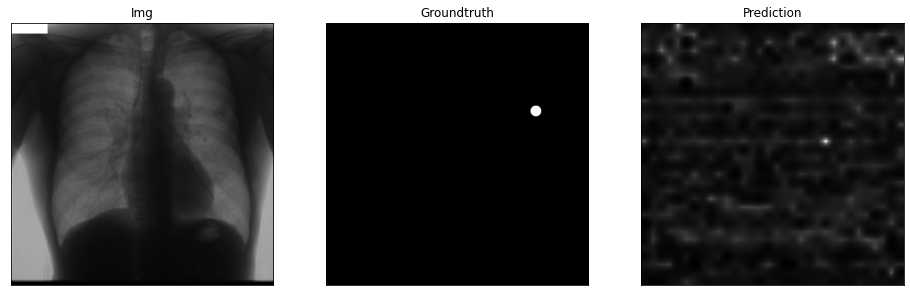


 Index:2, IoU=0.00000


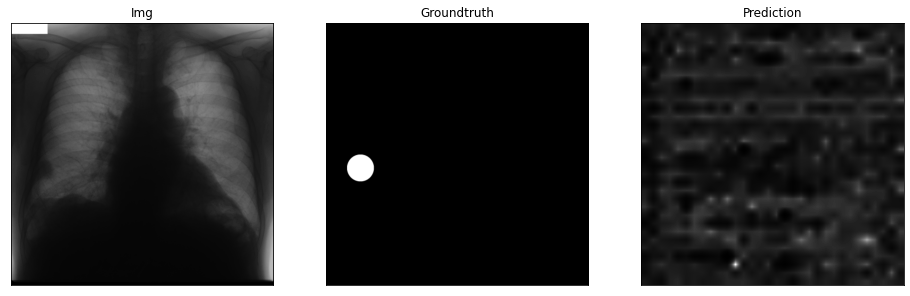


 Index:3, IoU=0.00000


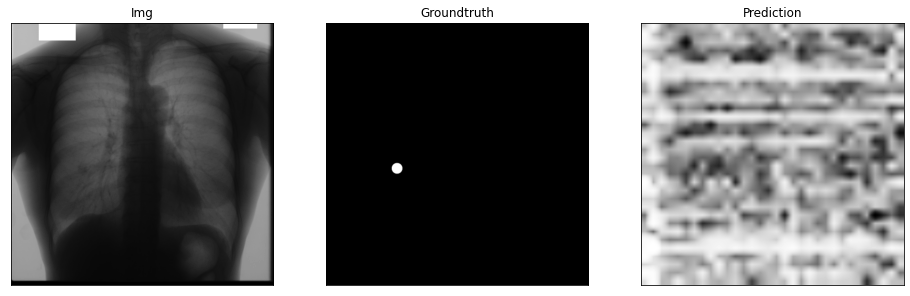


 Index:4, IoU=0.00000


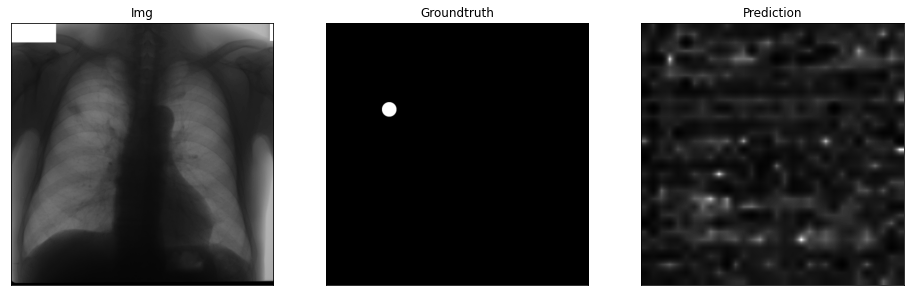


 Index:5, IoU=0.00000


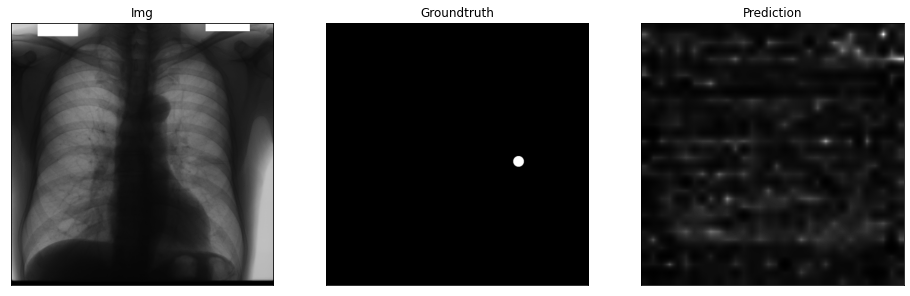


 Index:6, IoU=0.01062


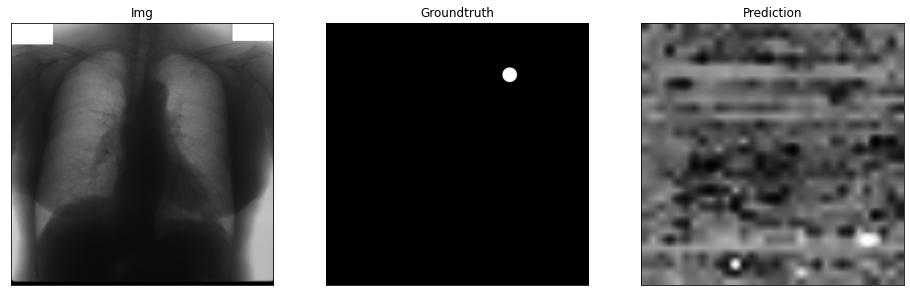


 Index:7, IoU=0.00478


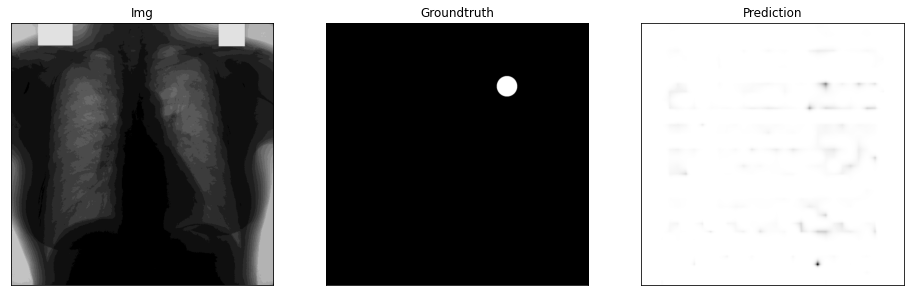


 Index:8, IoU=0.00000


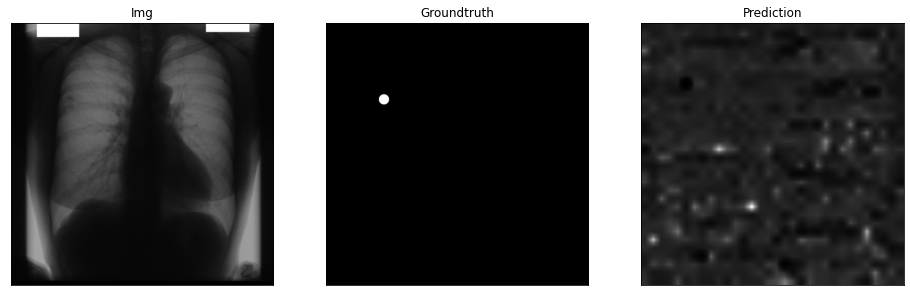


 Index:9, IoU=0.00000


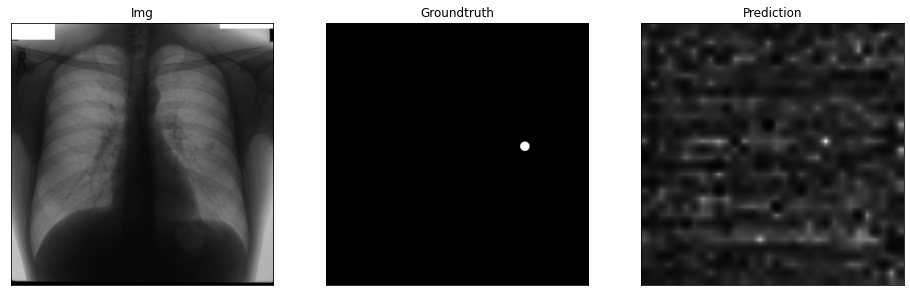


 Index:10, IoU=0.00000


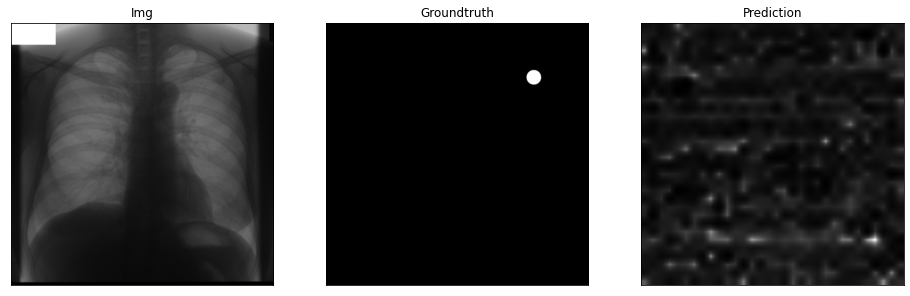


 Index:11, IoU=0.00000


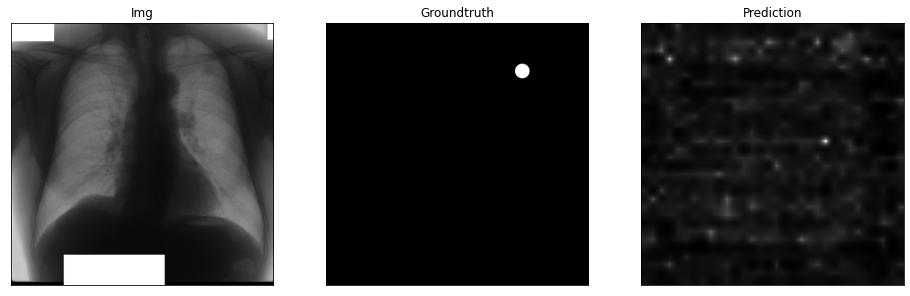


 Index:12, IoU=0.00000


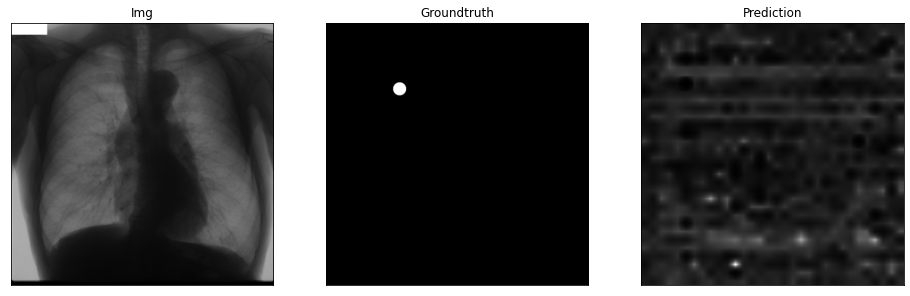


 Index:13, IoU=0.00000


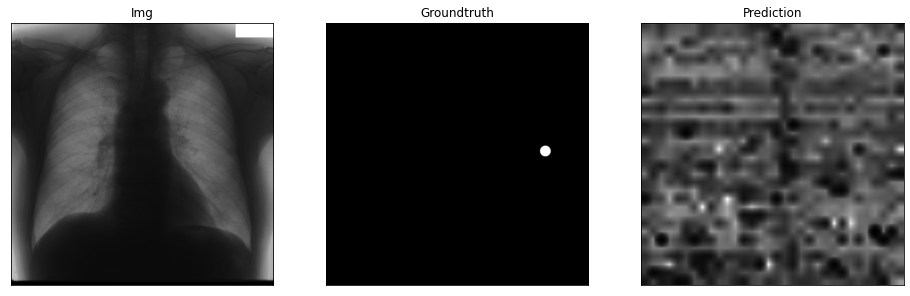


 Index:14, IoU=0.00000


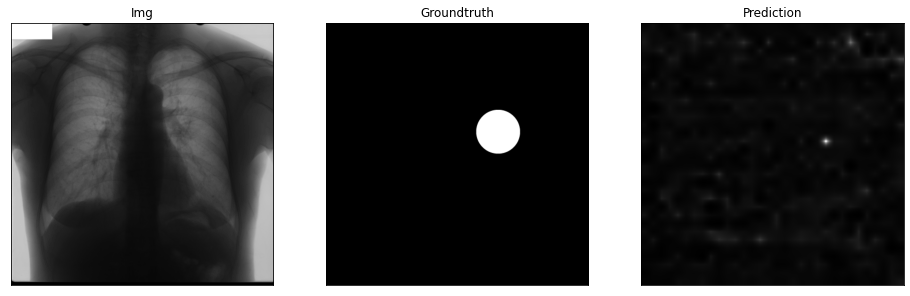


 Index:15, IoU=0.00000


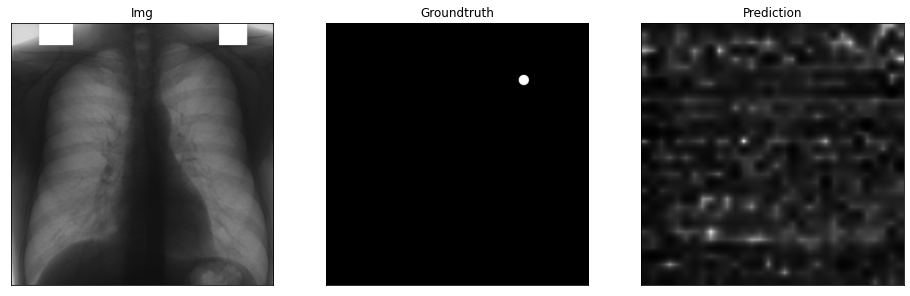


 Index:16, IoU=0.00000


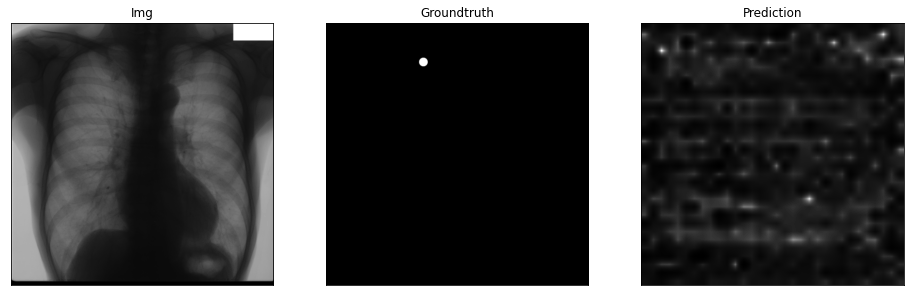


 Index:17, IoU=0.00000


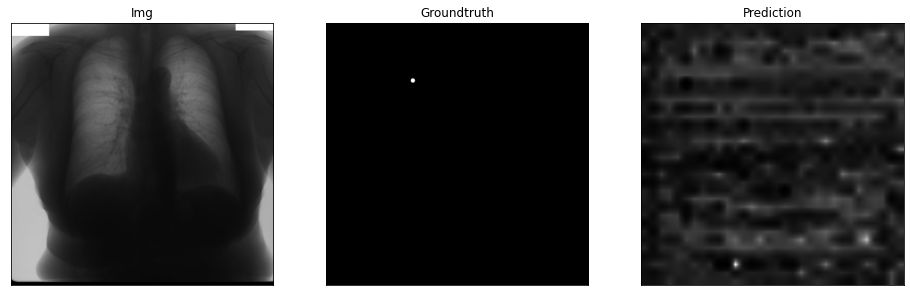


 Index:18, IoU=0.00000


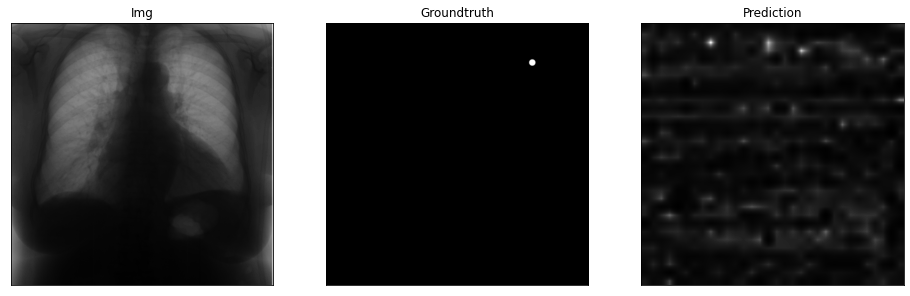


 Index:19, IoU=0.00000


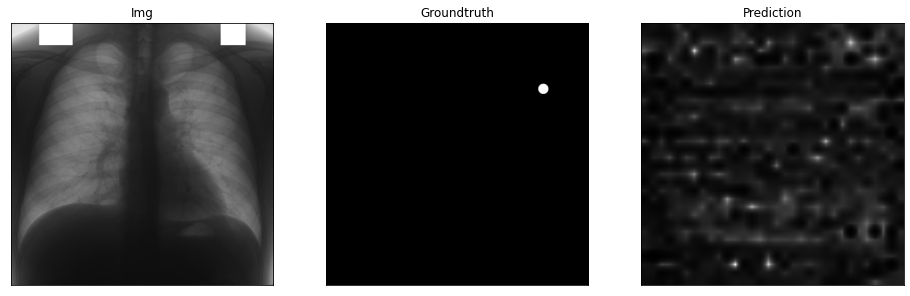


 Index:20, IoU=0.00000


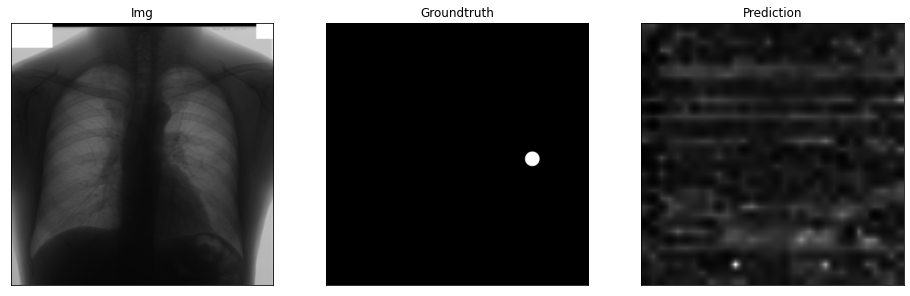


 Index:21, IoU=0.00000


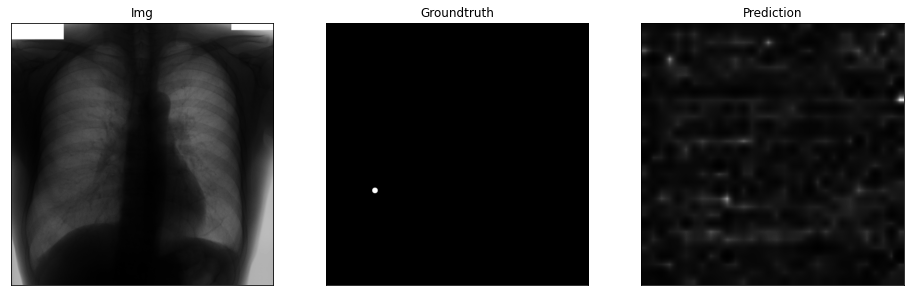


 Index:22, IoU=0.00142


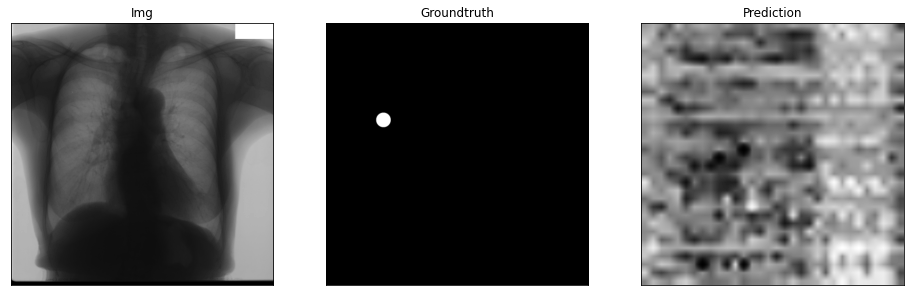


 Index:23, IoU=0.00000


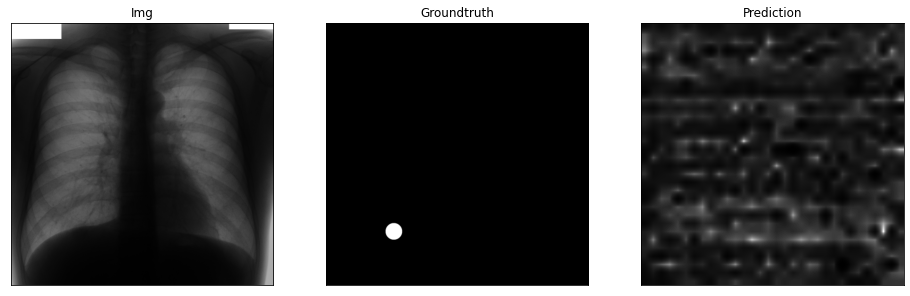


 Index:24, IoU=0.00000


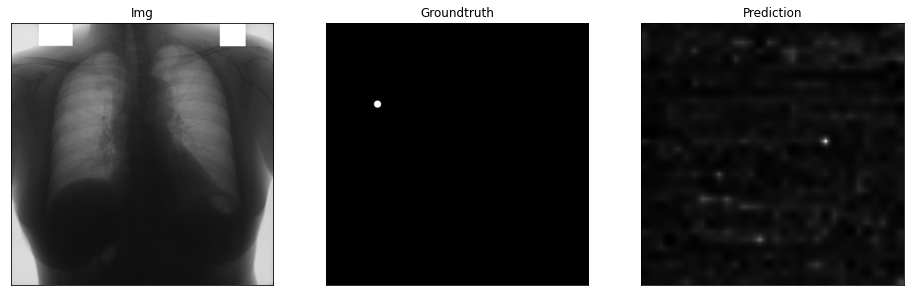


 Index:25, IoU=0.00132


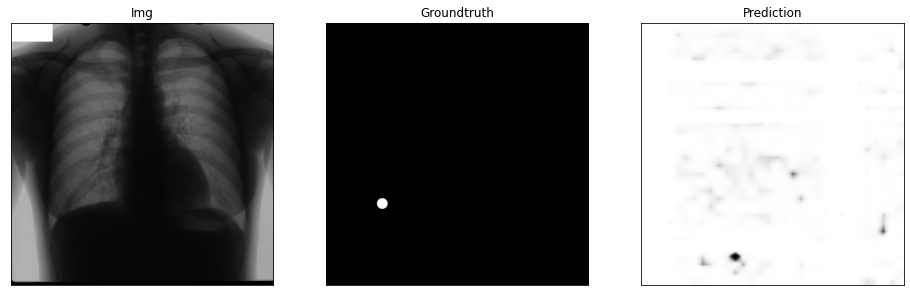


 Index:26, IoU=0.00000


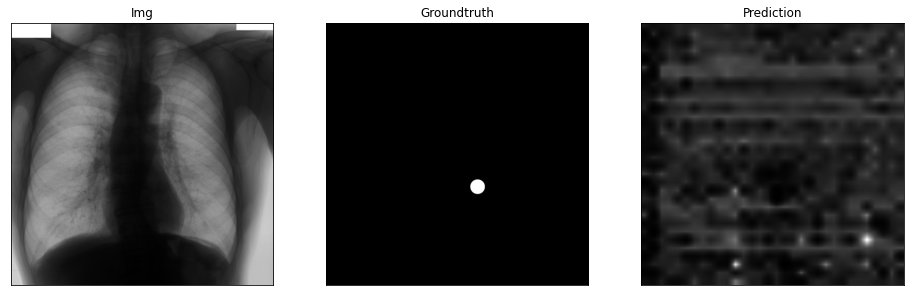


 Index:27, IoU=0.00000


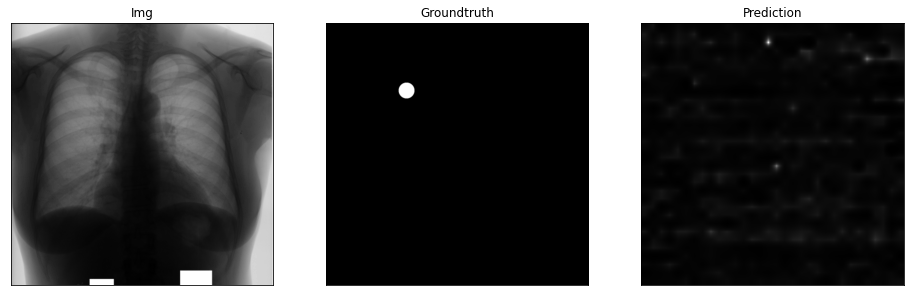


 Index:28, IoU=0.00067


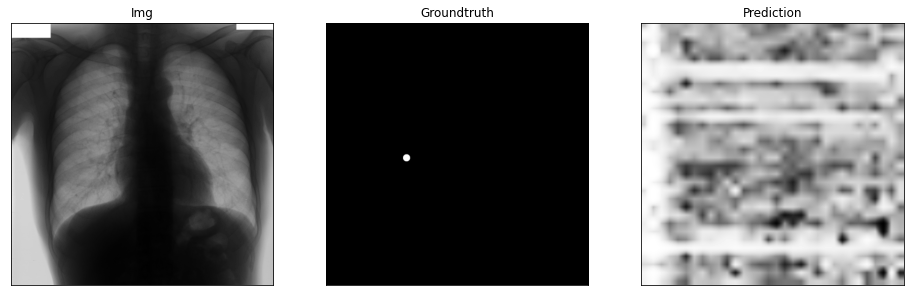


 Index:29, IoU=0.00000


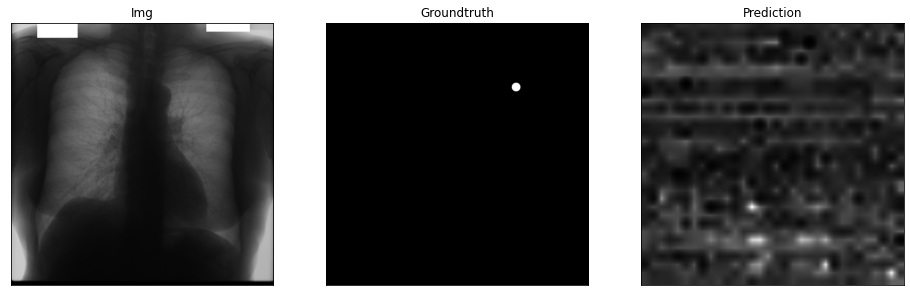


 Index:30, IoU=0.00000


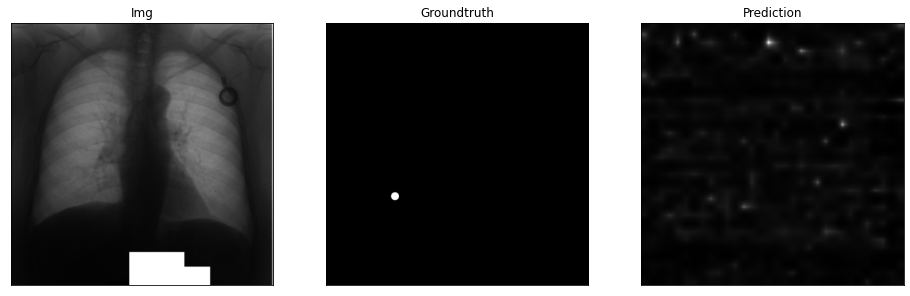

In [19]:
for index, data in enumerate(zip(imgs, predict, msks, iou_score)):
    img, pr, msk, iou = data
    print("\n Index:{}, IoU={:.5f}".format(index+1, iou))
    visualize(
        img = img,
        groundtruth = msk,
        prediction = pr
    )

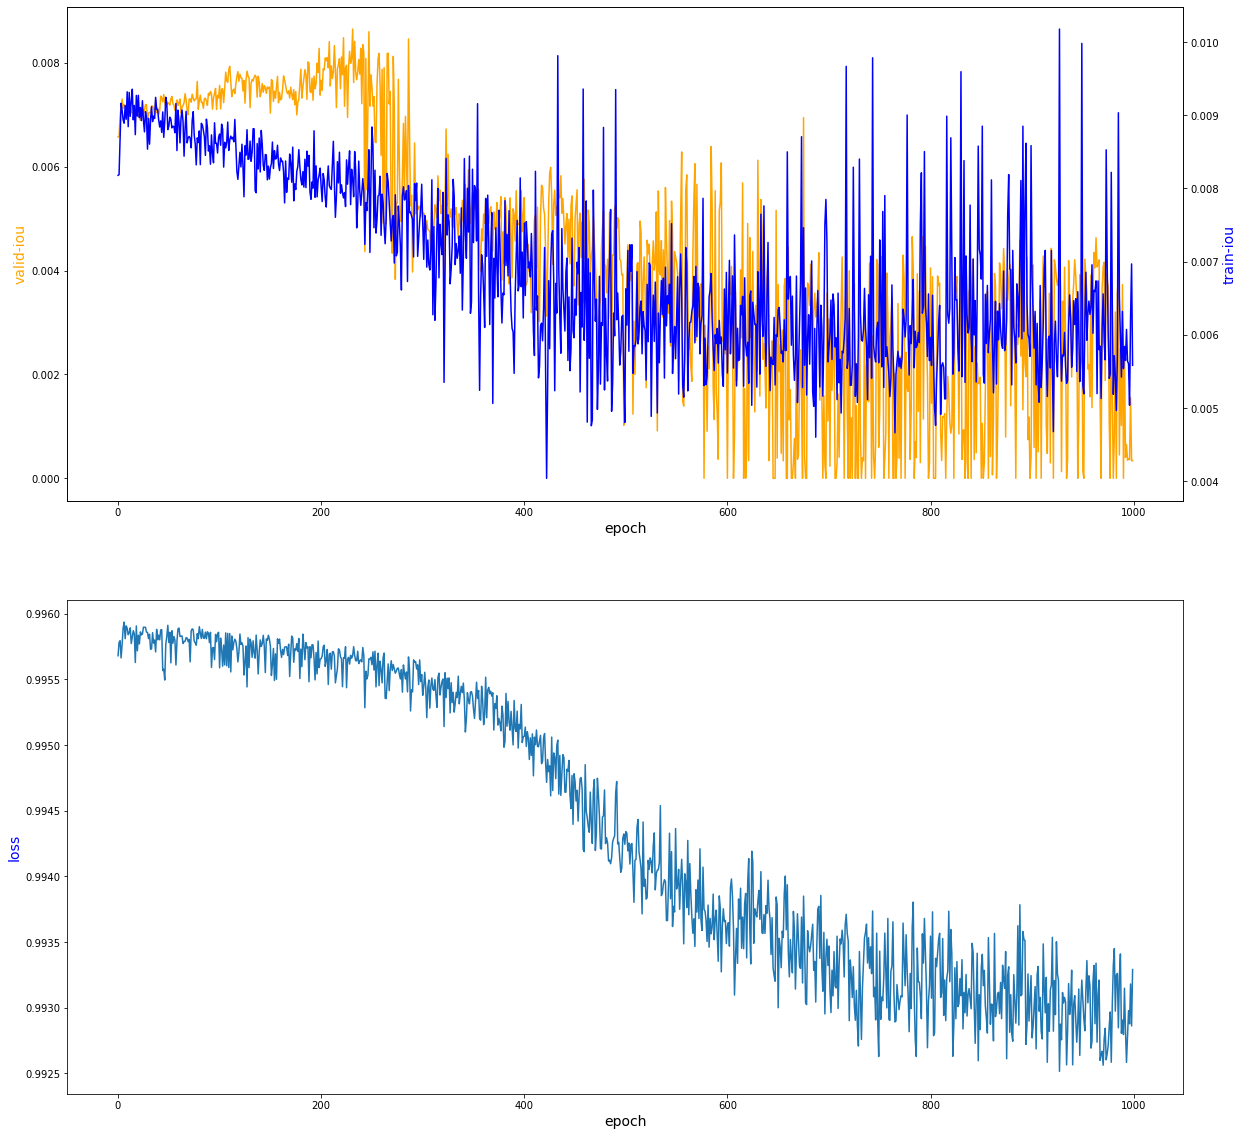

In [20]:
# create figure and axis objects with subplots()
fig, axs = plt.subplots(2, 1, figsize=(20, 20))
# make a plot
axs[0].plot(epoch_logs['iou-valid'], color="orange", label="valid iou")
# set x-axis label
axs[0].set_xlabel("epoch",fontsize=14)
# set y-axis label
axs[0].set_ylabel("valid-iou",color="orange",fontsize=14)


# twin object for two different y-axis on the sample plot
ax2 = axs[0].twinx()
# make a plot with different y-axis using second axis object
ax2.plot(epoch_logs['iou-train'], color="blue", label="train iou")
ax2.set_ylabel("train-iou", color="blue", fontsize=14)



axs[1].plot(epoch_logs['diceloss'], label="diceloss")
# axs[1].plot(epoch_logs['kl divergence'], label="kl divergence")
# axs[1].plot(epoch_logs['diagonal loss'], label="diagonal loss")
axs[1].set_xlabel("epoch",fontsize=14)
axs[1].set_ylabel("loss", color="blue", fontsize=14)
plt.show()

fig.savefig(os.path.join(os.getcwd(),'Ex2.png'),
            bbox_inches='tight',
           facecolor='white')